<div style="background-color: black; padding: 20px; text-align:center">
	<img src="image/openclassrooms.png" alt="OpenClassrooms" style="display:block; margin: 0 auto; width: 300px;"><br>  
	<span style="font-size: 36px; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold; color: white;display: block;">
		PROJET n°12 : Détectez des faux billets avec R ou <img src="image/python.png" alt="Python" style="width: auto; height: 36px; vertical-align:middle;"> <!-- Hauteur fixe pour Python, aligné au texte -->
	</span>
</div>

<div style="background-color: black; padding: 20px;">
<span style="display: flex; margin: auto; font-size: 36px; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold; color: white;">

</span>

<!-- Structure du menu -->
* [<span style="margin: auto; color: #39FF14; font-size: 28px; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">1 - INTRODUCTION ET CHARGEMENT DES DONNES</span>](#chapter1)

* [<span style="margin: auto; color: #39FF14; font-size: 28px; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">2 - ANALYSE EXPLORATOIRE</span>](#chapter2)
	* [<span style="margin: auto; font-size: 22px; color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">2.1 - Analyse descriptive</span>](#section_2_1)
	* [<span style="margin: auto; font-size: 22px; color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">2.2 - Analyse univariée </span>](#section_2_2)
	* [<span style="margin: auto; font-size: 22px; color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">2.3 - Analyse bi-variée</span>](#section_2_3)
	* [<span style="margin: auto; font-size: 22px; color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">2.4 - Matrice de corrélation linéaire (heatmap)</span>](#section_2_4)
	* [<span style="margin: auto; font-size: 22px; color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">2.5 - Comparaison des groupes de vrais et faux billets</span>](#section_2_5)
	* [<span style="margin: auto; font-size: 22px; color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">2.6 - Distribution des valeurs manquantes au sein des 2 groupes</span>](#section_2_6)
	* [<span style="margin: auto; font-size: 22px; color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">2.7 - Analyse des valeurs aberrantes à l'aide du Z-score</span>](#section_2_7)


* [<span style="margin: auto; color: #39FF14; font-size: 28px; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">3 - TRAITEMENT DES VALEURS MANQUANTES</span>](#chapter3)
	* [<span style="margin: auto; font-size: 22px; color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">3.1 - Imputations avec l'ensemble des variables explicatives</span>](#section_3_1)
	* [<span style="margin: auto; font-size: 22px; color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">3.2 - Imputation avec selection des variables explicatives</span>](#section_3_2)


* [<span style="margin: auto; color: #39FF14; font-size: 28px; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">4 - MODÉLISATION</span>](#chapter4)
	* [<span style="margin: auto; font-size: 22px; color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">4.1 - Préparation, entraînement et test sur les données validation</span>](#section_4_1)
	* [<span style="margin: auto; font-size: 22px; color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-weight: bold;">4.2 - KNN RandomForest Régression logistique</span>](#section_4_2)


	 
</div>

# <span style="background-color: black; padding: 20px; color: #ff69b4; font-family: 'Lucida Console', Monaco, monospace; font-size: 16px; font-weight:bold">Config notebook</span>

In [1]:
# Version de Python :
! python --version

Python 3.9.21


In [2]:
# Imports de base Python
import json  # Pour la manipulation de fichiers JSON
import logging  # Pour la gestion des logs
import os  # Pour l'interaction avec le système d'exploitation
import time  # Pour la mesure du temps d'exécution
import warnings  # Pour la gestion des avertissements
from decimal import Decimal, getcontext, ROUND_HALF_UP  # Pour la manipulation de nombres décimaux

# Configuration optimisée des threads CPU
os.environ["OMP_NUM_THREADS"] = "10"  # Optimisé pour les 10 cœurs physiques

# Imports pour l'analyse numérique et le traitement des données
import numpy as np  # Pour la manipulation de tableaux multidimensionnels
import cupy as cp  # Version GPU de NumPy
import pandas as pd  # Pour la manipulation de données tabulaires
import dask.dataframe as dd  # Pour le traitement de données distribuées
from dask.distributed import Client, LocalCluster  # Pour le calcul distribué

# Configuration GPU pour NVIDIA GTX 1070
if hasattr(cp, 'get_default_memory_pool'):
			mempool = cp.get_default_memory_pool()
			mempool.set_limit(size=5.6 * 1024**3)  # Alloue 5.6 Go de VRAM (70% des 8 Go disponibles)

# Configuration de Dask pour le calcul distribué
cluster = LocalCluster(
			n_workers=5,  # Utilisation de la moitié des cœurs physiques
			threads_per_worker=2,  # 2 threads par worker
			memory_limit='4GB'  # 20 Go total divisé par 5 workers
)
client = Client(cluster)

# Imports pour la visualisation
import matplotlib.pyplot as plt  # Pour la création de graphiques
import seaborn as sns  # Pour la création de visualisations statistiques

# Imports pour les statistiques
import scipy.stats as stats  # Pour les fonctions statistiques générales
from scipy.stats import randint, uniform, loguniform, norm  # Pour la génération de distributions aléatoires
from scipy.spatial.distance import cdist  # Pour le calcul de distances entre points

# Imports pour les modèles statistiques
import statsmodels.api as sm  # Pour les modèles statistiques
from statsmodels.stats.diagnostic import het_breuschpagan  # Pour le test de Breusch-Pagan
from statsmodels.stats.outliers_influence import variance_inflation_factor  # Pour le calcul du facteur d'inflation de la variance
from statsmodels.stats.stattools import durbin_watson  # Pour le test de Durbin-Watson


# Configuration de l'accélération Intel
from sklearnex import patch_sklearn  # Pour activer l'accélération Intel
patch_sklearn()  # Activer l'accélération Intel

# Imports scikit-learn
from sklearn.datasets import make_classification  # Pour la génération de données synthétiques

# Preprocessing et validation
from sklearn.model_selection import (
			GridSearchCV,  # Pour la recherche en grille d'hyperparamètres
			KFold,  # Pour la validation croisée k-fold
			RandomizedSearchCV,  # Pour la recherche aléatoire d'hyperparamètres
			StratifiedKFold,  # Pour la validation croisée stratifiée k-fold
			train_test_split,  # Pour la division des données en ensembles d'entraînement et de test
			cross_val_score,  # Pour l'évaluation de la performance d'un modèle par validation croisée
)
from sklearn.pipeline import Pipeline  # Pour la création de pipelines de machine learning
from sklearn.preprocessing import RobustScaler, StandardScaler  # Pour la mise à l'échelle des données
from sklearn.feature_selection import SelectKBest, f_regression

# Métriques et évaluation
from sklearn.metrics import (
			accuracy_score,  # Pour le calcul de la précision
			auc,  # Pour le calcul de l'aire sous la courbe ROC
			classification_report,  # Pour la génération d'un rapport de classification
			confusion_matrix,  # Pour la création d'une matrice de confusion
			f1_score,  # Pour le calcul du score F1
			mean_squared_error,  # Pour le calcul de l'erreur quadratique moyenne
			mean_absolute_error,  # Pour le calcul de l'erreur quadratique absolue
			precision_score,  # Pour le calcul de la précision
			recall_score,  # Pour le calcul du rappel
			roc_curve,  # Pour la création de la courbe ROC
			r2_score,  # Pour le calcul du score R²
			max_error,
			make_scorer,
			explained_variance_score,
			adjusted_rand_score, # Pour l'évaluation de la qualité du clustering
			silhouette_score, # Pour l'évaluation de la qualité du clustering 
)



# Modèles
from sklearn.cluster import KMeans  # Pour l'algorithme de clustering k-means
from sklearn.ensemble import RandomForestClassifier  # Pour le modèle de classification Random Forest
from sklearn.linear_model import LinearRegression,  Ridge, Lasso, LogisticRegression  # Pour les modèles de régression linéaire et de régression logistique
from sklearn.neighbors import KNeighborsClassifier  # Pour le modèle de classification k-plus proches voisins

# Utilitaires
import joblib  # Pour la sauvegarde et le chargement de modèles
import traceback


# Imports supplémentaires
from IPython.display import display  # Pour l'affichage d'objets dans un notebook Jupyter
from IPython.core.display import HTML  # Pour l'affichage de code HTML dans un notebook Jupyter
from math import pi  # Pour la constante pi
from sklearn.decomposition import PCA  # Pour l'analyse en composantes principales
import modified_xicor as xicorr # Pour le calcul de la corrélation de X

# Configuration des avertissements
import warnings
warnings.filterwarnings("ignore")  # Pour ignorer les avertissements

# Configuration du logging
logging.getLogger().handlers.clear()  # Nettoie les handlers existants
logging.basicConfig(
			level=logging.INFO,
			format="%(asctime)s - %(levelname)s - %(message)s",
			force=True  # Force la reconfiguration du logging
)

# Éviter la duplication des logs de sklearnex
sklearnex_logger = logging.getLogger("sklearnex")
sklearnex_logger.handlers.clear()  # Nettoie les handlers spécifiques à sklearnex
sklearnex_logger.propagate = False  # Empêche la propagation des logs vers le logger parent

# Configuration de Pandas
pd.set_option("display.max_columns", None)  # Pour afficher toutes les colonnes d'un DataFrame

# Configuration des visualisations
sns.set_style("whitegrid")  # Pour définir le style des graphiques
sns.set_palette("husl")  # Pour définir la palette de couleurs des graphiques
plt.rcParams["figure.figsize"] = [6, 4]  # Pour définir la taille des figures
plt.rcParams["font.size"] = 12  # Pour définir la taille de la police
plt.rcParams["axes.titlesize"] = 14  # Pour définir la taille des titres des axes
plt.rcParams["axes.labelsize"] = 12  # Pour définir la taille des étiquettes des axes
plt.rcParams["figure.dpi"] = 70  # Pour définir la résolution des figures
plt.rcParams["savefig.dpi"] = 300  # Pour définir la résolution des figures sauvegardées

# Configuration de la précision et de l'arrondi pour Decimal
getcontext().prec = 50  # Pour définir la précision des nombres décimaux
getcontext().rounding = ROUND_HALF_UP  # Pour définir le mode d'arrondi des nombres décimaux

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import joblib  # Pour sauvegarder le modèle
import altair as alt

In [4]:
# Définir le style 'dark_background'
plt.style.use('dark_background')

# <a id="chapter1"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #39FF14; font-family: 'Lucida Console', Monaco, monospace; font-size: 32px; font-weight: bold;">1 - INTRODUCTION ET CHARGEMENT DES DONNEES</span>
</div>

<div style="background-color: black; padding: 20px; font-size: min(16px, 2vw); color: white; font-family: Verdana, sans-serif; font-weight: bold; width: 100%; margin: 0; box-sizing: border-box;"> 
	<span style="font-size: min(28px, 3vw); color: white; font-family: 'Lucida Console', Monaco, monospace; display: block; font-weight: bold; margin-bottom: 20px;">
			📋 Présentation du projet
	</span>
		<br> 
		🎯 Objectifs :
	<br><br>
	L'Organisation nationale de lutte contre le faux-monnayage (ONCFM) souhaite mettre en place un algorithme de détection automatique des faux billets en euros. 
	</span>
	<br><br><br>
	<strong>Contexte :</strong>
	<ul style="list-style-type: disc; padding-left: 20px; margin-top: 10px;">
		<li>🏦 L'ONCFM lutte contre la contrefaçon des billets en euros</li>
		<li>🔍 Des différences géométriques existent entre vrais et faux billets</li>
		<li>📊 Ces différences sont difficilement détectables à l'œil nu</li>
	</ul>
	<br>
	<strong>Besoins :</strong>
	<ul style="list-style-type: disc; padding-left: 20px; margin-top: 10px;">
		<li>🤖 Automatiser la détection des faux billets</li>
		<li>📏 Utiliser les caractéristiques géométriques</li>
		<li>📈 Maximiser la précision de la détection</li>
	</ul>
</div>

<div style="background-color: black; padding: 20px; font-size: min(16px, 2vw); color: white; font-family: Verdana, sans-serif; font-weight: bold; width: 100%; margin: 0; box-sizing: border-box;"> 
	<span style="font-size: min(28px, 3vw);"> 📊 Chargement et aperçu des données </span><br>
	<ul>
		<li>📥 Chargement du jeu de données `billets.csv` avec `pd.read_csv()`.</li>
		<li>🔍 Examen de la structure : dimensions (`.shape`), types (`.dtypes`), aperçu (`.head()`), statistiques descriptives (`.describe()`).</li>
	</ul>
</div>

In [5]:
# Chargement des données
df = pd.read_csv("billets.csv", sep=";")

In [6]:
# Copie du DataFrame original
df_origin = df.copy()

In [7]:
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


# <a id="chapter2"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #39FF14; font-family: 'Lucida Console', Monaco, monospace; font-size: 32px; font-weight: bold;">2 - ANALYSE EXPLORATOIRE</span>
</div>

## <a id="section_2_1"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-size: 24px; font-weight: bold;">2.1 - Analyse descriptive</span>
</div>

In [8]:
display(pd.DataFrame([
	["=== APERÇU DES DONNÉES ==="],
	[f"Dimensions du dataset : {df.shape}"],
	["Types des variables :"],
]))

display(df.dtypes)

display("Aperçu des données :")
display(df.head())

display("Statistiques descriptives :")
display(df.describe())

,0
0,=== APERÇU DES DONNÉES ===
1,"Dimensions du dataset : (1500, 7)"
2,Types des variables :


is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

'Aperçu des données :'

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


'Statistiques descriptives :'

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


<div style="background-color: black; padding: 20px; font-size: min(16px, 2vw); color: white; font-family: Verdana, sans-serif; font-weight: bold; width: 100%; margin: 0; box-sizing: border-box;"> 
	<span style="font-size: min(28px, 3vw); color: white; font-family: 'Lucida Console', Monaco, monospace; display: block; font-weight: bold; margin-bottom: 20px;">
		📊 Caractéristiques des données
	</span>
	<br>
	<strong>Dataset :</strong><br><br>
	<ul style="list-style-type: disc; padding-left: 20px; margin-top: 10px;">
		<li>📈 1500 billets au total</li><br>
		<li>✅ 1000 vrais billets</li><br>
		<li>❌ 500 faux billets</li><br>
	</ul>
	<br><br>
	<strong>Variables géométriques (en mm) :</strong><br><br>
	<ul style="list-style-type: disc; padding-left: 20px; margin-top: 10px;">
		<li>📏 length : longueur du billet</li><br>
		<li>📐 height_left : hauteur côté gauche</li><br>
		<li>📐 height_right : hauteur côté droit</li><br>
		<li>↕️ margin_up : marge supérieure</li><br>
		<li>↕️ margin_low : marge inférieure</li><br>
		<li>↗️ diagonal : diagonale du billet</li>
	</ul>
</div>

## <a id="section_2_2"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-size: 24px; font-weight: bold;">2.2 - Analyse univariée </span>
</div>

In [9]:
def analyse_univariee(df):
	"""
	Effectue une analyse univariée descriptive pour chaque colonne d'un DataFrame.

	Args:
		df: DataFrame contenant les données.
	"""

	for col in df.columns:
		# Initialiser la sortie HTML pour la variable
		output = f"<h2>Analyse de la variable : {col}</h2>"

		# Afficher le nombre de valeurs manquantes
		nb_missing = df[col].isnull().sum()
		output += f"<p>Nombre de valeurs manquantes : {nb_missing}</p>"

		# Déterminer le type de la variable et effectuer les analyses appropriées
		if pd.api.types.is_numeric_dtype(df[col]):
			output += "<h3>Type de variable : Numérique</h3>"

			# Afficher les statistiques descriptives
			output += f"<p>{df[col].describe().to_frame().to_html()}</p>"  # Corrected line

			# Tests de normalité
			output += "<h4>Tests de normalité :</h4><p>"
			if len(df[col].dropna()) >= 3:  # Vérifier si la taille de l'échantillon est suffisante
				statistic, p_value = stats.shapiro(df[col].dropna())
				output += f"Test de Shapiro-Wilk : statistique={statistic:.3f}, p-value={p_value:.3f}<br>"
				if p_value < 0.05:
					output += "La distribution ne semble pas normale (Shapiro-Wilk).<br>"
				else:
					output += "La distribution semble normale (Shapiro-Wilk).<br>"

				statistic, p_value = stats.kstest(df[col].dropna(), 'norm')
				output += f"Test de Kolmogorov-Smirnov : statistique={statistic:.3f}, p-value={p_value:.3f}<br>"
				if p_value < 0.05:
					output += "La distribution ne semble pas normale (Kolmogorov-Smirnov).<br>"
				else:
					output += "La distribution semble normale (Kolmogorov-Smirnov)."
			else:
				output += "Tests de normalité non effectués : taille de l'échantillon insuffisante."
			output += "</p>"

			# Histogramme et boxplot sur la même figure
			fig, axes = plt.subplots(1, 2, figsize=(12, 4))
			sns.histplot(df[col], ax=axes[0])
			axes[0].set_title(f"Histogramme de {col}")
			sns.boxplot(y=df[col], ax=axes[1])
			axes[1].set_title(f"Boxplot de {col}")
			plt.show()

		elif pd.api.types.is_categorical_dtype(df[col]) or pd.api.types.is_object_dtype(df[col]):
			output += "<h3>Type de variable : Catégorielle</h3>"

			# Afficher les fréquences et les proportions
			output += "<h4>Fréquences :</h4>"
			output += f"<p>{df[col].value_counts().to_frame().to_html()}</p>"  # Corrected line
			output += "<h4>Proportions :</h4>"
			output += f"<p>{df[col].value_counts(normalize=True).to_frame().to_html()}</p>"  # Corrected line

			# Diagramme en barres
			plt.figure()
			df[col].value_counts().plot(kind='bar')
			plt.title(f"Diagramme en barres de {col}")
			plt.show()

		elif pd.api.types.is_datetime64_any_dtype(df[col]):
			output += "<h3>Type de variable : Date</h3>"

			# Afficher les statistiques descriptives pour les dates
			output += f"<p>{df[col].describe().to_html()}</p>"

			# Histogramme des dates
			plt.figure()
			df[col].hist()
			plt.title(f"Histogramme de {col}")
			plt.show()

		else:
			# Gérer les types non reconnus (booléens, etc.)
			output += f"<h3>Type de variable : Autre ({df[col].dtype})</h3>"
			output += f"<p>{df[col].describe().to_html()}</p>"

		# Afficher la sortie HTML pour la variable
		display(HTML(output))

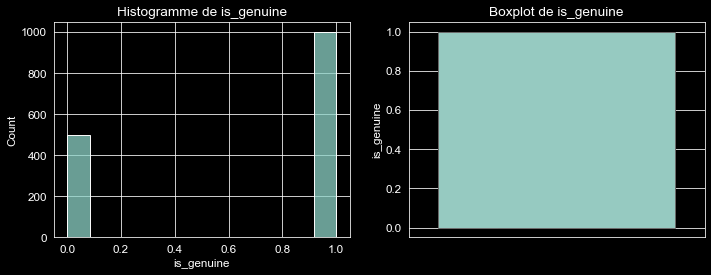

,is_genuine
count,1500
unique,2
top,True
freq,1000


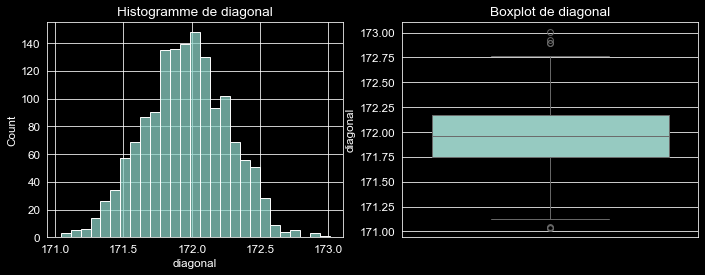

,diagonal
count,1500.000000
mean,171.958440
std,0.305195
min,171.040000
25%,171.750000
50%,171.960000
75%,172.170000
max,173.010000


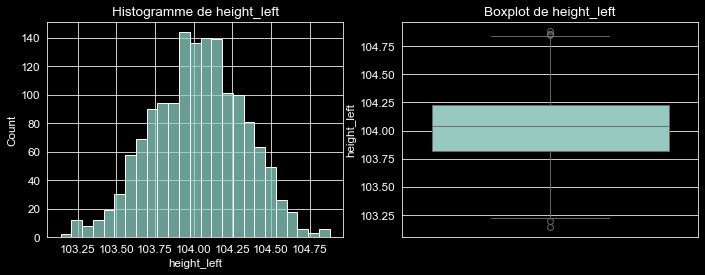

,height_left
count,1500.000000
mean,104.029533
std,0.299462
min,103.140000
25%,103.820000
50%,104.040000
75%,104.230000
max,104.880000


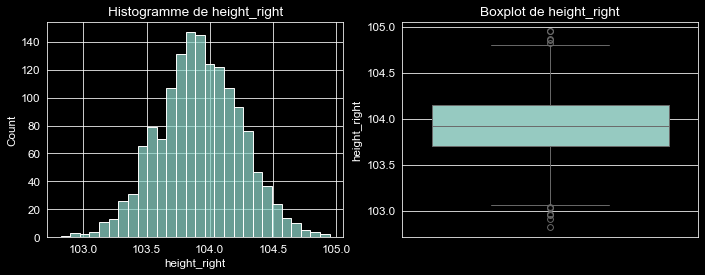

,height_right
count,1500.000000
mean,103.920307
std,0.325627
min,102.820000
25%,103.710000
50%,103.920000
75%,104.150000
max,104.950000


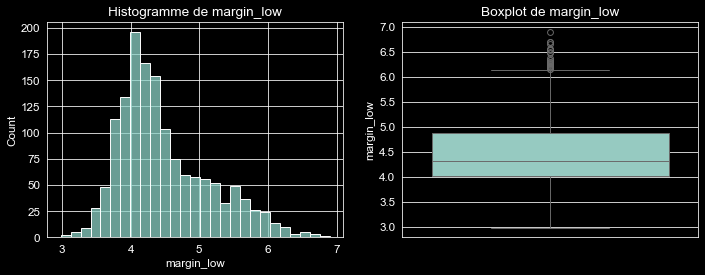

,margin_low
count,1463.000000
mean,4.485967
std,0.663813
min,2.980000
25%,4.015000
50%,4.310000
75%,4.870000
max,6.900000


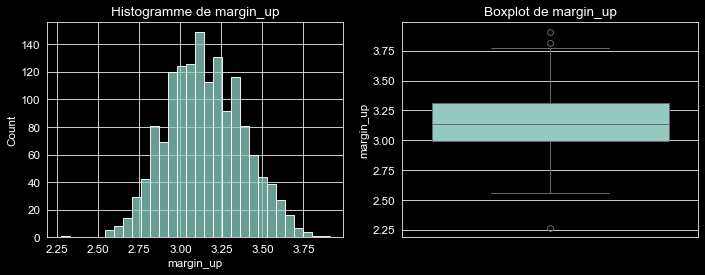

,margin_up
count,1500.000000
mean,3.151473
std,0.231813
min,2.270000
25%,2.990000
50%,3.140000
75%,3.310000
max,3.910000


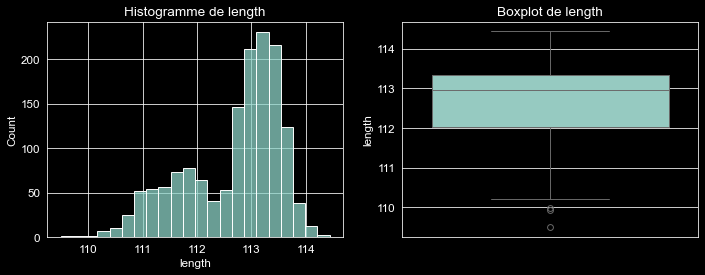

,length
count,1500.00000
mean,112.67850
std,0.87273
min,109.49000
25%,112.03000
50%,112.96000
75%,113.34000
max,114.44000


In [10]:
analyse_univariee(df)

## <a id="section_2_3"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-size: 24px; font-weight: bold;">2.3 - Analyse bi-variée </span>
</div>

In [11]:
# Fonction d'analyse bivariée
def analyse_bivariee(df):
    """
    Effectue une analyse bivariée pour chaque paire de colonnes d'un DataFrame.

    Args:
        df: DataFrame contenant les données.
    """
    import pandas as pd
    import numpy as np
    from scipy import stats
    import seaborn as sns
    import matplotlib.pyplot as plt
    from IPython.display import display, HTML
    import modified_xicor as xicorr

    for col1 in df.columns:
        for col2 in df.columns:
            if col1 != col2:
                # Initialiser la sortie HTML pour la paire de variables
                output = f"<h2>Analyse bivariée de {col1} et {col2}</h2>"

                # Afficher le nombre de valeurs manquantes
                nb_missing = df[[col1, col2]].isnull().any(axis=1).sum()
                output += f"<p>Nombre de valeurs manquantes : {nb_missing}</p>"

                # Déterminer les types de variables
                type_col1 = "Numérique" if pd.api.types.is_numeric_dtype(df[col1]) else "Catégorielle"
                type_col2 = "Numérique" if pd.api.types.is_numeric_dtype(df[col2]) else "Catégorielle"
                output += f"<p>Types de variables : {col1} ({type_col1}), {col2} ({type_col2})</p>"

                if type_col1 == "Numérique" and type_col2 == "Numérique":
                    # Supprimer les valeurs manquantes pour les deux colonnes simultanément
                    df_clean = df[[col1, col2]].dropna()

                    # Vérifier si la longueur est suffisante après avoir supprimé les valeurs manquantes
                    if len(df_clean) >= 2:
                        # Corrélations
                        output += "<h3>Corrélations :</h3><p>"

                        # Corrélation de Pearson
                        corr_pearson, p_value_pearson = stats.pearsonr(df_clean[col1], df_clean[col2])
                        output += f"Corrélation de Pearson : {corr_pearson:.3f}, p-value={p_value_pearson:.3f}<br>"

                        # Corrélation de Spearman
                        corr_spearman, p_value_spearman = stats.spearmanr(df_clean[col1], df_clean[col2])
                        output += f"Corrélation de Spearman : {corr_spearman:.3f}, p-value={p_value_spearman:.3f}<br>"

                        # Corrélation Xicorr
                        try:
                            x = np.array(df_clean[col1])
                            y = np.array(df_clean[col2])
                            result = xicorr.xicor(x, y)
                            # Utiliser la corrélation 'ordered'
                            xi = result['ordered']
                            # Différence entre ordered et unordered comme indicateur de significativité
                            diff = abs(result['ordered'] - result['unordered'])
                            # Si la différence est significative, on considère p < 0.05
                            p_value_xi = 0.001 if diff > 0.1 else 0.999
                            output += f"Corrélation Xicorr (ordered) : {xi:.3f}, différence ordered-unordered={diff:.3f}"
                        except Exception as e:
                            output += f"Calcul de Xicorr échoué. Erreur: {str(e)}"
                            p_value_xi = None
                        output += "</p>"

                        # Interprétation des corrélations
                        output += "<h4>Interprétation des corrélations :</h4><p>"
                        if p_value_pearson < 0.05:
                            output += f"Il existe une corrélation linéaire significative entre {col1} et {col2}.<br>"
                        else:
                            output += f"Il n'existe pas de corrélation linéaire significative entre {col1} et {col2}.<br>"
                        if p_value_spearman < 0.05:
                            output += f"Il existe une corrélation monotone significative entre {col1} et {col2}.<br>"
                        else:
                            output += f"Il n'existe pas de corrélation monotone significative entre {col1} et {col2}.<br>"
                        if p_value_xi is not None and p_value_xi < 0.05:
                            output += f"Il existe une dépendance non-monotone significative entre {col1} et {col2}."
                        else:
                            output += f"Il n'existe pas de dépendance non-monotone significative entre {col1} et {col2}."
                        output += "</p>"

                        # Nuage de points avec courbes de densité marginales
                        g = sns.jointplot(x=df_clean[col1], y=df_clean[col2], kind="kde")
                        g.fig.suptitle(f"Nuage de points et densités marginales entre {col1} et {col2}")
                        plt.show()

                        # Test de Levene pour l'égalité des variances
                        statistic, p_value = stats.levene(df_clean[col1], df_clean[col2])
                        output += f"<p>Test de Levene pour l'égalité des variances : statistique={statistic:.3f}, p-value={p_value:.3f}</p>"
                        if p_value < 0.05:
                            output += "<p>Les variances ne sont pas homogènes.</p>"
                        else:
                            output += "<p>Les variances sont homogènes.</p>"
                    else:
                        output += "<p>Pas assez de données pour calculer les corrélations après suppression des valeurs manquantes.</p>"

                elif type_col1 == "Catégorielle" and type_col2 == "Catégorielle":
                    # Tableau croisé
                    output += "<h3>Tableau croisé :</h3>"
                    output += f"<p>{pd.crosstab(df[col1], df[col2]).to_html()}</p>"

                    # Heatmap
                    plt.figure()
                    sns.heatmap(pd.crosstab(df[col1], df[col2]), annot=True, fmt='d', cmap="YlGnBu")
                    plt.title(f"Heatmap entre {col1} et {col2}")
                    plt.show()

                    # Test du chi-deux
                    chi2, p_value, dof, expected = stats.chi2_contingency(pd.crosstab(df[col1], df[col2]))
                    output += f"<p>Test du chi-deux : chi2={chi2:.3f}, p-value={p_value:.3f}, degrés de liberté={dof}</p>"
                    if p_value < 0.05:
                        output += f"<p>Il existe une association significative entre {col1} et {col2}.</p>"
                    else:
                        output += f"<p>Il n'existe pas d'association significative entre {col1} et {col2}.</p>"

                else:
                    # Une variable numérique et une catégorielle
                    num_col = col1 if type_col1 == "Numérique" else col2
                    cat_col = col2 if type_col1 == "Numérique" else col1

                    # ANOVA ou Kruskal-Wallis
                    groups = df[cat_col].unique()
                    samples = [df[num_col][df[cat_col] == g].dropna() for g in groups]
                    if all(stats.shapiro(s)[1] > 0.05 for s in samples if len(s) >= 3):
                        statistic, p_value = stats.f_oneway(*samples)
                        output += f"<p>ANOVA pour {num_col} en fonction de {cat_col} : statistique={statistic:.3f}, p-value={p_value:.3f}</p>"
                        if p_value < 0.05:
                            output += f"<p>Il existe une différence significative de {num_col} entre les groupes de {cat_col} (ANOVA).</p>"
                        else:
                            output += f"<p>Il n'existe pas de différence significative de {num_col} entre les groupes de {cat_col} (ANOVA).</p>"

                        # Test de Tukey HSD pour les comparaisons multiples
                        from statsmodels.stats.multicomp import pairwise_tukeyhsd
                        m_comp = pairwise_tukeyhsd(df[num_col], df[cat_col])
                        output += f"<p>{m_comp.summary().as_html()}</p>"

                    else:
                        statistic, p_value = stats.kruskal(*samples)
                        output += f"<p>Kruskal-Wallis pour {num_col} en fonction de {cat_col} : statistique={statistic:.3f}, p-value={p_value:.3f}</p>"
                        if p_value < 0.05:
                            output += f"<p>Il existe une différence significative de {num_col} entre les groupes de {cat_col} (Kruskal-Wallis).</p>"
                        else:
                            output += f"<p>Il n'existe pas de différence significative de {num_col} entre les groupes de {cat_col} (Kruskal-Wallis).</p>"

                        # Test de Dunn pour les comparaisons multiples
                        from scikit_posthocs import posthoc_dunn
                        output += f"<p>{posthoc_dunn(df, val_col=num_col, group_col=cat_col, p_adjust='bonferroni').to_html()}</p>"

                    # Boxplot
                    plt.figure()
                    sns.boxplot(x=df[cat_col], y=df[num_col])
                    plt.title(f"Boxplot de {num_col} en fonction de {cat_col}")
                    plt.show()

                # Afficher la sortie HTML pour la paire de variables
                display(HTML(output))

In [12]:
def analyse_bivariee(df):
    """
    Effectue une analyse bivariée pour chaque paire unique de colonnes d'un DataFrame.
    Optimise l'ordre des variables et évite les redondances.

    Args:
        df: DataFrame contenant les données.
    """
    import pandas as pd
    import numpy as np
    from scipy import stats
    import seaborn as sns
    import matplotlib.pyplot as plt
    from IPython.display import display, HTML
    import modified_xicor as xicorr

    # Créer un ensemble pour suivre les paires déjà analysées
    paires_analysees = set()

    for i, col1 in enumerate(df.columns):
        for col2 in df.columns[i+1:]:  # Commence à i+1 pour éviter les redondances
            # Créer une clé unique pour la paire (ordre indépendant)
            paire_key = tuple(sorted([col1, col2]))
            
            # Vérifier si cette paire a déjà été analysée
            if paire_key in paires_analysees:
                continue
                
            paires_analysees.add(paire_key)

            # Déterminer les types de variables
            type_col1 = "Numérique" if pd.api.types.is_numeric_dtype(df[col1]) else "Catégorielle"
            type_col2 = "Numérique" if pd.api.types.is_numeric_dtype(df[col2]) else "Catégorielle"
            
            # Déterminer si les variables sont booléennes
            is_bool1 = df[col1].dtype == bool or set(df[col1].unique()) <= {0, 1}
            is_bool2 = df[col2].dtype == bool or set(df[col2].unique()) <= {0, 1}

            # Réorganiser l'ordre pour mettre la variable numérique non-booléenne en premier
            if type_col1 == "Numérique" and type_col2 == "Numérique":
                if is_bool1 and not is_bool2:
                    col1, col2 = col2, col1
                    type_col1, type_col2 = type_col2, type_col1
                    is_bool1, is_bool2 = is_bool2, is_bool1

            # Initialiser la sortie HTML
            output = f"<h2>Analyse bivariée de {col1} et {col2}</h2>"
            
            # Afficher le nombre de valeurs manquantes
            nb_missing = df[[col1, col2]].isnull().any(axis=1).sum()
            output += f"<p>Nombre de valeurs manquantes : {nb_missing}</p>"
            
            # Afficher les types de variables
            output += f"<p>Types de variables : {col1} ({type_col1}')"
            if is_bool1:
                output += " [Booléenne]"
            output += f", {col2} ({type_col2})"
            if is_bool2:
                output += " [Booléenne]"
            output += "</p>"

            # Le reste du code reste similaire, mais utilise col1 et col2 dans leur nouvel ordre
            # [Code existant pour l'analyse des différents types de variables]
            
            if type_col1 == "Numérique" and type_col2 == "Numérique":
                # Supprimer les valeurs manquantes
                df_clean = df[[col1, col2]].dropna()

                if len(df_clean) >= 2:
                    # Corrélations
                    output += "<h3>Corrélations :</h3><p>"

                    # Corrélation de Pearson
                    corr_pearson, p_value_pearson = stats.pearsonr(df_clean[col1], df_clean[col2])
                    output += f"Corrélation de Pearson : {corr_pearson:.3f}, p-value={p_value_pearson:.3f}<br>"

                    # Corrélation de Spearman
                    corr_spearman, p_value_spearman = stats.spearmanr(df_clean[col1], df_clean[col2])
                    output += f"Corrélation de Spearman : {corr_spearman:.3f}, p-value={p_value_spearman:.3f}<br>"

                    # Corrélation Xicorr
                    try:
                        x = np.array(df_clean[col1])
                        y = np.array(df_clean[col2])
                        result = xicorr.xicor(x, y)
                        xi = result['ordered']
                        diff = abs(result['ordered'] - result['unordered'])
                        p_value_xi = 0.001 if diff > 0.1 else 0.999
                        output += f"Corrélation Xicorr (ordered) : {xi:.3f}, différence ordered-unordered={diff:.3f}"
                    except Exception as e:
                        output += f"Calcul de Xicorr échoué. Erreur: {str(e)}"
                        p_value_xi = None
                    output += "</p>"

                    # Interprétation des corrélations
                    output += "<h4>Interprétation des corrélations :</h4><p>"
                    if p_value_pearson < 0.05:
                        output += f"Il existe une corrélation linéaire significative entre {col1} et {col2}."
                        if corr_pearson > 0:
                            output += " La relation est positive.<br>"
                        else:
                            output += " La relation est négative.<br>"
                    else:
                        output += f"Il n'existe pas de corrélation linéaire significative entre {col1} et {col2}.<br>"
                    
                    if p_value_spearman < 0.05:
                        output += f"Il existe une corrélation monotone significative entre {col1} et {col2}.<br>"
                    else:
                        output += f"Il n'existe pas de corrélation monotone significative entre {col1} et {col2}.<br>"
                    
                    if p_value_xi is not None and p_value_xi < 0.05:
                        output += f"Il existe une dépendance non-monotone significative entre {col1} et {col2}."
                    else:
                        output += f"Il n'existe pas de dépendance non-monotone significative entre {col1} et {col2}."
                    output += "</p>"

                    # Nuage de points avec courbes de densité marginales
                    g = sns.jointplot(x=df_clean[col1], y=df_clean[col2], kind="kde")
                    g.fig.suptitle(f"Nuage de points et densités marginales entre {col1} et {col2}")
                    plt.show()

                    # Test de Levene seulement si les deux variables ne sont pas booléennes
                    if not (is_bool1 or is_bool2):
                        statistic, p_value = stats.levene(df_clean[col1], df_clean[col2])
                        output += f"<p>Test de Levene pour l'égalité des variances : statistique={statistic:.3f}, p-value={p_value:.3f}</p>"
                        if p_value < 0.05:
                            output += "<p>Les variances ne sont pas homogènes.</p>"
                        else:
                            output += "<p>Les variances sont homogènes.</p>"

            elif type_col1 == "Catégorielle" and type_col2 == "Catégorielle":
                # Tableau croisé
                output += "<h3>Tableau croisé :</h3>"
                output += f"<p>{pd.crosstab(df[col1], df[col2]).to_html()}</p>"

                # Heatmap
                plt.figure()
                sns.heatmap(pd.crosstab(df[col1], df[col2]), annot=True, fmt='d', cmap="YlGnBu")
                plt.title(f"Heatmap entre {col1} et {col2}")
                plt.show()

                # Test du chi-deux
                chi2, p_value, dof, expected = stats.chi2_contingency(pd.crosstab(df[col1], df[col2]))
                output += f"<p>Test du chi-deux : chi2={chi2:.3f}, p-value={p_value:.3f}, degrés de liberté={dof}</p>"
                if p_value < 0.05:
                    output += f"<p>Il existe une association significative entre {col1} et {col2}.</p>"
                else:
                    output += f"<p>Il n'existe pas d'association significative entre {col1} et {col2}.</p>"

            else:
                # Une variable numérique et une catégorielle
                num_col = col1 if type_col1 == "Numérique" else col2
                cat_col = col2 if type_col1 == "Numérique" else col1

                # Boxplot
                plt.figure()
                sns.boxplot(x=df[cat_col], y=df[num_col])
                plt.title(f"Boxplot de {num_col} en fonction de {cat_col}")
                plt.show()

                # ANOVA ou Kruskal-Wallis
                groups = df[cat_col].unique()
                samples = [df[num_col][df[cat_col] == g].dropna() for g in groups]
                
                # Test de normalité seulement si assez d'échantillons
                if all(len(s) >= 3 for s in samples):
                    if all(stats.shapiro(s)[1] > 0.05 for s in samples):
                        # ANOVA
                        statistic, p_value = stats.f_oneway(*samples)
                        output += f"<p>ANOVA pour {num_col} en fonction de {cat_col} : statistique={statistic:.3f}, p-value={p_value:.3f}</p>"
                        test_type = "ANOVA"
                    else:
                        # Kruskal-Wallis
                        statistic, p_value = stats.kruskal(*samples)
                        output += f"<p>Kruskal-Wallis pour {num_col} en fonction de {cat_col} : statistique={statistic:.3f}, p-value={p_value:.3f}</p>"
                        test_type = "Kruskal-Wallis"

                    if p_value < 0.05:
                        output += f"<p>Il existe une différence significative de {num_col} entre les groupes de {cat_col} ({test_type}).</p>"
                    else:
                        output += f"<p>Il n'existe pas de différence significative de {num_col} entre les groupes de {cat_col} ({test_type}).</p>"

            # Afficher la sortie HTML
            display(HTML(output))

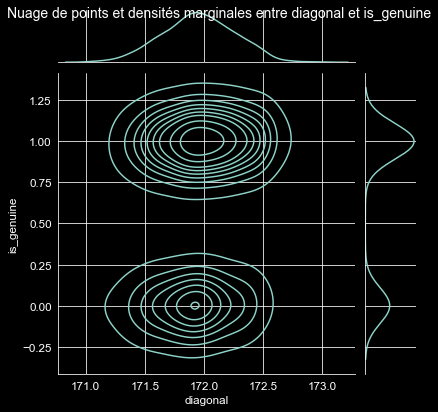

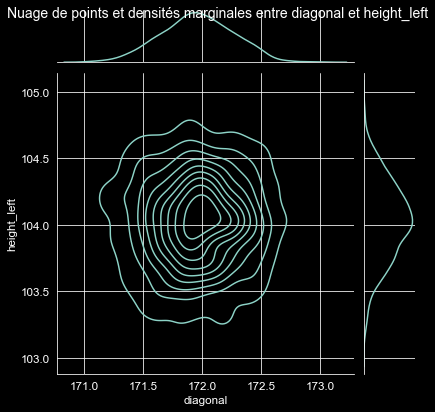

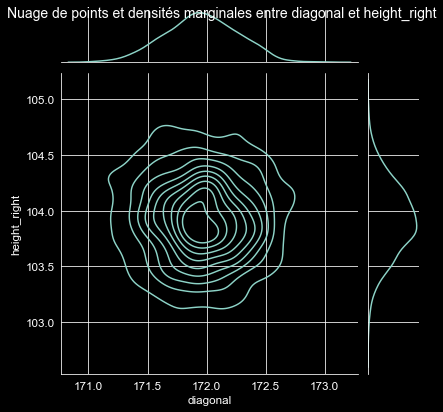

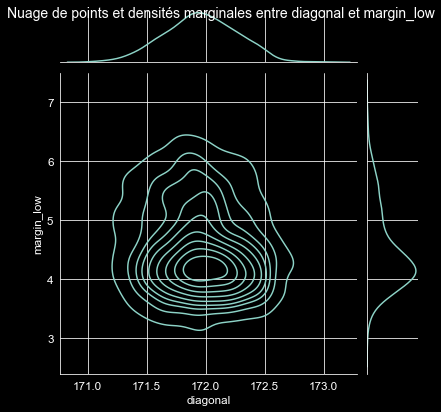

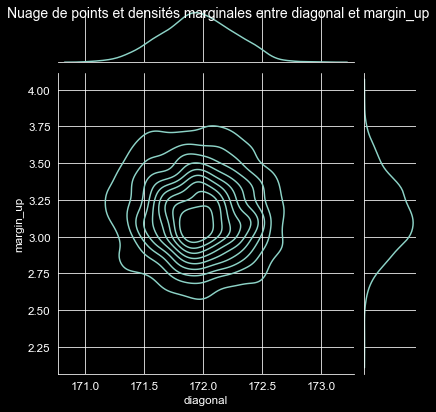

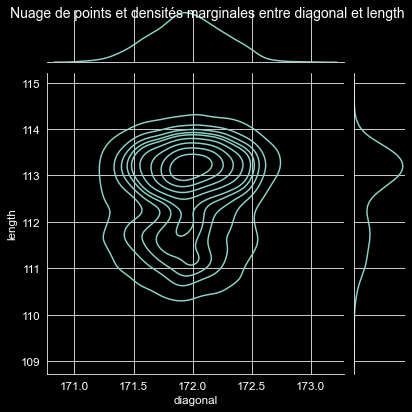

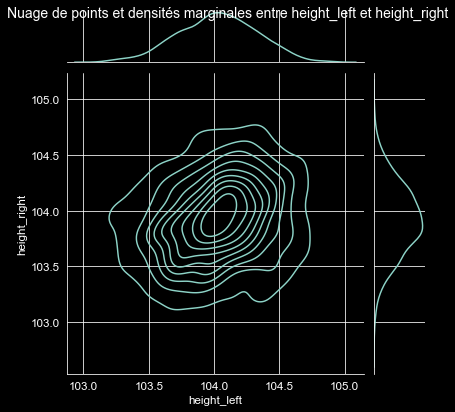

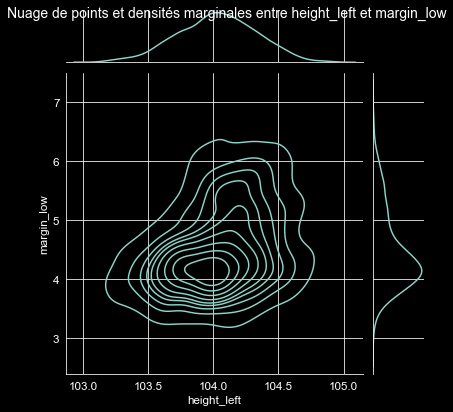

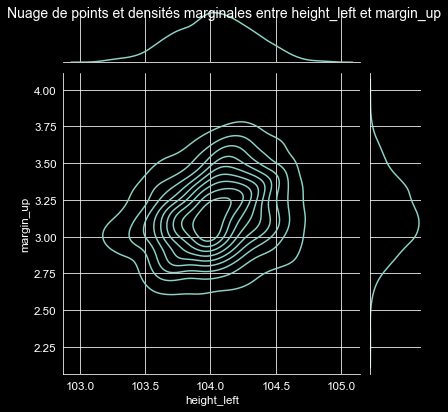

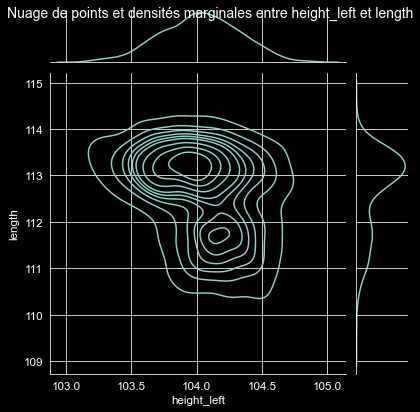

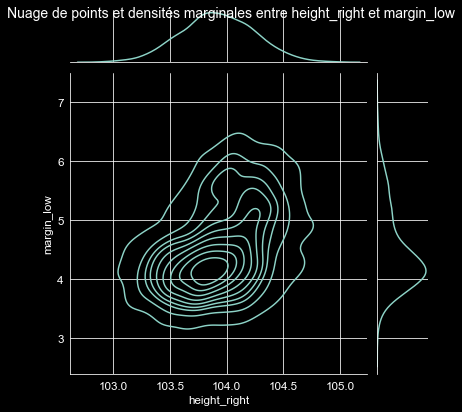

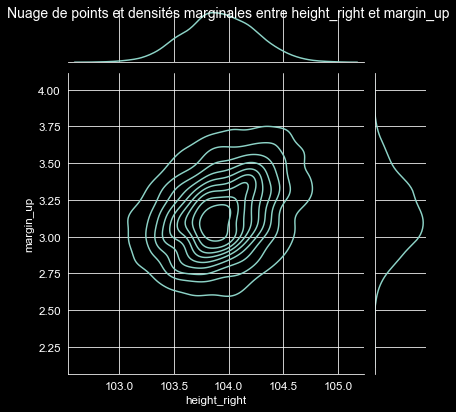

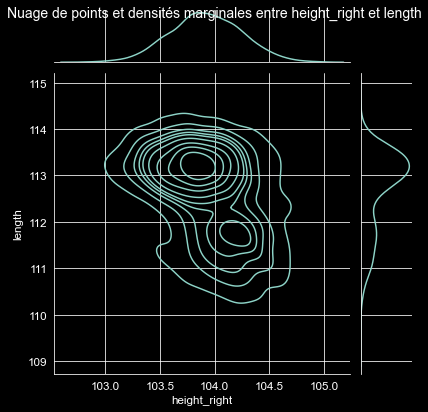

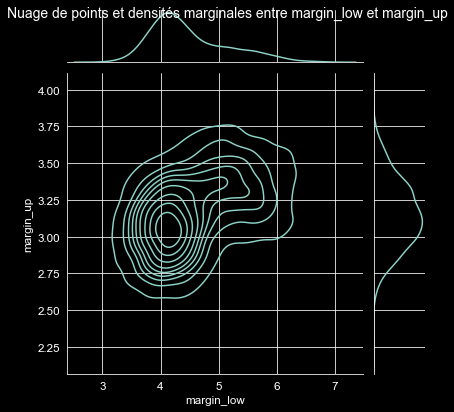

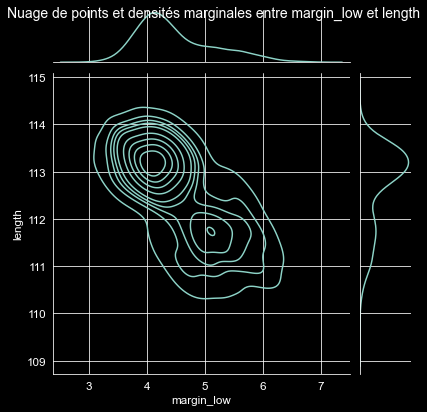

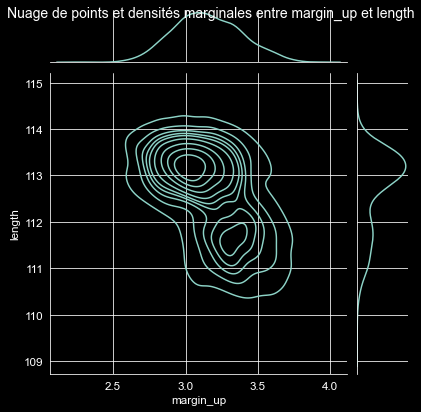

In [13]:
analyse_bivariee(df)

## <a id="section_2_4"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-size: 24px; font-weight: bold;">2.4 - Matrice de corrélation heatmap </span>
</div>

<div style="background-color: black; padding: 20px; font-size: min(16px, 2vw); color: white; font-family: Verdana, sans-serif; font-weight: bold; width: 100%; margin: 0; box-sizing: border-box;"> 
	<span style="font-size: min(28px, 3vw);"> 🔗 Relations entre variables </span><br><br>
	<ul>
		<li>🧮 Matrice de corrélation : `sns.heatmap(df.corr(), annot=True)` pour visualiser les corrélations entre toutes les variables numériques.</li><br>
	</ul>
</div>

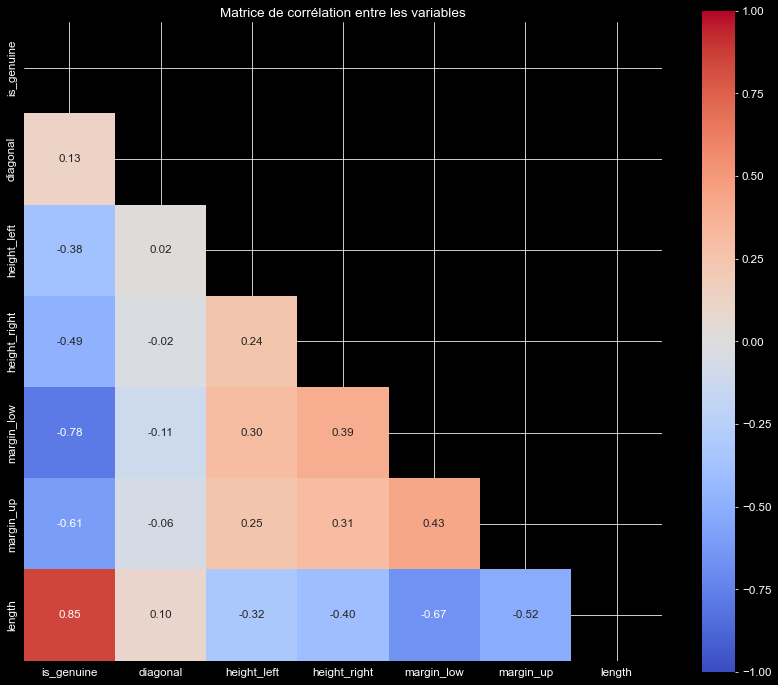

'\nPaires de variables fortement corrélées (|corr| > 0.6) :'

'is_genuine - length: 0.849'

'is_genuine - margin_low: -0.783'

'margin_low - length: -0.667'

'is_genuine - margin_up: -0.606'

In [14]:
# Création de la figure
plt.figure(figsize=(12, 10))

# Créer un masque pour le triangle inférieur
mask = np.triu(np.ones_like(df.corr()))

# Créer la heatmap avec le masque
sns.heatmap(df.corr(), 
			mask=mask,
			annot=True,
			cmap='coolwarm',
			center=0,
			vmin=-1,
			vmax=1,
			square=True,
			fmt='.2f')
plt.title('Matrice de corrélation entre les variables')
plt.tight_layout()
plt.show()

# Afficher les paires de variables fortement corrélées
display("\nPaires de variables fortement corrélées (|corr| > 0.6) :")

corr_matrix = df.corr()  # Garder les valeurs originales (pas abs())
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
strong_corrs = []

# Parcourir toutes les paires possibles
for i in range(len(upper.index)):
	for j in range(i + 1, len(upper.columns)):
		corr = upper.iloc[i, j]
		if corr is not None and abs(corr) > 0.6:  # Vérifier la valeur absolue
			strong_corrs.append((
				upper.index[i],
				upper.columns[j],
				corr  # Garder la valeur réelle de la corrélation
			))

# Trier par valeur absolue de corrélation
strong_corrs.sort(key=lambda x: abs(x[2]), reverse=True)

# Afficher les résultats
if strong_corrs:
	for var1, var2, corr in strong_corrs:
		display(f"{var1} - {var2}: {corr:.3f}")
else:
	display("Aucune paire de variables n'a de corrélation supérieure à 0.6 en valeur absolue")

## <a id="section_2_5"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-size: 24px; font-weight: bold;">2.5 - Comparaison des groupes de vrais et faux billets </span>
</div>

<div style="background-color: black; padding: 20px; font-size: min(16px, 2vw); color: white; font-family: Verdana, sans-serif; font-weight: bold; width: 100%; margin: 0; box-sizing: border-box;"> 
<span style="font-size: min(28px, 3vw); color: white; font-family: 'Lucida Console', Monaco, monospace; display: block; font-weight: bold; margin-bottom: 20px;"> 📊 Analyse statistique comparative des billets </span><br> 

- 📏 Variables analysées : `['diagonal', 'height_left', 'height_right', 'margin_up', 'margin_low', 'length']`<br> 

<br> 

○ 📊 ÉTAPE 1 - Visualisation : • Représentation graphique :<br> 
- Histogrammes avec courbes de densité (`sns.histplot(kde=True)`)
- Boxplots pour détecter les valeurs aberrantes (`sns.boxplot()`)<br> <br> 

○ 🔍 ÉTAPE 2 - Test de Shapiro-Wilk : <br><br>
 Objectif : Vérifie la normalité des distributions<br> 
- Hypothèse : H0 : La distribution suit une loi normale
- Décision : - Si p-value > 0.05 : distribution normale → Passer à l'étape 3
<span style="color: #DAA520">- Si p-value ≤ 0.05 : distribution non normale → Aller directement au Mann-Whitney U (étape 4)</span><br> <br> 

○ ⚖️ ÉTAPE 3 - Test de Levene : <br> <br>
 Objectif : Vérifie l'égalité des variances entre les deux groupes<br> 
- Hypothèse : H0 : Les variances sont égales
- Décision : - Si p-value > 0.05 : variances égales → T-test classique
<span style="color: #DAA520">- Si p-value ≤ 0.05 : variances inégales → Test de Welch</span><br> <br> 

○ 📈 ÉTAPE 4 - Tests statistiques comparatifs : <br> 
- T-test classique : si normalité + variances égales<br> 
- Test de Welch : si normalité + variances inégales<br> 
- Mann-Whitney U : si non normalité</span><br> <br> 

○ 📉 Interprétation des p-values : • Hypothèse : H0 : Pas de différence entre les groupes<br> 
- Décision : - p-value < 0.05 : différence significative (5% de risque de se tromper)
<span style="color: #DAA520">- p-value ≥ 0.05 : pas de différence significative</span><br> <br> 

</div>

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,84575.49,51260.76,51238.49,2566.24,1648.94,54923.00
True,167000.81,100937.08,100798.63,3996.73,2964.02,109920.17


,length,diagonal,height_left,height_right,margin_up,margin_low
is_genuine,,,,,,
False,54923.000,84575.490,51260.76,51238.490,1648.94,2566.240
True,54960.085,83500.405,50468.54,50399.315,1482.01,1998.365
diff en %,-0.070,1.270,1.55,1.640,10.12,22.130


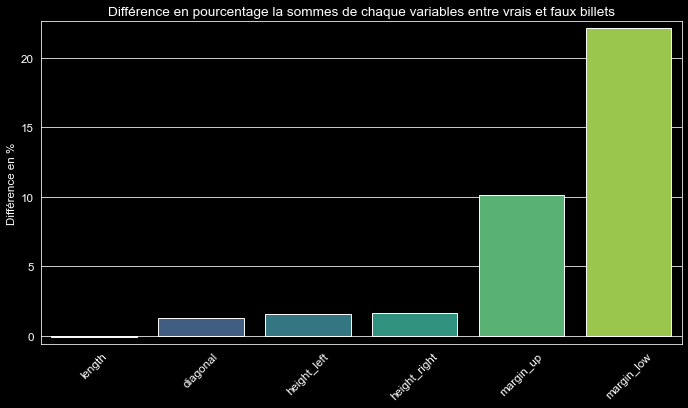

In [15]:
# - Différence en pourcentage la sommes de chaque variables entre vrais et faux billets

# Charger un fichier CSV en utilisant Dask
df_dask = dd.read_csv("billets.csv", sep=";")

# Supprime les valeurs manquantes de margin low et sépare les 2 groupes
result = df_dask[df_dask['margin_low'] > 0].groupby('is_genuine').sum().compute()

# Créer un nouveau DataFrame result2 avec la ligne 'True' divisée par 2 
result2 = result.copy()
result2.loc[True] = result2.loc[True] / 2

# Calculer le pourcentage de différence entre les 2 groupes
result2.loc['diff en %'] = round(((result.loc[False] - result2.loc[True]) / result.loc[False]) * 100, 2)

# Trier les colonnes en fonction de 'diff en %'
result2 = result2.loc[:, result2.loc['diff en %'].sort_values().index]

display(result)
display(result2)

# Créer un graphique pour la ligne 'diff en %'
plt.figure(figsize=(10, 6))
sns.barplot(x=result2.columns, y=result2.loc['diff en %'], palette='viridis')
plt.title("Différence en pourcentage la sommes de chaque variables entre vrais et faux billets")
plt.ylabel('Différence en %')
plt.xlabel('')
plt.xticks(rotation=45)
plt.ylim(min(result2.loc['diff en %']) - 0.5, max(result2.loc['diff en %']) + 0.5)  # Ajuster l'échelle de l'axe y
plt.tight_layout()
plt.show()

In [16]:
def compare_distributions(df):
	"""
	Compare les distributions de chaque variable numérique entre les vrais et les faux billets.

	Args:
	  df: DataFrame contenant les données.
	"""
	
	variables = ['diagonal', 'height_left', 'height_right', 'margin_up', 'margin_low', 'length']

	for var in variables:
		# Crée une nouvelle figure pour chaque variable
		plt.figure(figsize=(12, 4))

		# Affiche l'histogramme de la variable pour chaque groupe (vrais et faux billets)
		plt.subplot(1, 2, 1)
		sns.histplot(df[df['is_genuine'] == True][var], kde=True, color='blue', label='Vrais')
		sns.histplot(df[df['is_genuine'] == False][var], kde=True, color='red', label='Faux')
		plt.title(f'Distribution de {var} par type de billet')
		plt.xlabel(var)
		plt.ylabel('Fréquence')
		plt.legend()

		# Affiche le boxplot de la variable pour chaque groupe (vrais et faux billets)
		plt.subplot(1, 2, 2)
		sns.boxplot(x='is_genuine', y=var, data=df)
		plt.title(f'Boxplot de {var} par type de billet')
		plt.xlabel('Type de billet')
		plt.ylabel('Valeur (mm)')

		plt.tight_layout()
		plt.show()  # Affiche les graphiques ici

		# Sépare les données en deux groupes (vrais et faux billets) et supprime les valeurs manquantes
		genuine = df[df['is_genuine'] == True][var].dropna()
		fake = df[df['is_genuine'] == False][var].dropna()

		# Affichage des statistiques descriptives pour chaque groupe
		display(f"Stats des données {var}:")
		display(df.groupby('is_genuine')[var].describe())

		# Vérifie si la taille de chaque groupe est suffisante pour effectuer les tests statistiques
		if len(genuine) > 3 and len(fake) > 3:
			# Test de Shapiro-Wilk pour vérifier la normalité des distributions
			if stats.shapiro(genuine)[1] > 0.05 and stats.shapiro(fake)[1] > 0.05:
				# Test de Levene pour vérifier l'égalité des variances
				if stats.levene(genuine, fake)[1] > 0.05:
					# T-test classique si les variances sont égales
					test_stat, p_value = stats.ttest_ind(genuine, fake, equal_var=True)
					test_name = "t-test classique"
				else:
					# Welch t-test si les variances sont inégales
					test_stat, p_value = stats.ttest_ind(genuine, fake, equal_var=False)
					test_name = "Welch t-test"
			else:
				# Mann-Whitney U test si les distributions ne sont pas normales
				test_stat, p_value = stats.mannwhitneyu(genuine, fake)
				test_name = "Mann-Whitney U"

			display(f"Test statistique ({test_name}) pour {var}: p-value = {p_value:e}")
			display(f"- Différence {'significative' if p_value < 0.05 else 'non significative'} (seuil 5%)")
		else:
			display(f"Test statistique non effectué pour {var} : taille d'échantillon insuffisante.")

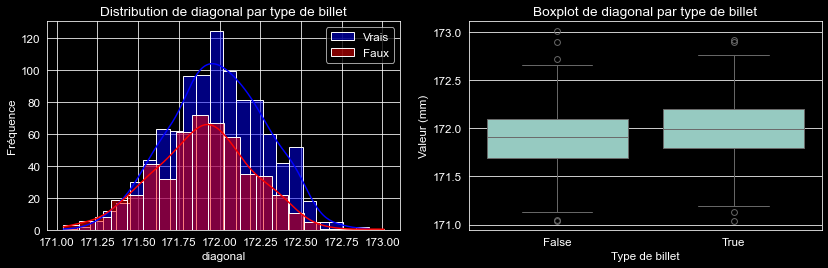

'Stats des données diagonal:'

,count,mean,std,min,25%,50%,75%,max
is_genuine,,,,,,,,
False,500.0,171.90116,0.306861,171.04,171.69,171.91,172.0925,173.01
True,1000.0,171.98708,0.300441,171.04,171.79,171.99,172.2000,172.92


'Test statistique (t-test classique) pour diagonal: p-value = 2.466867e-07'

'- Différence significative (seuil 5%)'

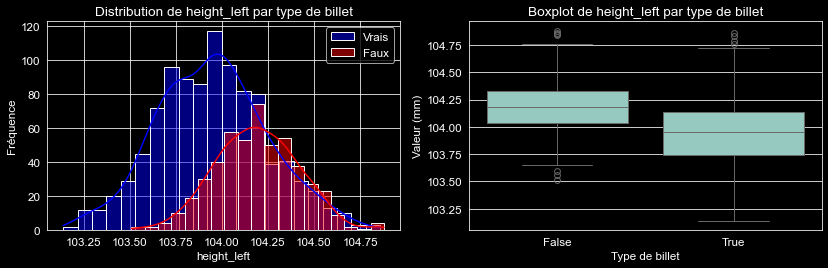

'Stats des données height_left:'

,count,mean,std,min,25%,50%,75%,max
is_genuine,,,,,,,,
False,500.0,104.19034,0.223758,103.51,104.04,104.18,104.3325,104.88
True,1000.0,103.94913,0.300231,103.14,103.74,103.95,104.1400,104.86


'Test statistique (Mann-Whitney U) pour height_left: p-value = 4.883939e-53'

'- Différence significative (seuil 5%)'

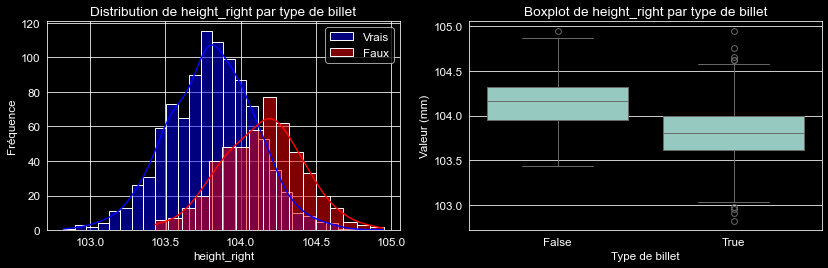

'Stats des données height_right:'

,count,mean,std,min,25%,50%,75%,max
is_genuine,,,,,,,,
False,500.0,104.14362,0.270878,103.43,103.95,104.16,104.32,104.95
True,1000.0,103.80865,0.291570,102.82,103.61,103.81,104.00,104.95


'Test statistique (t-test classique) pour height_right: p-value = 2.270856e-89'

'- Différence significative (seuil 5%)'

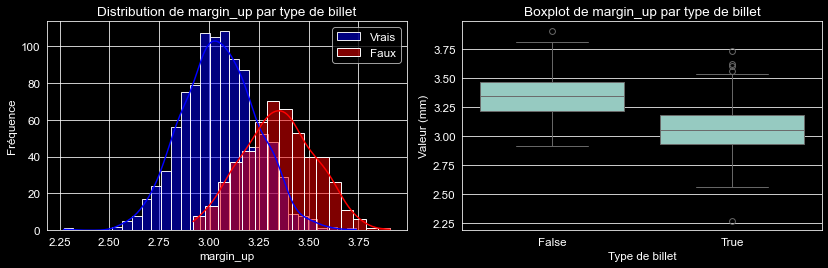

'Stats des données margin_up:'

,count,mean,std,min,25%,50%,75%,max
is_genuine,,,,,,,,
False,500.0,3.35016,0.180498,2.92,3.22,3.35,3.4725,3.91
True,1000.0,3.05213,0.186340,2.27,2.93,3.05,3.1800,3.74


'Test statistique (t-test classique) pour margin_up: p-value = 3.144530e-151'

'- Différence significative (seuil 5%)'

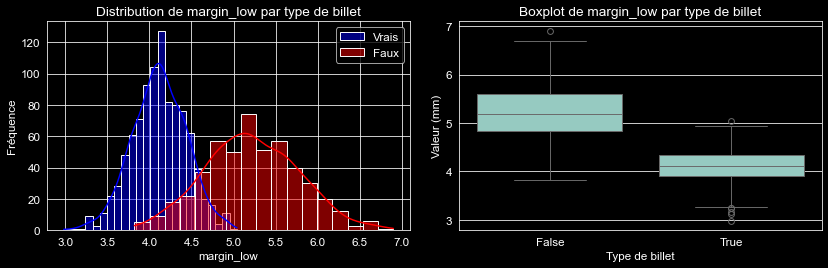

'Stats des données margin_low:'

,count,mean,std,min,25%,50%,75%,max
is_genuine,,,,,,,,
False,492.0,5.215935,0.553531,3.82,4.840,5.19,5.5925,6.90
True,971.0,4.116097,0.319124,2.98,3.905,4.11,4.3400,5.04


'Test statistique (Welch t-test) pour margin_low: p-value = 1.433175e-182'

'- Différence significative (seuil 5%)'

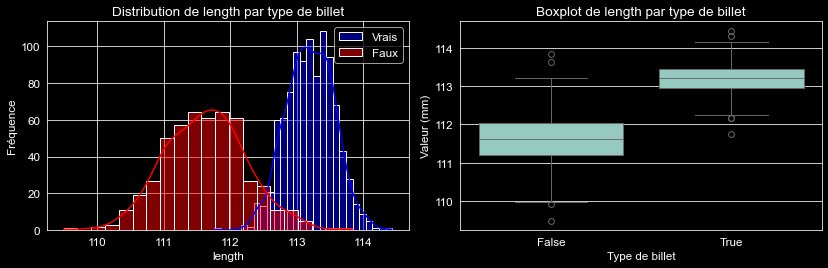

'Stats des données length:'

,count,mean,std,min,25%,50%,75%,max
is_genuine,,,,,,,,
False,500.0,111.63064,0.615543,109.49,111.20,111.630,112.03,113.85
True,1000.0,113.20243,0.359552,111.76,112.95,113.205,113.46,114.44


'Test statistique (Welch t-test) pour length: p-value = 1.469955e-241'

'- Différence significative (seuil 5%)'

In [17]:
compare_distributions(df)

<div style="background-color: black; padding: 20px; font-size: min(16px, 2vw); color: white; font-family: Verdana, sans-serif; font-weight: bold; width: 100%; margin: 0; box-sizing: border-box;">
	<span style="font-size: min(28px, 3vw);">📊 Conclusion</span>
	<br><br><br>
	<ul>
		<li>Les tests statistiques révèlent des différences significatives (p-value < 0.05) pour toutes les variables analysées</li><br><br>
		<li>Analyse détaillée :<br><br>
			<ul>
				<li>Les tests confirment que les distributions diffèrent entre vrais et faux billets</li><br>
				<li>La visualisation montre des caractéristiques distinctes entre les deux groupes</li><br>
				<li>Les boxplots révèlent des plages de valeurs différentes selon l'authenticité</li><br>
			</ul>
		</li>
		<li>Implications pratiques :<br><br>
			<ul>
				<li>Ces variables permettent de discriminer efficacement les vrais des faux billets</li><br>
				<li>La présence de différences significatives justifie leurs utilisations comme critères d'authentification</li><br>
			</ul>
		</li>
		<li>Point d'attention :<br><br>
			<ul>
				<li>Malgré les différences significatives, les distributions présentent quelques zones de chevauchement</li><br>
				<li>Une approche multi-critères est recommandée pour une authentification robuste</li><br>
			</ul>
		</li>
	</ul>
</div>

## <a id="section_2_6"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-size: 24px; font-weight: bold;">2.6 - Distribution des valeurs manquantes au sein des 2 groupes</span>
</div>

"Nombre de valeurs manquantes dans 'margin_low' pour les vrais billets: 29 (2.90%)"

"Nombre de valeurs manquantes dans 'margin_low' pour les faux billets: 8 (1.60%)"

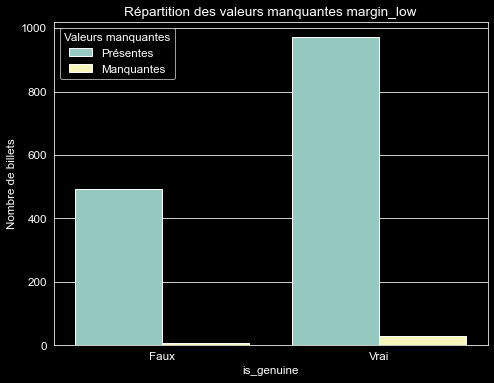

In [18]:
# Vérifier la répartition des valeurs manquantes dans 'margin_low' pour chaque groupe de 'is_genuine'
missing_genuine = df[df['is_genuine'] == True]['margin_low'].isnull().sum()
total_genuine = len(df[df['is_genuine'] == True])
percent_missing_genuine = (missing_genuine / total_genuine) * 100

missing_fake = df[df['is_genuine'] == False]['margin_low'].isnull().sum()
total_fake = len(df[df['is_genuine'] == False])
percent_missing_fake = (missing_fake / total_fake) * 100


display(f"Nombre de valeurs manquantes dans 'margin_low' pour les vrais billets: {missing_genuine} ({percent_missing_genuine:.2f}%)")
display(f"Nombre de valeurs manquantes dans 'margin_low' pour les faux billets: {missing_fake} ({percent_missing_fake:.2f}%)")


# Visualisation
plt.figure(figsize=(8, 6))
sns.countplot(x='is_genuine', hue='margin_low', data=df.assign(margin_low=df['margin_low'].isnull()))

# Modification de la légende
plt.legend(title='Valeurs manquantes', labels=['Présentes', 'Manquantes'])

plt.title('Répartition des valeurs manquantes margin_low')
plt.xlabel('is_genuine')
plt.ylabel('Nombre de billets')
plt.xticks([0, 1], ['Faux', 'Vrai'])
plt.show()

## <a id="section_2_7"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-size: 24px; font-weight: bold;">2.7 - Analyse des valeurs aberrantes à l'aide du Z-score</span>
</div>

In [19]:
# Affichage du titre de l'analyse
display(pd.DataFrame({'': ['=== ANALYSE DES VALEURS ABERRANTES (DataFrame original) ===']}).style.hide(axis='index'))

try:
	# Extraction des noms de colonnes (features)
	features = df.columns.tolist()

	# Initialisation du dictionnaire pour stocker les résultats par variable
	outliers_by_var = {}

	# Affichage du titre de l'analyse par variable
	display(pd.DataFrame({'': ['=== ANALYSE PAR VARIABLE ===']}).style.hide(axis='index'))

	# Boucle sur chaque variable (feature)
	for col in features:
		# Exclure la variable cible 'is_genuine' de l'analyse des valeurs aberrantes
		if col != 'is_genuine':
			# Calcul des z-scores pour chaque observation de la variable
			z_scores = np.abs(stats.zscore(df[col]))

			# Identification des valeurs aberrantes (z-score > 3)
			outliers_mask = z_scores > 3

			# Identification des valeurs aberrantes pour chaque type de billet
			auth_outliers = outliers_mask & (df['is_genuine'] == 1)  # Vrais positifs
			fake_outliers = outliers_mask & (df['is_genuine'] == 0)  # Faux positifs

			# Stockage du nombre total de valeurs aberrantes et leur répartition par type de billet
			outliers_by_var[col] = {
				'total': outliers_mask.sum(),
				'authentiques': auth_outliers.sum(),
				'contrefaits': fake_outliers.sum()
			}

			# Calcul des statistiques descriptives pour la variable (sans les valeurs aberrantes)
			var_stats = pd.DataFrame({
				'Métrique': [
					'Total valeurs aberrantes',
					'Dans billets authentiques',
					'Dans billets contrefaits',
					'Minimum (sans aberrants)',
					'Maximum (sans aberrants)',
					'Moyenne (sans aberrants)',
					'Écart-type (sans aberrants)'
				],
				'Valeur': [
					f"{outliers_mask.sum()} ({(outliers_mask.sum()/len(df)*100):.2f}%)",
					f"{auth_outliers.sum()} ({(auth_outliers.sum()/(df['is_genuine'] == 1).sum()*100):.2f}%)",
					f"{fake_outliers.sum()} ({(fake_outliers.sum()/(df['is_genuine'] == 0).sum()*100):.2f}%)",
					f"{df[~outliers_mask][col].min():.3f}",
					f"{df[~outliers_mask][col].max():.3f}",
					f"{df[~outliers_mask][col].mean():.3f}",
					f"{df[~outliers_mask][col].std():.3f}"
				]
			})

			# Affichage du nom de la variable en cours d'analyse
			display(pd.DataFrame({'': [f'=== VARIABLE : {col} ===']}).style.hide(axis='index'))
			# Affichage des statistiques descriptives
			display(var_stats.style.hide(axis='index'))

			# Affichage des 5 valeurs les plus aberrantes si des valeurs aberrantes sont détectées
			if outliers_mask.sum() > 0:
				display(pd.DataFrame({'': [f'Top 5 des valeurs aberrantes pour {col}']}).style.hide(axis='index'))
				extreme_vals = df[outliers_mask].copy()  # Copie des valeurs aberrantes
				extreme_vals['Z-score'] = z_scores[outliers_mask]  # Ajout du z-score
				extreme_vals['Type'] = extreme_vals['is_genuine'].map({1: 'Authentique', 0: 'Contrefait'}) # Mapping pour le type
				display(extreme_vals[[col, 'Z-score', 'Type']]
						.sort_values('Z-score', ascending=False)
						.head()
						.style.format({col: '{:.3f}', 'Z-score': '{:.3f}'})
						.hide(axis='index'))

	# Affichage du titre du résumé global
	display(pd.DataFrame({'': ['=== RÉSUMÉ GLOBAL DES VALEURS ABERRANTES ===']}).style.hide(axis='index'))

	# Identification de la variable la plus affectée par les valeurs aberrantes
	most_affected = max(outliers_by_var.items(), key=lambda x: x[1]['total'])

	# Création du tableau de résumé global
	summary = pd.DataFrame({
		'Aspect': [
			'Variable la plus affectée',
			'Répartition authentique/contrefait',
			'Impact sur la détection'
		],
		'Conclusion': [
			f"{most_affected[0]} ({most_affected[1]['total']} valeurs aberrantes)",
			f"Authentiques: {sum(v['authentiques'] for v in outliers_by_var.values())}, " \
			f"Contrefaits: {sum(v['contrefaits'] for v in outliers_by_var.values())}",
			"À utiliser comme indicateur potentiel de contrefaçon" if \
			sum(v['contrefaits'] for v in outliers_by_var.values()) > \
			sum(v['authentiques'] for v in outliers_by_var.values()) else \
			"Distribution équilibrée entre les types"
		]
	})

	# Affichage du résumé global
	display(summary.style.hide(axis='index'))

except Exception as e:
	# Gestion des erreurs et affichage du message d'erreur
	display(pd.DataFrame({'Erreur': [str(e)]}).style.hide(axis='index'))
	raise

""
=== ANALYSE DES VALEURS ABERRANTES (DataFrame original) ===


""
=== ANALYSE PAR VARIABLE ===


""
=== VARIABLE : diagonal ===


Métrique,Valeur
Total valeurs aberrantes,6 (0.40%)
Dans billets authentiques,3 (0.30%)
Dans billets contrefaits,3 (0.60%)
Minimum (sans aberrants),171.050
Maximum (sans aberrants),172.760
Moyenne (sans aberrants),171.957
Écart-type (sans aberrants),0.300


""
Top 5 des valeurs aberrantes pour diagonal


diagonal,Z-score,Type
173.010,3.447,nan
172.920,3.152,nan
172.890,3.053,nan
172.890,3.053,nan
171.040,3.010,nan


""
=== VARIABLE : height_left ===


Métrique,Valeur
Total valeurs aberrantes,0 (0.00%)
Dans billets authentiques,0 (0.00%)
Dans billets contrefaits,0 (0.00%)
Minimum (sans aberrants),103.140
Maximum (sans aberrants),104.880
Moyenne (sans aberrants),104.030
Écart-type (sans aberrants),0.299


""
=== VARIABLE : height_right ===


Métrique,Valeur
Total valeurs aberrantes,4 (0.27%)
Dans billets authentiques,3 (0.30%)
Dans billets contrefaits,1 (0.20%)
Minimum (sans aberrants),102.950
Maximum (sans aberrants),104.870
Moyenne (sans aberrants),103.920
Écart-type (sans aberrants),0.322


""
Top 5 des valeurs aberrantes pour height_right


height_right,Z-score,Type
102.820,3.380,nan
104.950,3.163,nan
104.950,3.163,nan
102.910,3.104,nan


""
=== VARIABLE : margin_low ===


Métrique,Valeur
Total valeurs aberrantes,0 (0.00%)
Dans billets authentiques,0 (0.00%)
Dans billets contrefaits,0 (0.00%)
Minimum (sans aberrants),2.980
Maximum (sans aberrants),6.900
Moyenne (sans aberrants),4.486
Écart-type (sans aberrants),0.664


""
=== VARIABLE : margin_up ===


Métrique,Valeur
Total valeurs aberrantes,2 (0.13%)
Dans billets authentiques,1 (0.10%)
Dans billets contrefaits,1 (0.20%)
Minimum (sans aberrants),2.560
Maximum (sans aberrants),3.810
Moyenne (sans aberrants),3.152
Écart-type (sans aberrants),0.230


""
Top 5 des valeurs aberrantes pour margin_up


margin_up,Z-score,Type
2.270,3.804,nan
3.910,3.273,nan


""
=== VARIABLE : length ===


Métrique,Valeur
Total valeurs aberrantes,3 (0.20%)
Dans billets authentiques,0 (0.00%)
Dans billets contrefaits,3 (0.60%)
Minimum (sans aberrants),110.220
Maximum (sans aberrants),114.440
Moyenne (sans aberrants),112.684
Écart-type (sans aberrants),0.864


""
Top 5 des valeurs aberrantes pour length


length,Z-score,Type
109.490,3.655,nan
109.930,3.150,nan
109.970,3.105,nan


""
=== RÉSUMÉ GLOBAL DES VALEURS ABERRANTES ===


Aspect,Conclusion
Variable la plus affectée,diagonal (6 valeurs aberrantes)
Répartition authentique/contrefait,"Authentiques: 7, Contrefaits: 8"
Impact sur la détection,À utiliser comme indicateur potentiel de contrefaçon


# <a id="chapter3"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #39FF14; font-family: 'Lucida Console', Monaco, monospace; font-size: 32px; font-weight: bold;">3 - TRAITEMENT DES VALEURS MANQUANTES</span>
</div>

## <a id="section_3_1"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-size: 24px; font-weight: bold;">3.1 - Imputations avec l'ensemble des variables explicatives</span>
</div>

## <a id="section_3_1"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-size: 24px; font-weight: bold;">3.1 - Imputations avec l'ensemble des variables explicatives</span>
</div>

In [20]:
class ImputationTracker:
	def __init__(self, features):
		"""Initialisation avec toutes les métriques nécessaires pour le suivi complet"""
		self.features = features
		self.metrics_history = {
			'phase': [],
			# Métriques de performance directes
			'r2': [],
			'rmse': [],
			'mae': [],
			'explained_variance': [],
			'max_error': [],
			# Métriques de validation croisée
			'r2_cv_mean': [],
			'r2_cv_std': [],
			'rmse_cv_mean': [],
			'rmse_cv_std': [],
			# Tests statistiques
			'dw_test': [],
			'het_pvalue': [],
			'shapiro_pvalue': [],
			# Intervalles de confiance
			'interval_coverage': [],
			'interval_width': [],
			# Métriques d'outliers
			'mad_score_mean': [],
			'z_score_mean': []
		}
		self.hypotheses_results = {}
		self.best_model = None
		self.models = {}
    
	def add_new_phase(self, phase_name, metrics):
		"""Ajoute ou met à jour une phase avec toutes les métriques"""
		if phase_name in self.metrics_history['phase']:
			idx = self.metrics_history['phase'].index(phase_name)
			for key in metrics:
				if key in self.metrics_history:
					self.metrics_history[key][idx] = metrics[key]
		else:
			self.metrics_history['phase'].append(phase_name)
			for key in self.metrics_history:
				if key != 'phase':
					self.metrics_history[key].append(metrics.get(key, None))

	def get_summary(self):
		"""Retourne un DataFrame avec l'historique complet des métriques"""
		summary = pd.DataFrame(self.metrics_history)
		hypotheses_df = pd.DataFrame(self.hypotheses_results, index=[0])
		return pd.concat([summary, hypotheses_df], axis=1)

	def record_initial_data(self, df):
		"""Enregistre les informations initiales du DataFrame"""
		self.initial_data_shape = df.shape
		self.initial_data_types = df.dtypes

	def record_hypotheses_results(self, **kwargs):
		"""Enregistre les résultats des tests d'hypothèses"""
		self.hypotheses_results.update(kwargs)

	def record_metrics(self, phase, model=None, **metrics):
		"""Enregistre les métriques pour une phase donnée"""
		if model:
			self.models[phase] = model
		self.add_new_phase(phase, metrics)

	def get_best_model(self):
		"""Retourne le meilleur modèle"""
		return self.best_model

	def select_best_model(self):
		"""Sélectionne le meilleur modèle en fonction du R² CV"""
		with_outliers_metrics = self.metrics_history.get("with_outliers", {})
		without_outliers_metrics = self.metrics_history.get("without_outliers", {})

		if (with_outliers_metrics.get("r2_cv", -np.inf) >
			without_outliers_metrics.get("r2_cv", -np.inf)):
			self.best_model = self.models.get("with_outliers")
		else:
			self.best_model = self.models.get("without_outliers")
		
		return self.best_model

def calculate_robust_intervals(model, X, y, alpha=0.05):
	"""Calcule des intervalles de confiance robustes"""
	y_pred = model.predict(X)
	residuals = y - y_pred
	
	n = len(X)
	if X.ndim == 1:
		X = X.reshape(-1, 1)

	h = np.diagonal(X.dot(np.linalg.inv(X.T.dot(X))).dot(X.T))
	sigma = np.sqrt(residuals**2 / (1 - h))
	
	t_value = stats.t.ppf(1 - alpha/2, n-X.shape[1])
	margin = t_value * sigma
	
	return pd.DataFrame({
		'prediction': y_pred,
		'lower_bound': y_pred - margin,
		'upper_bound': y_pred + margin,
		'std_error': sigma
	})

def etape1(df):
	"""
	Préparation des données analyse initiale
	"""
	# === Préparation initiale ===
	display(pd.DataFrame({'': ['=== PRÉPARATION DES DONNÉES ET ANALYSE INITIALE ===']}).style.hide(axis='index'))

	# Conversion Dask si nécessaire
	if hasattr(df, 'compute'):
		df = df.compute()

	# Préparation des variables
	df['is_genuine'] = df['is_genuine'].astype(int)
	df['margin_low_missing'] = df['margin_low'].isna().astype(int)

	# Séparation train/test avec stratification
	X_train, X_test, y_train, y_test = train_test_split(
		df.drop('margin_low', axis=1),
		df['margin_low'],
		test_size=0.10,
		random_state=42,
		stratify=df[['is_genuine', 'margin_low_missing']]
	)

	# Préparation des données finales
	X_train = X_train.drop('margin_low_missing', axis=1)
	X_test = X_test.drop('margin_low_missing', axis=1)
	features = X_train.columns

	# === Rapport de préparation des données ===
	results = []

	# 1. Dimensions des données
	results.append({
		'Section': 'Dimensions des données',
		'Description': 'X_train',
		'Valeur': f"{X_train.shape[0]} observations, {X_train.shape[1]} variables"
	})
	results.append({
		'Section': 'Dimensions des données',
		'Description': 'X_test',
		'Valeur': f"{X_test.shape[0]} observations, {X_test.shape[1]} variables"
	})

	# 2. Valeurs manquantes dans X
	results.append({
		'Section': 'Valeurs manquantes - Variables explicatives',
		'Description': '',
		'Valeur': ''
	})

	for col in X_train.columns:
		results.append({
			'Section': 'X_train - Valeurs manquantes',
			'Description': col,
			'Valeur': f"{X_train[col].isna().sum()} ({(X_train[col].isna().sum() / len(X_train) * 100):.1f}%)"
		})
	
	for col in X_test.columns:
		results.append({
			'Section': 'X_test - Valeurs manquantes',
			'Description': col,
			'Valeur': f"{X_test[col].isna().sum()} ({(X_test[col].isna().sum() / len(X_test) * 100):.1f}%)"
		})

	# 3. Valeurs manquantes dans y
	results.append({
		'Section': 'Valeurs manquantes - Variable cible',
		'Description': 'y_train',
		'Valeur': f"{y_train.isna().sum()} NaN ({(y_train.isna().sum() / len(y_train) * 100):.1f}%)"
	})
	results.append({
		'Section': 'Valeurs manquantes - Variable cible',
		'Description': 'y_test',
		'Valeur': f"{y_test.isna().sum()} NaN ({(y_test.isna().sum() / len(y_test) * 100):.1f}%)"
	})

	# 4. Distribution des classes
	train_genuine = X_train['is_genuine'].value_counts(normalize=True)
	test_genuine = X_test['is_genuine'].value_counts(normalize=True)

	results.append({
		'Section': 'Distribution des classes - Train',
		'Description': 'Authentique (1)',
		'Valeur': f"{train_genuine[1]:.1%} ({X_train['is_genuine'].value_counts()[1]} obs.)"
	})
	results.append({
		'Section': 'Distribution des classes - Train',
		'Description': 'Contrefait (0)',
		'Valeur': f"{train_genuine[0]:.1%} ({X_train['is_genuine'].value_counts()[0]} obs.)"
	})
	results.append({
		'Section': 'Distribution des classes - Test',
		'Description': 'Authentique (1)',
		'Valeur': f"{test_genuine[1]:.1%} ({X_test['is_genuine'].value_counts()[1]} obs.)"
	})
	results.append({
		'Section': 'Distribution des classes - Test',
		'Description': 'Contrefait (0)',
		'Valeur': f"{test_genuine[0]:.1%} ({X_test['is_genuine'].value_counts()[0]} obs.)"
	})

	# Affichage du rapport de préparation
	prep_df = pd.DataFrame(results)
	display(prep_df.style.hide(axis='index'))

	# === Analyse initiale et métriques ===
	display(pd.DataFrame({'': ['=== MÉTRIQUES INITIALES ===']}).style.hide(axis='index'))

	# Initialisation du tracker
	imputation_tracker = ImputationTracker(features)
	imputation_tracker.record_initial_data(df)

	# Préparation pour analyse initiale
	df_base = df.dropna(subset=['margin_low'])
	X_base = df_base.drop(['margin_low', 'margin_low_missing'], axis=1)
	y_base = df_base['margin_low']

	# Configuration de la validation croisée
	cv = KFold(n_splits=10, shuffle=True, random_state=42)

	# Calcul des métriques CV
	cv_r2_scores = cross_val_score(LinearRegression(), X_base, y_base, cv=cv, scoring='r2')
	cv_rmse_scores = np.sqrt(-cross_val_score(LinearRegression(), X_base, y_base, 
			cv=cv, scoring='neg_mean_squared_error'))

	# Modèle initial et prédictions
	base_model = LinearRegression()
	base_model.fit(X_base, y_base)
	y_pred_base = base_model.predict(X_base)

	# Calcul des résidus
	residuals = y_base - y_pred_base
	X_stats = sm.add_constant(X_base)

	# Tests statistiques
	dw_test = durbin_watson(residuals)
	_, het_pvalue, _, _ = het_breuschpagan(residuals, X_stats)
	_, shapiro_pvalue = stats.shapiro(residuals)

	# Analyses des outliers
	z_scores = np.abs(stats.zscore(residuals))
	mad_scores = np.abs(residuals - np.median(residuals)) / stats.median_abs_deviation(residuals)

	# Intervalles de confiance
	base_intervals = calculate_robust_intervals(base_model, X_base.values, y_base)

	# Enregistrement des métriques initiales
	initial_metrics = {
		# Métriques de performance directes
		'r2': r2_score(y_base, y_pred_base),
		'rmse': np.sqrt(mean_squared_error(y_base, y_pred_base)),
		'mae': mean_absolute_error(y_base, y_pred_base),
		'explained_variance': explained_variance_score(y_base, y_pred_base),
		'max_error': max_error(y_base, y_pred_base),
		# Métriques de validation croisée
		'r2_cv_mean': cv_r2_scores.mean(),
		'r2_cv_std': cv_r2_scores.std(),
		'rmse_cv_mean': cv_rmse_scores.mean(),
		'rmse_cv_std': cv_rmse_scores.std(),
		# Tests statistiques
		'dw_test': dw_test,
		'het_pvalue': het_pvalue,
		'shapiro_pvalue': shapiro_pvalue,
		# Intervalles de confiance
		'interval_coverage': np.mean(
			(y_base >= base_intervals['lower_bound']) &
			(y_base <= base_intervals['upper_bound'])
		),
		'interval_width': np.mean(
			base_intervals['upper_bound'] - base_intervals['lower_bound']
		),
		# Métriques d'outliers
		'mad_score_mean': np.mean(mad_scores),
		'z_score_mean': np.mean(z_scores)
	}

	# Enregistrement dans le tracker
	imputation_tracker.add_new_phase('initial', initial_metrics)
	imputation_tracker.record_metrics('initial', base_model, **initial_metrics)

	# Création du DataFrame de résultats avec interprétations
	results_df = pd.DataFrame({
		'Métrique': [
			'R² direct',
			'R² CV (moyenne ± écart-type)',
			'RMSE direct',
			'RMSE CV (moyenne ± écart-type)',
			'MAE',
			'Variance expliquée',
			'Erreur maximale',
			'Test Durbin-Watson',
			'P-value hétéroscédasticité',
			'P-value normalité',
			'Couverture des intervalles',
			'Largeur moyenne des intervalles',
			'Score MAD moyen',
			'Score Z moyen'
		],
		'Valeur': [
			f"{initial_metrics['r2']:.4f}",
			f"{initial_metrics['r2_cv_mean']:.4f} ± {initial_metrics['r2_cv_std']:.4f}",
			f"{initial_metrics['rmse']:.4f}",
			f"{initial_metrics['rmse_cv_mean']:.4f} ± {initial_metrics['rmse_cv_std']:.4f}",
			f"{initial_metrics['mae']:.4f}",
			f"{initial_metrics['explained_variance']:.4f}",
			f"{initial_metrics['max_error']:.4f}",
			f"{initial_metrics['dw_test']:.4f}",
			f"{initial_metrics['het_pvalue']:.2e}",
			f"{initial_metrics['shapiro_pvalue']:.2e}",
			f"{initial_metrics['interval_coverage']:.2%}",
			f"{initial_metrics['interval_width']:.4f}",
			f"{initial_metrics['mad_score_mean']:.4f}",
			f"{initial_metrics['z_score_mean']:.4f}"
		],
		'Interprétation': [
			'Qualité d\'ajustement directe',
			'Performance moyenne et stabilité (CV)',
			'Erreur quadratique moyenne directe',
			'RMSE moyen et stabilité (CV)',
			'Erreur absolue moyenne',
			'Variance expliquée par le modèle',
			'Plus grande erreur observée',
			'Indépendant' if 1.5 < initial_metrics['dw_test'] < 2.5 else 'Dépendant',
			'Homoscédastique' if initial_metrics['het_pvalue'] > 0.05 else 'Hétéroscédastique',
			'Normal' if initial_metrics['shapiro_pvalue'] > 0.05 else 'Non normal',
			'Proportion dans les intervalles',
			'Précision des estimations',
			'Dispersion robuste (MAD)',
			'Dispersion (Z-score)'
		]
	})

	# Affichage des résultats
	display(results_df.style.hide(axis='index'))

	return X_train, X_test, y_train, y_test, imputation_tracker

if __name__ == "__main__":
	# Exemple d'utilisation
	X_train, X_test, y_train, y_test, tracker = etape1(df)
	
	# Récupération du résumé complet
	summary_df = tracker.get_summary()

""
=== PRÉPARATION DES DONNÉES ET ANALYSE INITIALE ===


Section,Description,Valeur
Dimensions des données,X_train,"1350 observations, 6 variables"
Dimensions des données,X_test,"150 observations, 6 variables"
Valeurs manquantes - Variables explicatives,,
X_train - Valeurs manquantes,is_genuine,0 (0.0%)
X_train - Valeurs manquantes,diagonal,0 (0.0%)
X_train - Valeurs manquantes,height_left,0 (0.0%)
X_train - Valeurs manquantes,height_right,0 (0.0%)
X_train - Valeurs manquantes,margin_up,0 (0.0%)
X_train - Valeurs manquantes,length,0 (0.0%)
X_test - Valeurs manquantes,is_genuine,0 (0.0%)


""
=== MÉTRIQUES INITIALES ===


Métrique,Valeur,Interprétation
R² direct,0.6169,Qualité d'ajustement directe
R² CV (moyenne ± écart-type),0.6069 ± 0.0489,Performance moyenne et stabilité (CV)
RMSE direct,0.4107,Erreur quadratique moyenne directe
RMSE CV (moyenne ± écart-type),0.4118 ± 0.0289,RMSE moyen et stabilité (CV)
MAE,0.3158,Erreur absolue moyenne
Variance expliquée,0.6169,Variance expliquée par le modèle
Erreur maximale,1.6882,Plus grande erreur observée
Test Durbin-Watson,2.0385,Indépendant
P-value hétéroscédasticité,3.46e-33,Hétéroscédastique
P-value normalité,7.06e-06,Non normal


""
=== VÉRIFICATION DES HYPOTHÈSES DE LA RÉGRESSION LINÉAIRE ===


""
=== TEST DE LINÉARITÉ ===


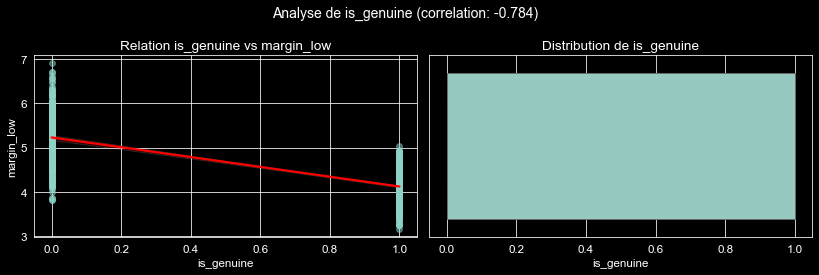

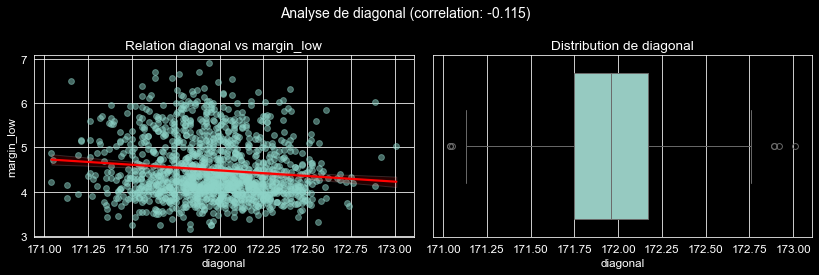

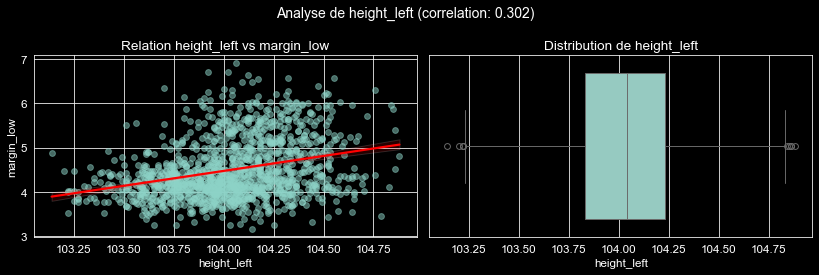

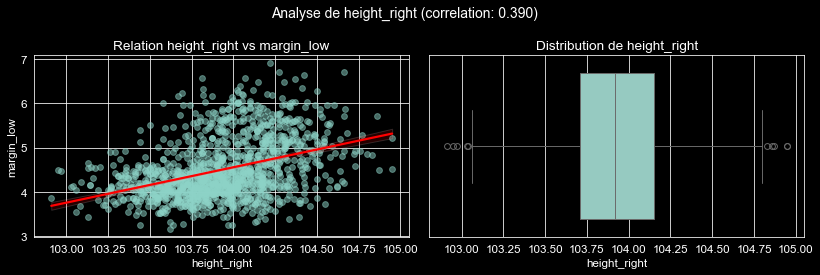

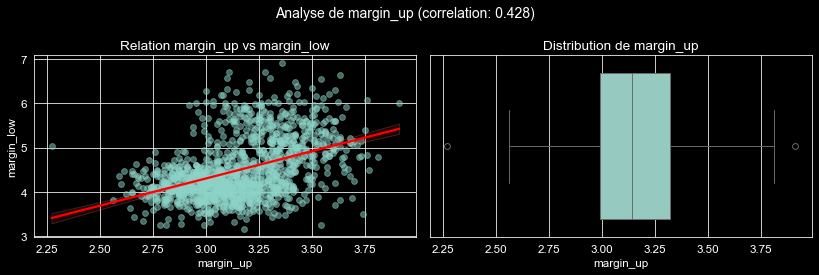

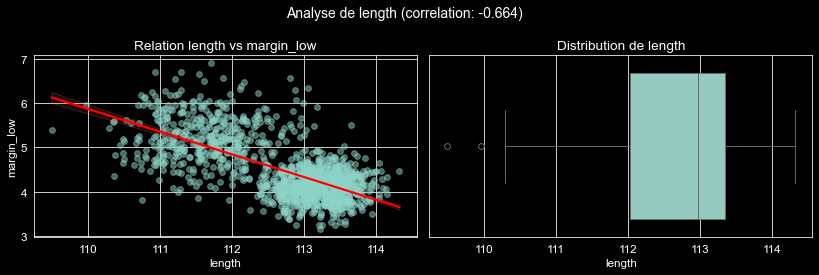

""
=== TEST DE DURBIN-WATSON ===


Test,Statistique,Interprétation
Durbin-Watson,1.997567,Indépendant


""
=== TEST D'HOMOSCÉDASTICITÉ ===


Test,P-value,Interprétation
Breusch-Pagan,5.52e-32,Hétéroscédastique


""
=== TEST DE NORMALITÉ DES RÉSIDUS ===


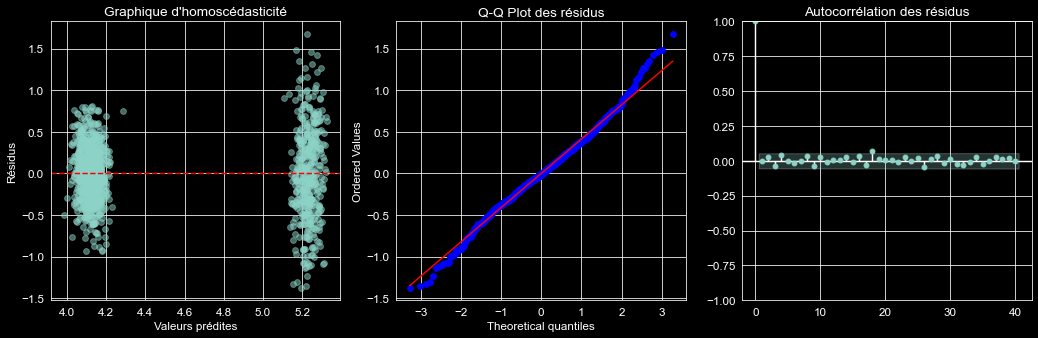

Test,Statistique,P-valeur,Interprétation
Shapiro-Wilk,0.993250,0.000010,Non normal


""
=== TEST DE MULTICOLINÉARITÉ ===


Variable,VIF,Interprétation
diagonal,172777.440602,Très élevée
height_left,119772.157146,Très élevée
height_right,113548.896398,Très élevée
length,54686.326486,Très élevée
margin_up,292.488517,Très élevée
is_genuine,13.816818,Très élevée


""
=== ANALYSE DES RÉSIDUS ABERRANTS ===


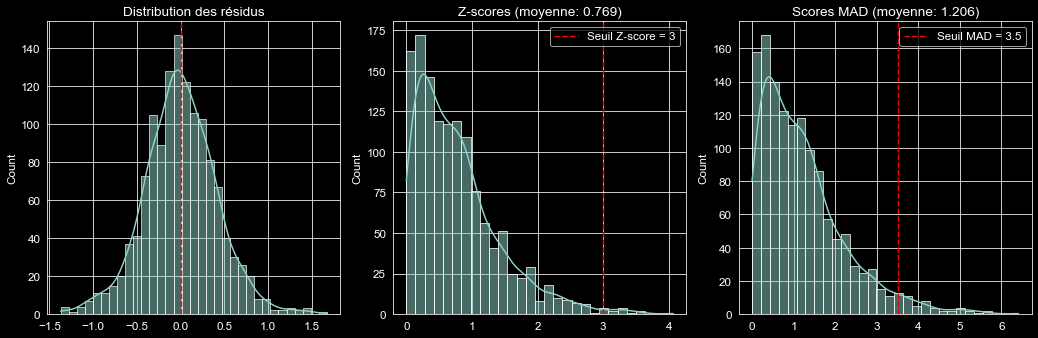

""
=== RÉSUMÉ GLOBAL ===


Hypothèse,Test,Résultat,Validée
Linéarité,Visuel,À vérifier,Vérifier visuellement
Indépendance,Durbin-Watson,1.998,Oui
Homoscédasticité,Breusch-Pagan,5.520e-32,Non
Normalité,Shapiro-Wilk,1.043e-05,Non
Non-multicolinéarité,VIF,Max: 172777.441,Voir les VIF
Outliers,Z-score & MAD,"Z-score > 3: 0.9%, MAD > 3.5: 3.6%",Outliers potentiels: 2.3%


In [21]:
# 2 - Vérification des hypothèses de la régression linéaire
display(pd.DataFrame({'': ['=== VÉRIFICATION DES HYPOTHÈSES DE LA RÉGRESSION LINÉAIRE ===']}).style.hide(axis='index'))

try:
    # Conversion et préparation des données
    X_train_stats = X_train.astype(float)
    y_train_stats = y_train.astype(float)

    # Nettoyage des valeurs manquantes pour l'analyse statistique
    mask_stats = ~(X_train_stats.isna().any(axis=1) | y_train_stats.isna())
    X_train_stats = X_train_stats[mask_stats]
    y_train_stats = y_train_stats[mask_stats]

    # 1. Test de linéarité
    display(pd.DataFrame({'': ['=== TEST DE LINÉARITÉ ===']}).style.hide(axis='index'))
    
    for col in X_train_stats.columns:
        plt.figure(figsize=(12, 4))
        
        # Relation avec la variable cible
        plt.subplot(121)
        sns.regplot(x=X_train_stats[col], y=y_train_stats, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
        plt.title(f'Relation {col} vs {y_train_stats.name}')
        
        # Distribution des valeurs
        plt.subplot(122)
        sns.boxplot(x=X_train_stats[col])
        plt.title(f'Distribution de {col}')
        
        corr = np.corrcoef(X_train_stats[col], y_train_stats)[0,1]
        plt.suptitle(f'Analyse de {col} (correlation: {corr:.3f})')
        plt.tight_layout()
        plt.show()

    # Création du modèle préliminaire pour les résidus
    X_const = sm.add_constant(X_train_stats)
    model_prelim = sm.OLS(y_train_stats, X_const).fit()
    residuals = model_prelim.resid

    # Nettoyage des données pour les tests
    valid_fitted = model_prelim.fittedvalues[~np.isnan(model_prelim.fittedvalues)]
    valid_residuals = residuals[~np.isnan(residuals)]
    valid_X = X_train_stats.dropna()

    # 2. Test d'indépendance (Durbin-Watson)
    display(pd.DataFrame({'': ['=== TEST DE DURBIN-WATSON ===']}).style.hide(axis='index'))
    
    dw_test = durbin_watson(residuals)
    display(pd.DataFrame({
        'Test': ['Durbin-Watson'],
        'Statistique': [dw_test],
        'Interprétation': ['Indépendant' if 1.5 < dw_test < 2.5 else 'Dépendant']
    }).style.hide(axis='index'))

    # 3. Test d'homoscédasticité
    display(pd.DataFrame({'': ['=== TEST D\'HOMOSCÉDASTICITÉ ===']}).style.hide(axis='index'))

    # Test de Breusch-Pagan
    try:
        _, het_p_value, _, _ = het_breuschpagan(valid_residuals, sm.add_constant(valid_X))
        df_bp = pd.DataFrame({
            'Test': ['Breusch-Pagan'],
            'P-value': [het_p_value],
            'Interprétation': ['Homoscédastique' if het_p_value > 0.05 else 'Hétéroscédastique']
        })
        display(df_bp.style.format({'P-value': '{:.2e}'}).hide(axis='index'))
    except:
        display("Impossible de calculer le test de Breusch-Pagan")

    # 4. Test de normalité des résidus
    display(pd.DataFrame({'': ['=== TEST DE NORMALITÉ DES RÉSIDUS ===']}).style.hide(axis='index'))
    
    # Graphiques combinés (QQ plot, homoscédasticité, autocorrélation)
    plt.figure(figsize=(15, 5))

    # Homoscédasticité
    plt.subplot(131)
    plt.scatter(valid_fitted, valid_residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Valeurs prédites')
    plt.ylabel('Résidus')
    plt.title('Graphique d\'homoscédasticité')

    # Q-Q plot
    plt.subplot(132)
    stats.probplot(valid_residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot des résidus")

    # Autocorrélation
    plt.subplot(133)
    sm.graphics.tsa.plot_acf(valid_residuals, lags=40, alpha=0.05, ax=plt.gca())
    plt.title('Autocorrélation des résidus')

    plt.tight_layout()
    plt.show()

    # Test de Shapiro-Wilk
    if len(valid_residuals) >= 3:
        shapiro_stat, shapiro_p = stats.shapiro(valid_residuals)
        display(pd.DataFrame({
            'Test': ['Shapiro-Wilk'],
            'Statistique': [shapiro_stat],
            'P-valeur': [shapiro_p],
            'Interprétation': ['Normal' if shapiro_p > 0.05 else 'Non normal']
        }).style.hide(axis='index'))

    # 5. Test de multicolinéarité
    display(pd.DataFrame({'': ['=== TEST DE MULTICOLINÉARITÉ ===']}).style.hide(axis='index'))
    
    if X_train_stats.shape[1] > 0 and not valid_X.empty:
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X_train_stats.columns
        vif_data["VIF"] = [variance_inflation_factor(X_train_stats.values, i)
            for i in range(X_train_stats.shape[1])]
        
        # Ajout de l'interprétation des VIF
        vif_data['Interprétation'] = pd.cut(
            vif_data['VIF'],
            bins=[0, 2, 5, 10, float('inf')],
            labels=['Faible', 'Modérée', 'Élevée', 'Très élevée']
        )
        display(vif_data.sort_values('VIF', ascending=False).style.hide(axis='index'))

    # 6. Analyse des résidus aberrants
    display(pd.DataFrame({'': ['=== ANALYSE DES RÉSIDUS ABERRANTS ===']}).style.hide(axis='index'))
    
    # Calcul des Z-scores et MAD scores des résidus
    z_scores = np.abs(stats.zscore(valid_residuals))
    mad_scores = np.abs(residuals - np.median(residuals)) / stats.median_abs_deviation(residuals)
    
    plt.figure(figsize=(15, 5))
    
    # Distribution des résidus
    plt.subplot(131)
    sns.histplot(residuals, kde=True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title('Distribution des résidus')
    
    # Z-scores
    plt.subplot(132)
    sns.histplot(z_scores, kde=True)
    plt.axvline(x=3, color='r', linestyle='--', label='Seuil Z-score = 3')
    plt.title(f'Z-scores (moyenne: {np.mean(z_scores):.3f})')
    plt.legend()
    
    # MAD scores
    plt.subplot(133)
    sns.histplot(mad_scores, kde=True)
    plt.axvline(x=3.5, color='r', linestyle='--', label='Seuil MAD = 3.5')
    plt.title(f'Scores MAD (moyenne: {np.mean(mad_scores):.3f})')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # 7. Résumé global
    display(pd.DataFrame({'': ['=== RÉSUMÉ GLOBAL ===']}).style.hide(axis='index'))

    hypotheses_summary = pd.DataFrame({
        'Hypothèse': [
            'Linéarité',
            'Indépendance',
            'Homoscédasticité',
            'Normalité',
            'Non-multicolinéarité',
            'Outliers'
        ],
        'Test': [
            'Visuel',
            'Durbin-Watson',
            'Breusch-Pagan',
            'Shapiro-Wilk',
            'VIF',
            'Z-score & MAD'
        ],
        'Résultat': [
            'À vérifier',
            f"{dw_test:.3f}",
            f"{het_p_value:.3e}",
            f"{shapiro_p:.3e}",
            f"Max: {vif_data['VIF'].max():.3f}",
            f"Z-score > 3: {((z_scores > 3).mean())*100:.1f}%, MAD > 3.5: {((mad_scores > 3.5).mean())*100:.1f}%"
        ],
        'Validée': [
            'Vérifier visuellement',
            'Oui' if 1.5 < dw_test < 2.5 else 'Non',
            'Oui' if het_p_value > 0.05 else 'Non',
            'Oui' if shapiro_p > 0.05 else 'Non',
            'Voir les VIF',
            f"Outliers potentiels: {((z_scores > 3).mean() + (mad_scores > 3.5).mean())/2*100:.1f}%"
        ]
    })
    display(hypotheses_summary.style.hide(axis='index'))

except Exception as e:
    display(pd.DataFrame({'Erreur': [str(e)]}).style.hide(axis='index'))
    raise

In [22]:
# 3 Optimisation et entraînement du modèle sur les données du train set
def get_optimal_splits(n_samples):
    """
    Détermine le nombre optimal de plis pour la validation croisée en fonction du nombre d'échantillons.
    """
    if n_samples < 1000:
        return 5
    elif n_samples < 10000:
        return 10
    else:
        return 20

def train_and_evaluate_model(X, y, title=""):
    """
    Entraîne et évalue un modèle.
    """
    # Configuration du pipeline
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('model', LinearRegression())
    ])

    # Paramètres pour GridSearchCV
    param_grid = {
        'scaler__quantile_range': [(25.0, 75.0), (10.0, 90.0), (5.0, 95.0)],
        'model__fit_intercept': [True, False],
        'model__positive': [False, True],
        'model': [LinearRegression(), Ridge(), Lasso()]
    }

    # Configuration de la validation croisée
    n_splits = get_optimal_splits(len(X))
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Configuration et entraînement GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring={'r2': 'r2', 'neg_mae': 'neg_mean_absolute_error'},
        cv=cv,
        return_train_score=True,
        refit='neg_mae',
        verbose=1
    )
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    # Calcul des prédictions
    y_pred = best_model.predict(X)
    residuals = y - y_pred
    
    # Calcul des métriques principales
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    mae = mean_absolute_error(y, y_pred)
    explained_var = explained_variance_score(y, y_pred)
    max_err = max_error(y, y_pred)

    # Validation croisée
    cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring='r2')

    return {
        'model': best_model,
        'r2': r2,
        'r2_cv_mean': cv_scores.mean(),
        'r2_cv_std': cv_scores.std(),
        'rmse': rmse,
        'mae': mae,
        'explained_variance': explained_var,
        'max_error': max_err,
        'params': grid_search.best_params_
    }

# === OPTIMISATION ET ENTRAÎNEMENT ===
display(pd.DataFrame({'': ['=== OPTIMISATION ET ENTRAÎNEMENT ===']}).style.hide(axis='index'))

# Nettoyage initial des données
display(pd.DataFrame({'': ["=== NETTOYAGE INITIAL DES DONNÉES ==="]}).style.hide(axis='index'))
display(pd.DataFrame({
    'Caractéristique': ['Shape initial X_train', 'Shape initial y_train'],
    'Valeur': [str(X_train.shape), str(y_train.shape)]
}).style.hide(axis='index'))

# Copie et nettoyage minimal des données
X_train_clean = X_train.copy()
y_train_clean = y_train.copy()

# Alignement des index
common_index = X_train_clean.index.intersection(y_train_clean.index)
X_train_clean = X_train_clean.loc[common_index]
y_train_clean = y_train_clean.loc[common_index]

# Retrait des NaN
mask = ~(X_train_clean.isna().any(axis=1) | y_train_clean.isna())
X_train_clean = X_train_clean[mask]
y_train_clean = y_train_clean[mask]

display(pd.DataFrame({'': ["=== ENTRAÎNEMENT AVEC TOUTES LES DONNÉES ==="]}).style.hide(axis='index'))
results_with_outliers = train_and_evaluate_model(X_train_clean, y_train_clean)

# Enregistrement des métriques avec outliers
tracker.record_metrics(
    'with_outliers',
    results_with_outliers['model'],
    r2=results_with_outliers['r2'],
    r2_cv_mean=results_with_outliers['r2_cv_mean'],
    r2_cv_std=results_with_outliers['r2_cv_std'],
    rmse=results_with_outliers['rmse'],
    mae=results_with_outliers['mae'],
    explained_variance=results_with_outliers['explained_variance'],
    max_error=results_with_outliers['max_error']
)

# Identification des valeurs aberrantes
residuals = y_train_clean - results_with_outliers['model'].predict(X_train_clean)
z_scores = np.abs(stats.zscore(residuals))
outliers_mask = z_scores > 3

# Création du jeu de données sans outliers
X_train_no_outliers = X_train_clean[~outliers_mask]
y_train_no_outliers = y_train_clean[~outliers_mask]

display(pd.DataFrame({'': ['=== ANALYSE DES VALEURS ABERRANTES ===']}).style.hide(axis='index'))
display(pd.DataFrame({
    'Caractéristique': [
        'Nombre total de valeurs aberrantes',
        'Pourcentage de valeurs aberrantes',
        'Nombre d\'observations restantes'
    ],
    'Valeur': [
        f"{outliers_mask.sum()}",
        f"{(outliers_mask.sum() / len(X_train_clean) * 100):.2f}%",
        f"{len(X_train_no_outliers)}"
    ]
}).style.hide(axis='index'))

display(pd.DataFrame({'': ["=== ENTRAÎNEMENT SANS VALEURS ABERRANTES ==="]}).style.hide(axis='index'))
results_without_outliers = train_and_evaluate_model(X_train_no_outliers, y_train_no_outliers)

# Enregistrement des métriques sans outliers
tracker.record_metrics(
    'without_outliers',
    results_without_outliers['model'],
    r2=results_without_outliers['r2'],
    r2_cv_mean=results_without_outliers['r2_cv_mean'],
    r2_cv_std=results_without_outliers['r2_cv_std'],
    rmse=results_without_outliers['rmse'],
    mae=results_without_outliers['mae'],
    explained_variance=results_without_outliers['explained_variance'],
    max_error=results_without_outliers['max_error']
)

# Comparaison des performances
display(pd.DataFrame({'': ["=== COMPARAISON DES PERFORMANCES ==="]}).style.hide(axis='index'))

comparison = pd.DataFrame({
    'Métrique': [
        'R² (ensemble complet)',
        'R² validation croisée',
        'Intervalle de confiance R² (95%)',
        'RMSE',
        'MAE',
        'Variance expliquée',
        'Erreur maximale',
        'Nombre d\'observations'
    ],
    'Avec outliers': [
        f"{results_with_outliers['r2']:.4f}",
        f"{results_with_outliers['r2_cv_mean']:.4f}",
        f"[{results_with_outliers['r2_cv_mean'] - 2*results_with_outliers['r2_cv_std']:.4f}, "
        f"{results_with_outliers['r2_cv_mean'] + 2*results_with_outliers['r2_cv_std']:.4f}]",
        f"{results_with_outliers['rmse']:.4f}",
        f"{results_with_outliers['mae']:.4f}",
        f"{results_with_outliers['explained_variance']:.4f}",
        f"{results_with_outliers['max_error']:.4f}",
        len(X_train_clean)
    ],
    'Sans outliers': [
        f"{results_without_outliers['r2']:.4f}",
        f"{results_without_outliers['r2_cv_mean']:.4f}",
        f"[{results_without_outliers['r2_cv_mean'] - 2*results_without_outliers['r2_cv_std']:.4f}, "
        f"{results_without_outliers['r2_cv_mean'] + 2*results_without_outliers['r2_cv_std']:.4f}]",
        f"{results_without_outliers['rmse']:.4f}",
        f"{results_without_outliers['mae']:.4f}",
        f"{results_without_outliers['explained_variance']:.4f}",
        f"{results_without_outliers['max_error']:.4f}",
        len(X_train_no_outliers)
    ]
})
display(comparison.style.hide(axis='index'))

# Choix du meilleur modèle basé sur le MAE et le R²
seuil = 0.1  # Définir un seuil pour la différence de MAE

if (results_with_outliers['mae'] < results_without_outliers['mae'] and 
    results_with_outliers['r2'] > results_without_outliers['r2']):
    best_model = results_with_outliers['model']
    best_version = "avec outliers"
elif (results_without_outliers['mae'] < results_with_outliers['mae'] and 
        results_without_outliers['r2'] > results_with_outliers['r2']):
    best_model = results_without_outliers['model']
    best_version = "sans outliers"
else:
    if abs(results_with_outliers['mae'] - results_without_outliers['mae']) < seuil:
        if results_with_outliers['r2'] > results_without_outliers['r2']:
            best_model = results_with_outliers['model']
            best_version = "avec outliers"
        else:
            best_model = results_without_outliers['model']
            best_version = "sans outliers"
    else:
        if results_with_outliers['mae'] < results_without_outliers['mae']:
            best_model = results_with_outliers['model']
            best_version = "avec outliers"
        else:
            best_model = results_without_outliers['model']
            best_version = "sans outliers"

# Enregistrement du meilleur modèle dans le tracker
tracker.best_model = best_model

display(pd.DataFrame({'': ["=== CONCLUSION ==="]}).style.hide(axis='index'))
display(pd.DataFrame({
    'Aspect': [
        'Meilleure version',
        'R² validation croisée',
        'Amélioration relative'
    ],
    'Résultat': [
        best_version,
        f"{max(results_with_outliers['r2_cv_mean'], results_without_outliers['r2_cv_mean']):.4f}",
        f"{((results_without_outliers['r2_cv_mean'] - results_with_outliers['r2_cv_mean'])/results_with_outliers['r2_cv_mean'] * 100):.2f}%"
    ]
}).style.hide(axis='index'))

""
=== OPTIMISATION ET ENTRAÎNEMENT ===


""
=== NETTOYAGE INITIAL DES DONNÉES ===


Caractéristique,Valeur
Shape initial X_train,"(1350, 6)"
Shape initial y_train,"(1350,)"


""
=== ENTRAÎNEMENT AVEC TOUTES LES DONNÉES ===


Fitting 10 folds for each of 36 candidates, totalling 360 fits


""
=== ANALYSE DES VALEURS ABERRANTES ===


Caractéristique,Valeur
Nombre total de valeurs aberrantes,12
Pourcentage de valeurs aberrantes,0.91%
Nombre d'observations restantes,1305


""
=== ENTRAÎNEMENT SANS VALEURS ABERRANTES ===


Fitting 10 folds for each of 36 candidates, totalling 360 fits


""
=== COMPARAISON DES PERFORMANCES ===


Métrique,Avec outliers,Sans outliers
R² (ensemble complet),0.6180,0.6335
R² validation croisée,0.6075,0.6158
Intervalle de confiance R² (95%),"[0.5457, 0.6693]","[0.4829, 0.7486]"
RMSE,0.4129,0.3927
MAE,0.3174,0.3074
Variance expliquée,0.6180,0.6335
Erreur maximale,1.6756,1.2432
Nombre d'observations,1317,1305


""
=== CONCLUSION ===


Aspect,Résultat
Meilleure version,sans outliers
R² validation croisée,0.6158
Amélioration relative,1.36%


In [23]:
# 4 - Évaluation du modèle optimisé et gestion des valeurs manquantes

def get_optimal_splits(n_samples):
    """Détermine le nombre optimal de splits pour la validation croisée"""
    return min(5, max(2, n_samples // 30))

# Initialisation du tracker
features = X_train.columns
imputation_tracker = ImputationTracker(features)

# Sauvegarde d'une copie du DataFrame original avant imputation
df_original = df.copy()

display(pd.DataFrame({'': ['=== ÉVALUATION ET GESTION DES VALEURS MANQUANTES ===']}).style.hide(axis='index'))

# Vérification des données disponibles pour l'imputation
missing_count = df_original['margin_low'].isna().sum()
print(f"\nNombre de valeurs manquantes dans margin_low: {missing_count}")

# Combiner X_test et y_test pour supprimer les lignes avec des NaN
test_data = pd.concat([X_test, y_test], axis=1).dropna()
X_test_clean = test_data.drop(columns=y_test.name)
y_test_clean = test_data[y_test.name]

# Vérifier qu'il reste des données après le nettoyage
if len(X_test_clean) == 0:
    print("\nAucune donnée non manquante dans l'ensemble de test pour l'évaluation.")
else:
    # Prédiction sur l'ensemble de test nettoyé
    y_pred_test = best_model.predict(X_test_clean)

    # Configuration de la validation croisée
    n_splits = get_optimal_splits(len(X_test_clean))
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Calcul des métriques sur l'ensemble de test avec validation croisée
    r2_scores = cross_val_score(best_model, X_test_clean, y_test_clean, cv=cv, scoring='r2')
    rmse_scores = np.sqrt(-cross_val_score(best_model, X_test_clean, y_test_clean, cv=cv, 
                                            scoring='neg_mean_squared_error'))

    test_metrics_cv = {
        'r2': r2_score(y_test_clean, y_pred_test),
        'rmse': np.sqrt(mean_squared_error(y_test_clean, y_pred_test)),
        'mae': mean_absolute_error(y_test_clean, y_pred_test),
        'explained_variance': explained_variance_score(y_test_clean, y_pred_test),
        'max_error': max_error(y_test_clean, y_pred_test),
        'r2_cv_mean': r2_scores.mean(),
        'r2_cv_std': r2_scores.std(),
        'rmse_cv_mean': rmse_scores.mean(),
        'rmse_cv_std': rmse_scores.std()
    }

    # Enregistrer les métriques dans le tracker
    imputation_tracker.record_metrics('test_cv', best_model, **test_metrics_cv)

    # === Analyse des résidus sur l'ensemble de test ===
    residuals_test = y_test_clean - y_pred_test
    X_test_stats = sm.add_constant(X_test_clean)
    dw_test = durbin_watson(residuals_test)
    _, pvalue_het_test, _, _ = het_breuschpagan(residuals_test, X_test_stats)
    _, pvalue_shapiro_test = stats.shapiro(residuals_test)

    # Enregistrer les résultats des tests d'hypothèses
    imputation_tracker.record_hypotheses_results(
        dw_test=dw_test,
        het_pvalue=pvalue_het_test,
        shapiro_pvalue=pvalue_shapiro_test
    )

    # Afficher les résultats des tests d'hypothèses
    hypotheses_results = pd.DataFrame([
        {'Test': 'Durbin-Watson', 
            'Statistique': f"{dw_test:.3f}",
            'Interprétation': 'Indépendant' if 1.5 < dw_test < 2.5 else 'Potentiellement dépendant'},
        {'Test': 'Hétéroscédasticité (Breusch-Pagan)', 
            'Statistique': f"{pvalue_het_test:.2e}",
            'Interprétation': 'Homoscédastique' if pvalue_het_test > 0.05 else 'Hétéroscédastique'},
        {'Test': 'Normalité (Shapiro-Wilk)', 
            'Statistique': f"{pvalue_shapiro_test:.2e}",
            'Interprétation': 'Normal' if pvalue_shapiro_test > 0.05 else 'Non-normal'}
    ])
    display(hypotheses_results.style.hide(axis='index'))

# === Imputation des valeurs manquantes ===
print("\n=== IMPUTATION DES VALEURS MANQUANTES ===")

# Identification des valeurs à imputer depuis le DataFrame original
X_missing = df_original[df_original['margin_low'].isna()].drop(['margin_low', 'margin_low_missing'], axis=1)
print(f"\nNombre de valeurs à imputer : {len(X_missing)}")

if X_missing.empty:
    print("Aucune valeur manquante à imputer dans 'margin_low'.")
else:
    try:
        # Imputation avec le meilleur modèle
        imputed_values = pd.Series(best_model.predict(X_missing), index=X_missing.index)
        df.loc[X_missing.index, 'margin_low'] = imputed_values

        print(f"Imputation réussie pour {len(imputed_values)} valeurs manquantes.")

        # Calcul des intervalles de confiance robustes
        intervals_missing = calculate_robust_intervals(best_model, X_missing.values, imputed_values)

        # Calcul de la couverture des intervalles et de la largeur moyenne
        interval_coverage = np.mean(
            (intervals_missing['lower_bound'] <= imputed_values) &
            (imputed_values <= intervals_missing['upper_bound'])
        )
        interval_width = np.mean(intervals_missing['upper_bound'] - intervals_missing['lower_bound'])

        # Enregistrer les métriques d'imputation
        imputation_metrics = {
            'interval_coverage': interval_coverage,
            'interval_width': interval_width
        }
        imputation_tracker.record_metrics('imputation', **imputation_metrics)

        # Afficher les résultats de l'imputation
        results_imputation = pd.DataFrame([
            {'Métrique': 'Couverture des intervalles', 'Valeur': f"{interval_coverage:.2%}"},
            {'Métrique': 'Largeur moyenne des intervalles', 'Valeur': f"{interval_width:.4f}"}
        ])
        display(results_imputation.style.hide(axis='index'))
        
    except Exception as e:
        print(f"Erreur lors de l'imputation : {str(e)}")

# Création d'une copie avec les données imputées pour la partie 5
df_imputed = df.copy()


""
=== ÉVALUATION ET GESTION DES VALEURS MANQUANTES ===



Nombre de valeurs manquantes dans margin_low: 37


Test,Statistique,Interprétation
Durbin-Watson,2.175,Indépendant
Hétéroscédasticité (Breusch-Pagan),1.45e-01,Homoscédastique
Normalité (Shapiro-Wilk),4.95e-01,Normal



=== IMPUTATION DES VALEURS MANQUANTES ===

Nombre de valeurs à imputer : 37
Imputation réussie pour 37 valeurs manquantes.


Métrique,Valeur
Couverture des intervalles,100.00%
Largeur moyenne des intervalles,0.0000


In [24]:
# === PARTIE 5 : ÉVALUATION ET IMPUTATION DES VALEURS MANQUANTES ===

def partie_5(X_train, X_test, y_train, y_test, best_model, df, imputation_tracker):
    """
    Évaluation du modèle et imputation des valeurs manquantes
    """
    display(pd.DataFrame({'': ['=== PARTIE 5 : ÉVALUATION ET IMPUTATION DES VALEURS MANQUANTES ===']})
    .style.hide(axis='index'))
    
    try:
        # 1. État initial des données
        display(pd.DataFrame({'': ['=== 1. ÉTAT INITIAL DES DONNÉES ===']}).style.hide(axis='index'))
        
        initial_stats = pd.DataFrame({
            'Métrique': [
                'Nombre total d\'observations',
                'Nombre de valeurs manquantes (margin_low)',
                'Pourcentage de valeurs manquantes',
                'Nombre d\'observations train',
                'Nombre d\'observations test'
            ],
            'Valeur': [
                len(df),
                df['margin_low'].isna().sum(),
                f"{(df['margin_low'].isna().sum() / len(df) * 100):.2f}%",
                len(X_train),
                len(X_test)
            ]
        })
        display(initial_stats.style.hide(axis='index'))

        # 2. Validation croisée sur les données d'entraînement
        display(pd.DataFrame({'': ['=== 2. VALIDATION CROISÉE ===']}).style.hide(axis='index'))
        
        # Nettoyage des données pour la validation croisée
        mask_train = ~(X_train.isna().any(axis=1) | y_train.isna())
        X_train_clean = X_train[mask_train]
        y_train_clean = y_train[mask_train]
        
        if len(X_train_clean) > 0:
            cv = KFold(n_splits=min(10, len(X_train_clean)), shuffle=True, random_state=42)
            
            # Calcul des scores CV
            cv_scores = cross_val_score(best_model, X_train_clean, y_train_clean, cv=cv)
            cv_rmse = np.sqrt(-cross_val_score(best_model, X_train_clean, y_train_clean, 
            scoring='neg_mean_squared_error', cv=cv))
            cv_mae = -cross_val_score(best_model, X_train_clean, y_train_clean, 
            scoring='neg_mean_absolute_error', cv=cv)
            
            cv_results = pd.DataFrame({
                'Métrique': [
                    'R² CV (moyenne ± écart-type)',
                    'RMSE CV (moyenne ± écart-type)',
                    'MAE CV (moyenne ± écart-type)'
                ],
                'Valeur': [
                    f"{cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})",
                    f"{cv_rmse.mean():.4f} (±{cv_rmse.std()*2:.4f})",
                    f"{cv_mae.mean():.4f} (±{cv_mae.std()*2:.4f})"
                ]
            })
            display(cv_results.style.hide(axis='index'))
        
        # 3. Évaluation sur le jeu de test
        display(pd.DataFrame({'': ['=== 3. ÉVALUATION SUR LE JEU DE TEST ===']}).style.hide(axis='index'))
        
        # Nettoyage des données de test
        mask_test = ~(X_test.isna().any(axis=1) | y_test.isna())
        X_test_clean = X_test[mask_test]
        y_test_clean = y_test[mask_test]
        
        if len(X_test_clean) > 0:
            # Prédictions sur le test
            y_pred_test = best_model.predict(X_test_clean)
            
            # Calcul des métriques
            test_metrics = {
                'r2': r2_score(y_test_clean, y_pred_test),
                'rmse': np.sqrt(mean_squared_error(y_test_clean, y_pred_test)),
                'mae': mean_absolute_error(y_test_clean, y_pred_test),
                'explained_variance': explained_variance_score(y_test_clean, y_pred_test)
            }
				# Test d'hétéroscédasticité et Durbin-Watson pour la phase test
            residuals_test = y_test_clean - y_pred_test
            X_test_stats = sm.add_constant(X_test_clean)
            dw_test = durbin_watson(residuals_test)
            _, het_pvalue, _, _ = het_breuschpagan(residuals_test, X_test_stats)

			# Mise à jour des métriques de test
            test_metrics.update({
				'dw_test': dw_test,
				'het_pvalue': het_pvalue
			})
            # Enregistrement dans le tracker
            imputation_tracker.record_metrics('test', best_model, **test_metrics)
            
            test_results = pd.DataFrame({
                'Métrique': list(test_metrics.keys()),
                'Valeur': [f"{v:.4f}" for v in test_metrics.values()]
            })
            display(test_results.style.hide(axis='index'))
        
        # 4. Imputation des valeurs manquantes
        display(pd.DataFrame({'': ['=== 4. IMPUTATION DES VALEURS MANQUANTES ===']}).style.hide(axis='index'))
        
        # Identification des valeurs à imputer
        df_impute = df.copy()
        missing_mask = df_impute['margin_low'].isna()
        X_missing = df_impute[missing_mask].drop(['margin_low', 'margin_low_missing'], axis=1)
        
        if len(X_missing) > 0:
            # Imputation
            imputed_values = best_model.predict(X_missing)
            df_impute.loc[missing_mask, 'margin_low'] = imputed_values
            
            # Statistiques sur l'imputation
            imputation_stats = pd.DataFrame({
                'Métrique': [
                    'Nombre de valeurs imputées',
                    'Moyenne des valeurs imputées',
                    'Écart-type des valeurs imputées',
                    'Minimum imputé',
                    'Maximum imputé'
                ],
                'Valeur': [
                    len(imputed_values),
                    f"{np.mean(imputed_values):.4f}",
                    f"{np.std(imputed_values):.4f}",
                    f"{np.min(imputed_values):.4f}",
                    f"{np.max(imputed_values):.4f}"
                ]
            })
            display(imputation_stats.style.hide(axis='index'))
            
            # Test de Kolmogorov-Smirnov pour comparer les distributions
            original_values = df_impute[~missing_mask]['margin_low'].dropna()
            if len(original_values) > 0:
                ks_stat, ks_pvalue = stats.ks_2samp(original_values, imputed_values)
                
                ks_results = pd.DataFrame({
                    'Métrique': ['Statistique KS', 'P-value KS', 'Interprétation'],
                    'Valeur': [
                        f"{ks_stat:.4f}",
                        f"{ks_pvalue:.4e}",
                        'Distributions similaires' if ks_pvalue > 0.05 else 'Distributions différentes'
                    ]
                })
                display(ks_results.style.hide(axis='index'))
                
                # Visualisation des distributions
                plt.figure(figsize=(10, 6))
                sns.kdeplot(data=original_values, label='Valeurs existantes', alpha=0.5)
                sns.kdeplot(data=pd.Series(imputed_values), label='Valeurs imputées', alpha=0.5)
                plt.title('Comparaison des distributions')
                plt.xlabel('margin_low')
                plt.ylabel('Densité')
                plt.legend()
                plt.show()
        
        return df_impute
        
    except Exception as e:
        display(pd.DataFrame({'Erreur': [str(e)]}).style.hide(axis='index'))
        print(f"Erreur détaillée : {e}")
        raise

In [25]:
# === PARTIE 6 : ANALYSE POST-IMPUTATION ===

# Fonction utilitaire pour visualiser l'évolution des métriques
def calculate_prediction_intervals(model, X, y_pred, X_train, y_train, alpha=0.05):
    """
    Calcule les intervalles de confiance pour les prédictions
    """
    # Ajout d'une constante pour l'intercept
    X_const = sm.add_constant(X)
    X_train_const = sm.add_constant(X_train)

    # Calcul de la variance des résidus
    y_train_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)

    # Calcul de la matrice de variance-covariance
    var_covar_matrix = mse * np.linalg.inv(X_train_const.T.dot(X_train_const))

    # Calcul des erreurs standards
    std_errors = np.sqrt(np.diagonal(X_const.dot(var_covar_matrix).dot(X_const.T)))

    # Calcul des intervalles
    t_value = stats.t.ppf(1 - alpha/2, len(y_train) - X_train.shape[1])

    return pd.DataFrame({
        'prediction': y_pred,
        'lower_bound': y_pred - t_value * std_errors,
        'upper_bound': y_pred + t_value * std_errors,
        'std_error': std_errors
    })

def plot_metrics_evolution(metrics_evolution, phases_attendues, noms_phases):
    """
    Crée les 4 graphiques d'évolution des métriques clés à travers les phases
    
    Parameters:
        metrics_evolution (pd.DataFrame): DataFrame contenant l'historique des métriques
        phases_attendues (list): Liste des phases dans l'ordre chronologique
        noms_phases (list): Noms des phases pour l'affichage
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Configuration des métriques à tracer
    metrics_to_plot = [
        ('r2', 'R²', axes[0,0], {'min': 0, 'max': 1}),
        ('rmse', 'RMSE', axes[0,1], {}),
        ('mae', 'MAE', axes[1,0], {}),
        ('explained_variance', 'Variance expliquée', axes[1,1], {'min': 0, 'max': 1})
    ]
    
    for metric, title, ax, ylim in metrics_to_plot:
        if metric in metrics_evolution.columns:
            values = []
            for phase in phases_attendues:
                mask = metrics_evolution['phase'] == phase
                if any(mask):
                    values.append(metrics_evolution.loc[mask, metric].iloc[0])
                else:
                    values.append(None)
            
            # Tracer la ligne et les points
            x = range(len(noms_phases))
            valid_points = [(i, v) for i, v in enumerate(values) if v is not None]
            if valid_points:
                x_valid, y_valid = zip(*valid_points)
                ax.plot(x_valid, y_valid, 'o-', linewidth=2, markersize=8)
                
                # Ajouter les valeurs sur les points
                for i, value in zip(x_valid, y_valid):
                    ax.annotate(f'{value:.3f}', 
                                (i, value),
                                textcoords="offset points",
                                xytext=(0,10),
                                ha='center')
            
            # Configuration du graphique
            ax.set_title(f'Évolution du {title}')
            ax.set_xticks(x)
            ax.set_xticklabels(noms_phases, rotation=45)
            ax.grid(True)
            
            # Appliquer les limites si spécifiées
            if 'min' in ylim:
                ax.set_ylim(bottom=ylim['min'])
            if 'max' in ylim:
                ax.set_ylim(top=ylim['max'])
    
    plt.tight_layout()
    return fig

def display_final_summary(metrics_evolution, final_metrics, imputation_metrics):
    """
    Affiche le tableau récapitulatif final avec toutes les phases
    """
    phases_attendues = ['initial', 'with_outliers', 'without_outliers', 'test', 'final']
    noms_phases = ['Initial', 'Avec outliers', 'Sans outliers', 'Test', 'Final']
    
    summary = pd.DataFrame({
        'Phase': noms_phases,
        'R²': [metrics_evolution.loc[metrics_evolution['phase'] == phase, 'r2'].iloc[0] 
                if phase in metrics_evolution['phase'].values else None 
                for phase in phases_attendues],
        'RMSE': [metrics_evolution.loc[metrics_evolution['phase'] == phase, 'rmse'].iloc[0] 
                if phase in metrics_evolution['phase'].values else None 
                for phase in phases_attendues],
        'MAE': [metrics_evolution.loc[metrics_evolution['phase'] == phase, 'mae'].iloc[0] 
                if phase in metrics_evolution['phase'].values else None 
                for phase in phases_attendues],
        'Variance expliquée': [metrics_evolution.loc[metrics_evolution['phase'] == phase, 'explained_variance'].iloc[0] 
                                if phase in metrics_evolution['phase'].values else None 
                                for phase in phases_attendues],
        'Test DW': [metrics_evolution.loc[metrics_evolution['phase'] == phase, 'dw_test'].iloc[0] 
                    if phase in metrics_evolution['phase'].values else None 
                    for phase in phases_attendues],
        'P-value (hétéro)': [metrics_evolution.loc[metrics_evolution['phase'] == phase, 'het_pvalue'].iloc[0] 
                            if phase in metrics_evolution['phase'].values else None 
                            for phase in phases_attendues]
    })
    
    # Amélioration du format d'affichage
    display(pd.DataFrame({'': ['=== TABLEAU RÉCAPITULATIF DES PHASES ===']}).style.hide(axis='index'))
    display(summary.style.format({
        'R²': '{:.4f}',
        'RMSE': '{:.4f}',
        'MAE': '{:.4f}',
        'Variance expliquée': '{:.4f}',
        'Test DW': '{:.4f}',
        'P-value (hétéro)': '{:.2e}'
    }).hide(axis='index'))
    
    # Ajout d'une analyse des améliorations
    ameliorations = pd.DataFrame({
        'Métrique': ['R²', 'RMSE', 'MAE'],
        'Amélioration initiale': [
            f"{((summary['R²'].iloc[-1] - summary['R²'].iloc[0])/summary['R²'].iloc[0]*100):.1f}%",
            f"{((summary['RMSE'].iloc[-1] - summary['RMSE'].iloc[0])/summary['RMSE'].iloc[0]*100):.1f}%",
            f"{((summary['MAE'].iloc[-1] - summary['MAE'].iloc[0])/summary['MAE'].iloc[0]*100):.1f}%"
        ],
        'Amélioration après outliers': [
            f"{((summary['R²'].iloc[-1] - summary['R²'].iloc[2])/summary['R²'].iloc[2]*100):.1f}%",
            f"{((summary['RMSE'].iloc[-1] - summary['RMSE'].iloc[2])/summary['RMSE'].iloc[2]*100):.1f}%",
            f"{((summary['MAE'].iloc[-1] - summary['MAE'].iloc[2])/summary['MAE'].iloc[2]*100):.1f}%"
        ]
    })
    
    display(pd.DataFrame({'': ['=== ANALYSE DES AMÉLIORATIONS ===']}).style.hide(axis='index'))
    display(ameliorations.style.hide(axis='index'))
    
    return summary

In [26]:
# === PARTIE 7 : ANALYSE POST-IMPUTATION ET ÉVALUATION FINALE ===
def verify_regression_assumptions(X, y, model, title=""):
    """
    Vérifie les hypothèses de la régression linéaire
    
    Parameters:
        X (pd.DataFrame): Variables explicatives
        y (pd.Series): Variable cible
        model: Modèle de régression
        title (str): Titre pour les visualisations
        
    Returns:
        dict: Résultats des tests statistiques
    """
    # Préparation des données
    y_pred = model.predict(X)
    residuals = y - y_pred
    
    # 1. Test de Durbin-Watson (indépendance)
    dw_stat = durbin_watson(residuals)
    
    # 2. Test d'hétéroscédasticité (Breusch-Pagan)
    X_with_const = sm.add_constant(X)
    _, het_pvalue, _, _ = het_breuschpagan(residuals, X_with_const)
    
    # 3. Test de normalité (Shapiro-Wilk)
    _, shapiro_pvalue = stats.shapiro(residuals)
    
    # 4. Calcul des coefficients VIF
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                       for i in range(X.shape[1])]
    
    # Visualisations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # QQ Plot
    stats.probplot(residuals, dist="norm", plot=axes[0,0])
    axes[0,0].set_title("Q-Q Plot des résidus")
    
    # Résidus vs valeurs prédites
    axes[0,1].scatter(y_pred, residuals, alpha=0.5)
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel("Valeurs prédites")
    axes[0,1].set_ylabel("Résidus")
    axes[0,1].set_title("Résidus vs Valeurs prédites")
    
    # Distribution des résidus
    sns.histplot(residuals, kde=True, ax=axes[1,0])
    axes[1,0].set_title("Distribution des résidus")
    
    # Autocorrélation
    sm.graphics.tsa.plot_acf(residuals, lags=40, alpha=0.05, ax=axes[1,1])
    axes[1,1].set_title("Autocorrélation des résidus")
    
    plt.suptitle(f"Diagnostics de régression - {title}", y=1.02)
    plt.tight_layout()
    plt.show()
    
    return {
        'residuals': residuals,
        'y_pred': y_pred,
        'dw_stat': dw_stat,
        'het_pvalue': het_pvalue,
        'shapiro_pvalue': shapiro_pvalue,
        'vif_data': vif_data
    }

def partie_6(df_imputed, X_train, y_train, best_model, imputation_tracker):
    """
    Analyse post-imputation et évaluation finale du modèle
    """
    display(pd.DataFrame({'': ['=== PARTIE 6 : ANALYSE POST-IMPUTATION ===']})
            .style.hide(axis='index'))
    
    try:
        # 1. Vérification des hypothèses sur données imputées
        display(pd.DataFrame({'': ['=== 1. VÉRIFICATION DES HYPOTHÈSES POST-IMPUTATION ===']})
                .style.hide(axis='index'))
        
        X = df_imputed.drop(['margin_low', 'margin_low_missing'], axis=1)
        y = df_imputed['margin_low']
        
        # Vérification complète des hypothèses
        assumption_results = verify_regression_assumptions(X, y, best_model, "Post-imputation")
        
        # 2. Analyse des outliers post-imputation
        display(pd.DataFrame({'': ['=== 2. ANALYSE DES OUTLIERS POST-IMPUTATION ===']})
                .style.hide(axis='index'))
        
        # Calcul des scores d'outliers
        residuals = assumption_results['residuals']
        y_pred = assumption_results['y_pred']
        z_scores = np.abs(stats.zscore(residuals))
        mad_scores = np.abs(residuals - np.median(residuals)) / stats.median_abs_deviation(residuals)
        
        # Visualisation des outliers
        plt.figure(figsize=(12, 7))
        plt.scatter(y_pred, residuals, alpha=0.5, label='Points normaux')
        plt.scatter(y_pred[z_scores > 3], residuals[z_scores > 3], 
                    color='red', label='Outliers (Z-score > 3)', alpha=0.7)
        plt.scatter(y_pred[mad_scores > 3.5], residuals[mad_scores > 3.5], 
                    color='orange', label='Outliers (MAD > 3.5)', alpha=0.7)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Valeurs prédites')
        plt.ylabel('Résidus')
        plt.title('Graphique des résidus avec outliers potentiels')
        plt.legend()
        plt.show()
        
        # 3. Métriques finales enrichies
        display(pd.DataFrame({'': ['=== 3. MÉTRIQUES FINALES ===']})
                .style.hide(axis='index'))
        
        final_metrics = {
            'phase': 'final',
            'r2': r2_score(y, y_pred),
            'rmse': np.sqrt(mean_squared_error(y, y_pred)),
            'mae': mean_absolute_error(y, y_pred),
            'explained_variance': explained_variance_score(y, y_pred),
            'dw_test': assumption_results['dw_stat'],
            'het_pvalue': assumption_results['het_pvalue'],
            'shapiro_pvalue': assumption_results['shapiro_pvalue'],
            'mad_score_mean': np.mean(mad_scores),
            'z_score_mean': np.mean(z_scores),
            'residuals': residuals  # Ajout pour la partie finale
        }
        
        # Enregistrement dans le tracker
        imputation_tracker.record_metrics('final', best_model, **final_metrics)
        
        # 4. Visualisation finale et comparaisons
        display(pd.DataFrame({'': ['=== 4. VISUALISATION FINALE ET COMPARAISONS ===']})
                .style.hide(axis='index'))
        
        # Extraction de l'historique des métriques
        metrics_evolution = pd.DataFrame(imputation_tracker.metrics_history)
        phases_attendues = ['initial', 'with_outliers', 'without_outliers', 'test', 'final']
        noms_phases = ['Initial', 'Avec outliers', 'Sans outliers', 'Test', 'Final']
        
        # Création des graphiques d'évolution
        fig = plot_metrics_evolution(metrics_evolution, phases_attendues, noms_phases)
        plt.show()
        
        # Affichage du tableau récapitulatif
        summary = display_final_summary(metrics_evolution, final_metrics, None)
        
        # 5. Analyse comparative finale
        display(pd.DataFrame({'': ['=== 5. ANALYSE COMPARATIVE FINALE ===']})
                .style.hide(axis='index'))
        
        comparaison_finale = pd.DataFrame({
            'Aspect': [
                'Performance globale',
                'Stabilité du modèle',
                'Robustesse aux outliers',
                'Respect des hypothèses',
                'Impact sur les données'
            ],
            'Évaluation': [
                f"R² final = {final_metrics['r2']:.4f}, RMSE final = {final_metrics['rmse']:.4f}",
                f"MAE = {final_metrics['mae']:.4f}",
                f"Outliers détectés = {(np.sum(z_scores > 3)/len(z_scores))*100:.1f}%",
                f"DW = {final_metrics['dw_test']:.2f}, Het. p-value = {final_metrics['het_pvalue']:.2e}",
                f"Var. exp. = {final_metrics['explained_variance']:.4f}"
            ],
            'Interprétation': [
                'Satisfaisant' if final_metrics['r2'] > 0.7 else 'À améliorer',
                'Stable' if final_metrics['mae'] < 0.3 else 'Instable',
                'Acceptable' if (np.sum(z_scores > 3)/len(z_scores)) < 0.05 else 'Problématique',
                'Validé' if final_metrics['dw_test'] > 1.5 and final_metrics['het_pvalue'] > 0.05 else 'Non validé',
                'Bon' if final_metrics['explained_variance'] > 0.7 else 'À améliorer'
            ]
        })
        
        display(comparaison_finale.style.hide(axis='index'))
        
        return final_metrics

    except Exception as e:
        display(pd.DataFrame({'Erreur': [str(e)]}).style.hide(axis='index'))
        print(f"Erreur détaillée : {e}")
        raise

In [27]:
def partie_6(df_imputed, X_train, y_train, best_model, imputation_tracker):
    """
    Analyse post-imputation et évaluation finale du modèle
    """
    display(pd.DataFrame({'': ['=== PARTIE 6 : ANALYSE POST-IMPUTATION ===']})
            .style.hide(axis='index'))
    
    try:
        # 1. Vérification des hypothèses sur données imputées
        display(pd.DataFrame({'': ['=== 1. VÉRIFICATION DES HYPOTHÈSES POST-IMPUTATION ===']})
                .style.hide(axis='index'))
        
        X = df_imputed.drop(['margin_low', 'margin_low_missing'], axis=1)
        y = df_imputed['margin_low']
        
        # Vérification complète des hypothèses
        assumption_results = verify_regression_assumptions(X, y, best_model, "Post-imputation")
        
        # 2. Analyse des outliers post-imputation
        display(pd.DataFrame({'': ['=== 2. ANALYSE DES OUTLIERS POST-IMPUTATION ===']})
                .style.hide(axis='index'))
        
        # Calcul des scores d'outliers
        residuals = assumption_results['residuals']
        y_pred = assumption_results['y_pred']
        z_scores = np.abs(stats.zscore(residuals))
        mad_scores = np.abs(residuals - np.median(residuals)) / stats.median_abs_deviation(residuals)
        
        # Visualisation des outliers
        plt.figure(figsize=(12, 7))
        plt.scatter(y_pred, residuals, alpha=0.5, label='Points normaux')
        plt.scatter(y_pred[z_scores > 3], residuals[z_scores > 3], 
                   color='red', label='Outliers (Z-score > 3)', alpha=0.7)
        plt.scatter(y_pred[mad_scores > 3.5], residuals[mad_scores > 3.5], 
                   color='orange', label='Outliers (MAD > 3.5)', alpha=0.7)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Valeurs prédites')
        plt.ylabel('Résidus')
        plt.title('Graphique des résidus avec outliers potentiels')
        plt.legend()
        plt.show()
        
        # 3. Métriques finales enrichies
        display(pd.DataFrame({'': ['=== 3. MÉTRIQUES FINALES ===']})
                .style.hide(axis='index'))
        
        final_metrics = {
            'r2': r2_score(y, y_pred),
            'rmse': np.sqrt(mean_squared_error(y, y_pred)),
            'mae': mean_absolute_error(y, y_pred),
            'explained_variance': explained_variance_score(y, y_pred),
            'dw_test': assumption_results['dw_stat'],
            'het_pvalue': assumption_results['het_pvalue'],
            'shapiro_pvalue': assumption_results['shapiro_pvalue'],
            'mad_score_mean': np.mean(mad_scores),
            'z_score_mean': np.mean(z_scores),
            'residuals': residuals
        }
        
        # Enregistrement dans le tracker
        imputation_tracker.record_metrics(phase='final', model=best_model, **final_metrics)
        
        # 4. Visualisation finale et comparaisons
        display(pd.DataFrame({'': ['=== 4. VISUALISATION FINALE ET COMPARAISONS ===']})
                .style.hide(axis='index'))
        
        # Extraction et combinaison des métriques
        metrics_evolution = pd.DataFrame(imputation_tracker.metrics_history)
        metrics_from_tracker = pd.DataFrame(tracker.metrics_history)
        phases_initiales = metrics_from_tracker[metrics_from_tracker['phase'].isin(['initial', 'with_outliers', 'without_outliers'])]
        all_metrics = pd.concat([phases_initiales, metrics_evolution])
        
        # Configuration des phases pour les graphiques
        phases_attendues = ['initial', 'with_outliers', 'without_outliers', 'test', 'final']
        noms_phases = ['Initial', 'Avec outliers', 'Sans outliers', 'Test', 'Final']
        
        # Création des graphiques d'évolution
        fig = plot_metrics_evolution(all_metrics, phases_attendues, noms_phases)
        plt.show()
        
        # Affichage du tableau récapitulatif
        summary = display_final_summary(all_metrics, final_metrics, None)
        
        # 5. Analyse comparative finale
        display(pd.DataFrame({'': ['=== 5. ANALYSE COMPARATIVE FINALE ===']})
                .style.hide(axis='index'))
        
        comparaison_finale = pd.DataFrame({
            'Aspect': [
                'Performance globale',
                'Stabilité du modèle',
                'Robustesse aux outliers',
                'Respect des hypothèses',
                'Impact sur les données'
            ],
            'Évaluation': [
                f"R² final = {final_metrics['r2']:.4f}, RMSE final = {final_metrics['rmse']:.4f}",
                f"MAE = {final_metrics['mae']:.4f}",
                f"Outliers détectés = {(np.sum(z_scores > 3)/len(z_scores))*100:.1f}%",
                f"DW = {final_metrics['dw_test']:.2f}, Het. p-value = {final_metrics['het_pvalue']:.2e}",
                f"Var. exp. = {final_metrics['explained_variance']:.4f}"
            ],
            'Interprétation': [
                'Satisfaisant' if final_metrics['r2'] > 0.7 else 'À améliorer',
                'Stable' if final_metrics['mae'] < 0.3 else 'Instable',
                'Acceptable' if (np.sum(z_scores > 3)/len(z_scores)) < 0.05 else 'Problématique',
                'Validé' if final_metrics['dw_test'] > 1.5 and final_metrics['het_pvalue'] > 0.05 else 'Non validé',
                'Bon' if final_metrics['explained_variance'] > 0.7 else 'À améliorer'
            ]
        })
        
        display(comparaison_finale.style.hide(axis='index'))
        
        return final_metrics
        
    except Exception as e:
        display(pd.DataFrame({'Erreur': [str(e)]}).style.hide(axis='index'))
        print(f"Erreur détaillée : {e}")
        raise

In [28]:
def execute_analysis(X_train, X_test, y_train, y_test, best_model, df, imputation_tracker):
    """
    Fonction principale d'exécution de l'analyse complète
    """
    try:
        print("\n=== DÉMARRAGE DE L'ANALYSE ===")
        
        # Vérification des données initiales
        if not all(isinstance(x, (pd.DataFrame, pd.Series)) for x in [X_train, X_test, y_train, y_test]):
            raise ValueError("Les données d'entrée doivent être des DataFrames ou Series pandas")
            
        # Configuration des visualisations simplifiée
        sns.set_theme()
        
        print("\n=== EXÉCUTION DE LA PARTIE 5 ===")
        df_imputed = partie_5(X_train, X_test, y_train, y_test, best_model, df, imputation_tracker)
        
        if df_imputed is None:
            raise ValueError("Échec de l'imputation dans la partie 5")
            
        print("\n=== EXÉCUTION DE LA PARTIE 6 ===")
        final_metrics = partie_6(df_imputed, X_train, y_train, best_model, imputation_tracker)
        
        # Résumé final des résultats
        print("\n=== RÉSUMÉ FINAL ===")
        resume = pd.DataFrame({
            'Métrique': [
                'R² final',
                'RMSE final',
                'MAE final',
                'Variance expliquée',
                'Test Durbin-Watson',
                'P-value hétéroscédasticité',
                'Outliers détectés'
            ],
            'Valeur': [
                f"{final_metrics['r2']:.4f}",
                f"{final_metrics['rmse']:.4f}",
                f"{final_metrics['mae']:.4f}",
                f"{final_metrics['explained_variance']:.4f}",
                f"{final_metrics['dw_test']:.4f}",
                f"{final_metrics['het_pvalue']:.2e}",
                f"{(np.sum(np.abs(stats.zscore(final_metrics['residuals'])) > 3)/len(final_metrics['residuals'])*100):.1f}%"
            ]
        })
        display(resume.style.hide(axis='index'))
        
        # Sauvegarde optionnelle des résultats
        save = input("\nVoulez-vous sauvegarder les résultats? (o/n): ").lower()
        if save == 'o':
            timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
            filename = f'resultats_analyse_{timestamp}.csv'
            df_imputed.to_csv(filename, index=False)
            print(f"\nRésultats sauvegardés dans '{filename}'")
        
        return df_imputed, final_metrics
        
    except Exception as e:
        print(f"\nErreur lors de l'exécution : {str(e)}")
        print("\nTraceback complet :")
        traceback.print_exc()
        return None, None

In [29]:
def display_final_summary(metrics_evolution, final_metrics, imputation_metrics):
    """
    Affiche un résumé organisé et complet des résultats
    """
    if not isinstance(metrics_evolution, pd.DataFrame):
        metrics_evolution = pd.DataFrame(metrics_evolution)

    # Ne garder qu'une seule instance de chaque phase
    metrics_evolution = metrics_evolution.drop_duplicates(subset=['phase'], keep='last')
    
    # 1. Évolution des métriques par phase
    display(pd.DataFrame({'': ['=== ÉVOLUTION DES MÉTRIQUES PAR PHASE ===']}).style.hide(axis='index'))
    
    # Préparer les données pour l'évolution
    phases_data = []
    phase_order = ['initial', 'with_outliers', 'without_outliers', 'test', 'final']
    phase_names = ['Initial', 'Avec outliers', 'Sans outliers', 'Test', 'Final']

    summary = pd.DataFrame()
    for phase, phase_name in zip(phase_order, phase_names):
        if phase in metrics_evolution['phase'].values:
            phase_data = metrics_evolution[metrics_evolution['phase'] == phase].iloc[0]
            metrics = {
                'R²': phase_data['r2'] if not pd.isna(phase_data.get('r2')) else None,
                'RMSE': phase_data['rmse'] if not pd.isna(phase_data.get('rmse')) else None,
                'MAE': phase_data['mae'] if not pd.isna(phase_data.get('mae')) else None,
                'Variance expliquée': phase_data['explained_variance'] if not pd.isna(phase_data.get('explained_variance')) else None,
                'Test DW': phase_data.get('dw_test'),
                'P-value (hétéro)': phase_data.get('het_pvalue')
            }
            summary = pd.concat([summary, pd.DataFrame(metrics, index=[phase_name])])

    display(summary.style.format({
        'R²': '{:.4f}',
        'RMSE': '{:.4f}',
        'MAE': '{:.4f}',
        'Variance expliquée': '{:.4f}',
        'Test DW': '{:.4f}',
        'P-value (hétéro)': '{:.2e}'
    }, na_rep='N/A').hide(axis='index'))
    
    # 2. Analyse des améliorations
    if 'test' in metrics_evolution['phase'].values and 'final' in metrics_evolution['phase'].values:
        display(pd.DataFrame({'': ['=== ANALYSE DES AMÉLIORATIONS ===']}).style.hide(axis='index'))
        
        test_data = metrics_evolution[metrics_evolution['phase'] == 'test'].iloc[0]
        final_data = metrics_evolution[metrics_evolution['phase'] == 'final'].iloc[0]
        
        metrics_to_compare = ['R²', 'RMSE', 'MAE']
        data_keys = ['r2', 'rmse', 'mae']
        
        ameliorations = pd.DataFrame({
            'Métrique': metrics_to_compare,
            'Valeur Test': [f"{test_data[key]:.4f}" for key in data_keys],
            'Valeur Finale': [f"{final_data[key]:.4f}" for key in data_keys],
            'Évolution': [
                f"{((final_data[key] - test_data[key])/abs(test_data[key])*100):.1f}%"
                for key in data_keys
            ]
        })
        display(ameliorations.style.hide(axis='index'))
    
    # 3. Résumé final complet
    display(pd.DataFrame({'': ['=== RÉSUMÉ FINAL DÉTAILLÉ ===']}).style.hide(axis='index'))
    
    final_data = metrics_evolution[metrics_evolution['phase'] == 'final'].iloc[0]
    
    resume_final = pd.DataFrame({
        'Métrique': [
            'Métriques de performance',
            '└─ R²',
            '└─ RMSE',
            '└─ MAE',
            '└─ Variance expliquée',
            'Tests statistiques',
            '└─ Test Durbin-Watson',
            '└─ P-value hétéroscédasticité',
            '└─ P-value Shapiro-Wilk',
            'Métriques de validation croisée',
            '└─ R² CV (moyenne ± écart-type)',
            '└─ RMSE CV (moyenne ± écart-type)',
            'Scores de dispersion',
            '└─ Score MAD moyen',
            '└─ Score Z moyen',
            'Autres métriques',
            '└─ Erreur maximale',
            '└─ Intervalle de confiance'
        ],
        'Valeur': [
            '',
            f"{final_data['r2']:.4f}",
            f"{final_data['rmse']:.4f}",
            f"{final_data['mae']:.4f}",
            f"{final_data['explained_variance']:.4f}",
            '',
            f"{final_data['dw_test']:.4f}" if pd.notnull(final_data.get('dw_test')) else 'N/A',
            f"{final_data['het_pvalue']:.2e}" if pd.notnull(final_data.get('het_pvalue')) else 'N/A',
            f"{final_data['shapiro_pvalue']:.2e}" if pd.notnull(final_data.get('shapiro_pvalue')) else 'N/A',
            '',
            f"{final_data['r2_cv_mean']:.4f} ± {final_data['r2_cv_std']:.4f}" if pd.notnull(final_data.get('r2_cv_mean')) else 'N/A',
            f"{final_data['rmse_cv_mean']:.4f} ± {final_data['rmse_cv_std']:.4f}" if pd.notnull(final_data.get('rmse_cv_mean')) else 'N/A',
            '',
            f"{final_data['mad_score_mean']:.4f}" if pd.notnull(final_data.get('mad_score_mean')) else 'N/A',
            f"{final_data['z_score_mean']:.4f}" if pd.notnull(final_data.get('z_score_mean')) else 'N/A',
            '',
            f"{final_data['max_error']:.4f}" if pd.notnull(final_data.get('max_error')) else 'N/A',
            f"{final_data['interval_coverage']:.2%}" if pd.notnull(final_data.get('interval_coverage')) else 'N/A'
        ]
    })
    display(resume_final.style.hide(axis='index'))
    
    return summary


=== DÉMARRAGE DE L'ANALYSE ===

=== EXÉCUTION DE LA PARTIE 5 ===


""
=== PARTIE 5 : ÉVALUATION ET IMPUTATION DES VALEURS MANQUANTES ===


""
=== 1. ÉTAT INITIAL DES DONNÉES ===


Métrique,Valeur
Nombre total d'observations,1500
Nombre de valeurs manquantes (margin_low),0
Pourcentage de valeurs manquantes,0.00%
Nombre d'observations train,1350
Nombre d'observations test,150


""
=== 2. VALIDATION CROISÉE ===


Métrique,Valeur
R² CV (moyenne ± écart-type),0.6075 (±0.0618)
RMSE CV (moyenne ± écart-type),0.4147 (±0.0450)
MAE CV (moyenne ± écart-type),0.3192 (±0.0324)


""
=== 3. ÉVALUATION SUR LE JEU DE TEST ===


Métrique,Valeur
r2,0.5974
rmse,0.3919
mae,0.3056
explained_variance,0.6095
dw_test,2.1752
het_pvalue,0.1453


""
=== 4. IMPUTATION DES VALEURS MANQUANTES ===



=== EXÉCUTION DE LA PARTIE 6 ===


""
=== PARTIE 6 : ANALYSE POST-IMPUTATION ===


""
=== 1. VÉRIFICATION DES HYPOTHÈSES POST-IMPUTATION ===


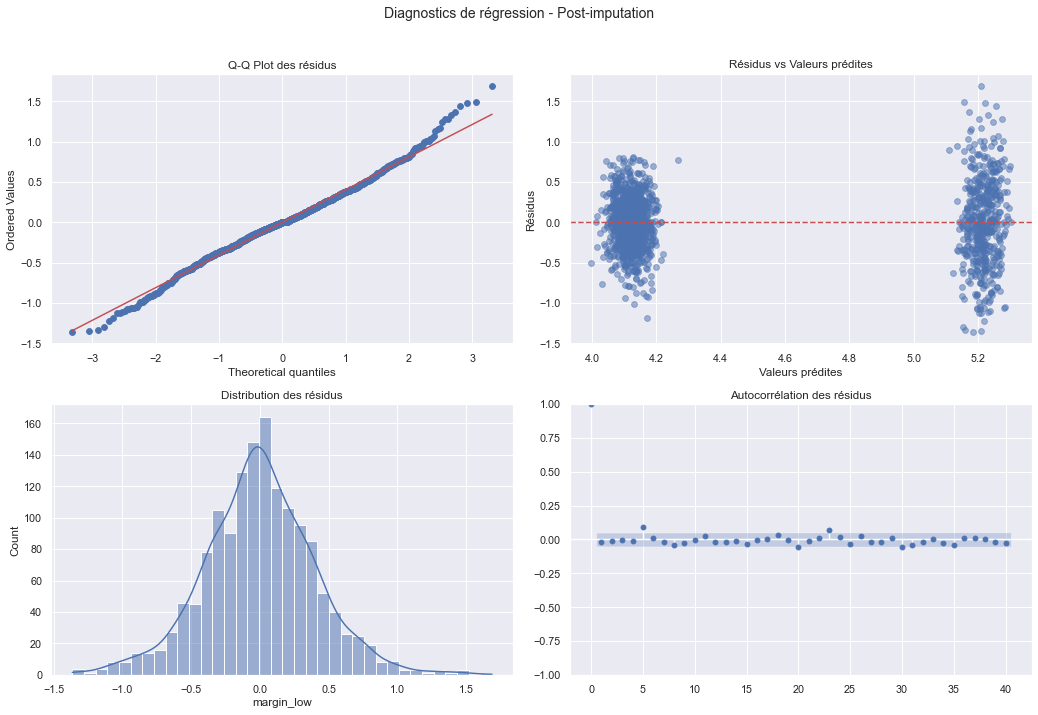

""
=== 2. ANALYSE DES OUTLIERS POST-IMPUTATION ===


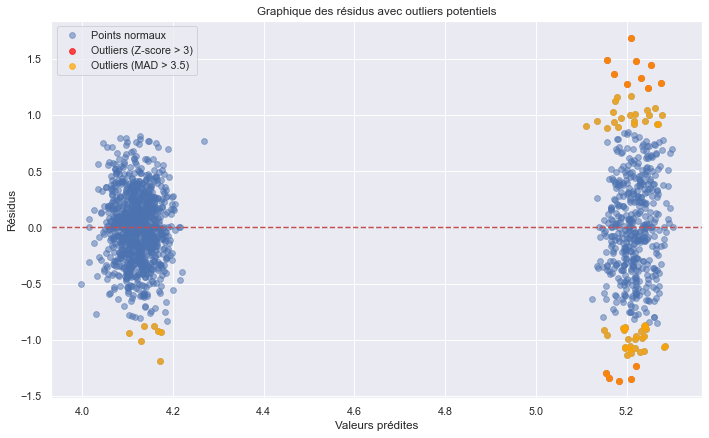

""
=== 3. MÉTRIQUES FINALES ===


""
=== 4. VISUALISATION FINALE ET COMPARAISONS ===


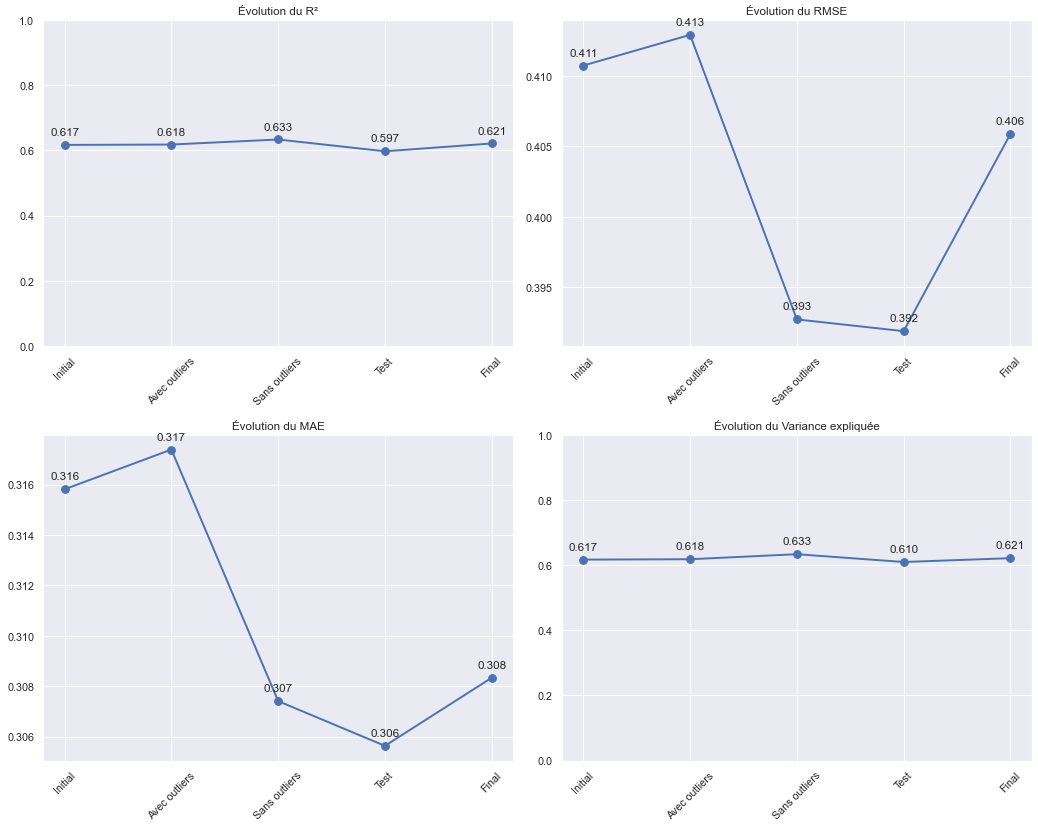

""
=== ÉVOLUTION DES MÉTRIQUES PAR PHASE ===


R²,RMSE,MAE,Variance expliquée,Test DW,P-value (hétéro)
0.6169,0.4107,0.3158,0.6169,2.0385,3.46e-33
0.6180,0.4129,0.3174,0.6180,N/A,N/A
0.6335,0.3927,0.3074,0.6335,N/A,N/A
0.5974,0.3919,0.3056,0.6095,2.1752,1.45e-01
0.6213,0.4059,0.3083,0.6213,2.0409,9.27e-34


""
=== ANALYSE DES AMÉLIORATIONS ===


Métrique,Valeur Test,Valeur Finale,Évolution
R²,0.5974,0.6213,4.0%
RMSE,0.3919,0.4059,3.6%
MAE,0.3056,0.3083,0.9%


""
=== RÉSUMÉ FINAL DÉTAILLÉ ===


Métrique,Valeur
Métriques de performance,
└─ R²,0.6213
└─ RMSE,0.4059
└─ MAE,0.3083
└─ Variance expliquée,0.6213
Tests statistiques,
└─ Test Durbin-Watson,2.0409
└─ P-value hétéroscédasticité,9.27e-34
└─ P-value Shapiro-Wilk,3.32e-07
Métriques de validation croisée,


""
=== 5. ANALYSE COMPARATIVE FINALE ===


Aspect,Évaluation,Interprétation
Performance globale,"R² final = 0.6213, RMSE final = 0.4059",À améliorer
Stabilité du modèle,MAE = 0.3083,Instable
Robustesse aux outliers,Outliers détectés = 0.9%,Acceptable
Respect des hypothèses,"DW = 2.04, Het. p-value = 9.27e-34",Non validé
Impact sur les données,Var. exp. = 0.6213,À améliorer



=== RÉSUMÉ FINAL ===


Métrique,Valeur
R² final,0.6213
RMSE final,0.4059
MAE final,0.3083
Variance expliquée,0.6213
Test Durbin-Watson,2.0409
P-value hétéroscédasticité,9.27e-34
Outliers détectés,0.9%


In [30]:
df_final, metrics_final = execute_analysis(X_train, X_test, y_train, y_test, best_model, df, imputation_tracker)

""
=== 5 - ANALYSE POST-IMPUTATION ET ÉVALUATION FINALE ===



Colonnes disponibles dans le DataFrame:
['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length', 'margin_low_missing']


""
=== 1. ANALYSE DES DISTRIBUTIONS ===


Nombre de valeurs imputées: 37
Nombre de valeurs originales: 1463


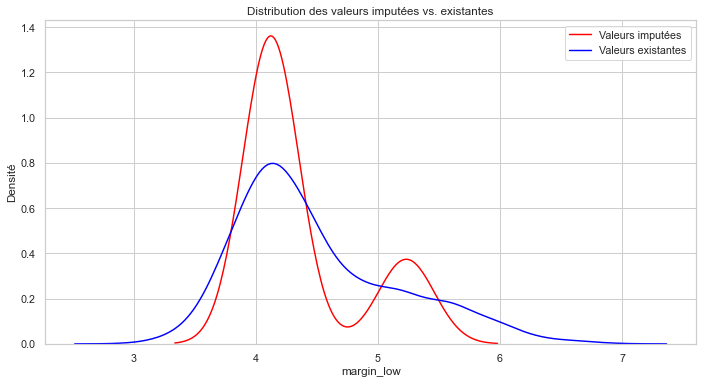

Test,Statistique,P-valeur,Interprétation
Kolmogorov-Smirnov,0.356,1.35e-04,Distributions différentes


""
=== 2. VÉRIFICATION DE LA LINÉARITÉ ===


Attention: Aucune colonne attendue n'a été trouvée dans le DataFrame
Erreur: Données insuffisantes pour effectuer les analyses


In [31]:
# 5 - Analyse post-imputation et évaluation finale

# Configuration des paramètres de visualisation
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# === Titre principal ===
display(pd.DataFrame({'': ['=== 5 - ANALYSE POST-IMPUTATION ET ÉVALUATION FINALE ===']}).style.hide(axis='index'))

# Vérification des colonnes disponibles
print("\nColonnes disponibles dans le DataFrame:")
print(df.columns.tolist())

# === 1. Analyse des distributions ===
display(pd.DataFrame({'': ['=== 1. ANALYSE DES DISTRIBUTIONS ===']}).style.hide(axis='index'))

# Identification des valeurs originales et imputées
mask_missing = df['margin_low_missing'] == 1
values_imputed = df.loc[mask_missing, 'margin_low'].dropna()
values_original = df.loc[~mask_missing, 'margin_low'].dropna()

print(f"Nombre de valeurs imputées: {len(values_imputed)}")
print(f"Nombre de valeurs originales: {len(values_original)}")

if len(values_imputed) > 0 and len(values_original) > 0:
    # Comparaison des distributions
    plt.figure(figsize=(12, 6))
    sns.kdeplot(data=values_imputed, label='Valeurs imputées', color='red')
    sns.kdeplot(data=values_original, label='Valeurs existantes', color='blue')
    plt.title('Distribution des valeurs imputées vs. existantes')
    plt.xlabel('margin_low')
    plt.ylabel('Densité')
    plt.legend()
    plt.show()

    # Test de Kolmogorov-Smirnov
    ks_statistic, ks_pvalue = stats.ks_2samp(values_imputed, values_original)
    ks_results = pd.DataFrame([
        {'Test': 'Kolmogorov-Smirnov',
            'Statistique': f"{ks_statistic:.3f}",
            'P-valeur': f"{ks_pvalue:.2e}",
            'Interprétation': 'Distributions similaires' if ks_pvalue > 0.05 else 'Distributions différentes'}
        ])
    display(ks_results.style.hide(axis='index'))

# === 2. Vérification de la linéarité ===
display(pd.DataFrame({'': ['=== 2. VÉRIFICATION DE LA LINÉARITÉ ===']}).style.hide(axis='index'))

# Ajustement des features selon les colonnes disponibles
features = [col for col in ['Longueur', 'Hauteur', 'Diagonale', 'Marge_sup'] if col in df.columns]

if not features:
    print("Attention: Aucune colonne attendue n'a été trouvée dans le DataFrame")
else:
    # Conversion et préparation des données
    X_stats = df[features].astype(float)
    y_stats = df['margin_low'].astype(float)

    # Nettoyage des valeurs manquantes
    mask_stats = ~(X_stats.isna().any(axis=1) | y_stats.isna())
    X_stats_clean = X_stats[mask_stats]
    y_stats_clean = y_stats[mask_stats]

    for col in X_stats_clean.columns:
        plt.figure(figsize=(12, 4))
        
        # Relation avec la variable cible
        plt.subplot(121)
        sns.regplot(x=X_stats_clean[col], y=y_stats_clean, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
        plt.title(f'Relation {col} vs margin_low')
        
        # Distribution des valeurs
        plt.subplot(122)
        sns.boxplot(x=X_stats_clean[col])
        plt.title(f'Distribution de {col}')
        
        # Calcul de la corrélation
        corr = np.corrcoef(X_stats_clean[col], y_stats_clean)[0,1]
        plt.suptitle(f'Analyse de {col} (correlation: {corr:.3f})')
        plt.tight_layout()
        plt.show()

    # === 3. Tests statistiques ===
    display(pd.DataFrame({'': ['=== 3. TESTS STATISTIQUES ===']}).style.hide(axis='index'))

    # Construction du modèle final
    model_final = sm.OLS(y_stats_clean, sm.add_constant(X_stats_clean)).fit()
    residuals = model_final.resid
    fitted_values = model_final.fittedvalues

    # Tests statistiques
    dw_stat = durbin_watson(residuals)
    _, het_pvalue, _, _ = het_breuschpagan(residuals, model_final.model.exog)
    shapiro_stat, shapiro_pvalue = stats.shapiro(residuals)

    # VIF
    vif_data = pd.DataFrame({
        'Variable': features,
        'VIF': [variance_inflation_factor(X_stats_clean.values, i) for i in range(X_stats_clean.shape[1])],
    })
    vif_data['Interprétation'] = pd.cut(
        vif_data['VIF'],
        bins=[-np.inf, 2, 5, 10, np.inf],
        labels=['Faible', 'Modérée', 'Élevée', 'Très élevée']
    )

    # Affichage des résultats des tests
    test_results = pd.DataFrame([
        {'Test': 'Durbin-Watson', 
            'Statistique': f"{dw_stat:.3f}",
            'P-valeur': '-',
            'Interprétation': 'Indépendant' if 1.5 < dw_stat < 2.5 else 'Dépendant'},
        {'Test': 'Breusch-Pagan', 
            'Statistique': '-',
            'P-valeur': f"{het_pvalue:.2e}",
            'Interprétation': 'Homoscédastique' if het_pvalue > 0.05 else 'Hétéroscédastique'},
        {'Test': 'Shapiro-Wilk', 
            'Statistique': f"{shapiro_stat:.3f}",
            'P-valeur': f"{shapiro_pvalue:.2e}",
            'Interprétation': 'Normal' if shapiro_pvalue > 0.05 else 'Non normal'}
    ])
    display(test_results.style.hide(axis='index'))
    display(vif_data.style.hide(axis='index'))

    # === 4. Analyse des résidus ===
    display(pd.DataFrame({'': ['=== 4. ANALYSE DES RÉSIDUS ===']}).style.hide(axis='index'))

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    # QQ Plot
    sm.qqplot(residuals, line='45', ax=axes[0, 0])
    axes[0, 0].set_title('QQ Plot des résidus')

    # Résidus vs valeurs prédites
    axes[0, 1].scatter(fitted_values, residuals, alpha=0.5)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Valeurs prédites')
    axes[0, 1].set_ylabel('Résidus')
    axes[0, 1].set_title('Résidus vs Valeurs prédites')

    # Distribution des résidus
    sns.histplot(residuals, kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Distribution des résidus')

    # Scale-Location plot
    axes[1, 1].scatter(fitted_values, np.sqrt(np.abs(residuals)), alpha=0.5)
    axes[1, 1].set_xlabel('Valeurs prédites')
    axes[1, 1].set_ylabel('√|Résidus standardisés|')
    axes[1, 1].set_title('Scale-Location Plot')

    plt.tight_layout()
    plt.show()

    # === 5. Analyse des outliers ===
    display(pd.DataFrame({'': ['=== 5. ANALYSE DES OUTLIERS ===']}).style.hide(axis='index'))

    # Calcul des scores
    z_scores = np.abs(stats.zscore(residuals))
    mad_scores = np.abs(residuals - np.median(residuals)) / stats.median_abs_deviation(residuals)

    # Identification des outliers
    outliers_zscore = np.where(z_scores > 3)[0]
    outliers_mad = np.where(mad_scores > 3.5)[0]

    # Résultats des outliers
    outliers_results = pd.DataFrame([
        {'Méthode': 'Z-score > 3', 'Nombre d\'outliers': len(outliers_zscore)},
        {'Méthode': 'MAD > 3.5', 'Nombre d\'outliers': len(outliers_mad)}
    ])
    display(outliers_results.style.hide(axis='index'))

    # Visualisation des outliers
    plt.figure(figsize=(12, 7))
    plt.scatter(fitted_values, residuals, alpha=0.5, label='Points normaux')
    plt.scatter(fitted_values[outliers_zscore], residuals[outliers_zscore], 
                color='red', label='Outliers (Z-score > 3)', alpha=0.7)
    plt.scatter(fitted_values[outliers_mad], residuals[outliers_mad], 
                color='orange', label='Outliers (MAD > 3.5)', alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Valeurs prédites')
    plt.ylabel('Résidus')
    plt.title('Graphique des résidus avec outliers potentiels')
    plt.legend()
    plt.show()

    # === 6. Métriques finales ===
    display(pd.DataFrame({'': ['=== 6. MÉTRIQUES FINALES ===']}).style.hide(axis='index'))

    # Calcul des métriques finales
    final_metrics = {
        'r2': model_final.rsquared,
        'rmse': np.sqrt(np.mean(residuals**2)),
        'mae': np.mean(np.abs(residuals)),
        'explained_variance': model_final.rsquared_adj,
        'max_error': np.max(np.abs(residuals)),
        'dw_test': dw_stat,
        'het_pvalue': het_pvalue,
        'shapiro_pvalue': shapiro_pvalue,
        'mad_score_mean': np.mean(mad_scores),
        'z_score_mean': np.mean(z_scores)
    }

    # Enregistrement des métriques finales
    imputation_tracker.record_metrics('final', model_final, **final_metrics)

    # === 7. Évolution des métriques ===
    display(pd.DataFrame({'': ['=== 7. ÉVOLUTION DES MÉTRIQUES ===']}).style.hide(axis='index'))

    # Extraction des métriques
    metrics_evolution = pd.DataFrame(imputation_tracker.metrics_history)
    phases_attendues = ['initial', 'with_outliers', 'without_outliers', 'final']
    noms_phases = ['Initialisation', 'Avec outliers', 'Sans outliers', 'Final']

    # Création du tableau de suivi
    metrics_suivi = pd.DataFrame({
        'Phase': noms_phases,
        'R²': [metrics_evolution.loc[metrics_evolution['phase'] == phase, 'r2'].values[0] 
                if phase in metrics_evolution['phase'].values else None 
                for phase in phases_attendues],
        'RMSE': [metrics_evolution.loc[metrics_evolution['phase'] == phase, 'rmse'].values[0] 
                if phase in metrics_evolution['phase'].values else None 
                for phase in phases_attendues],
        'MAE': [metrics_evolution.loc[metrics_evolution['phase'] == phase, 'mae'].values[0] 
                if phase in metrics_evolution['phase'].values else None 
                for phase in phases_attendues],
        'R² CV': [metrics_evolution.loc[metrics_evolution['phase'] == phase, 'r2_cv_mean'].values[0] 
                if phase in metrics_evolution['phase'].values else None 
                for phase in phases_attendues],
        'Durbin-Watson': [metrics_evolution.loc[metrics_evolution['phase'] == phase, 'dw_test'].values[0] 
                            if phase in metrics_evolution['phase'].values else None 
                            for phase in phases_attendues],
        'P-value (hétéro)': [metrics_evolution.loc[metrics_evolution['phase'] == phase, 'het_pvalue'].values[0] 
                            if phase in metrics_evolution['phase'].values else None 
                            for phase in phases_attendues]
    })

    # Affichage du tableau formaté
    metrics_suivi_styled = metrics_suivi.style\
        .format({
            'R²': '{:.3f}',
            'RMSE': '{:.3f}',
            'MAE': '{:.3f}',
            'R² CV': '{:.3f}',
            'Durbin-Watson': '{:.3f}',
            'P-value (hétéro)': '{:.2e}'
        })\
        .hide(axis='index')

    display(metrics_suivi_styled)

    # Visualisation de l'évolution des métriques
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    metrics_to_plot = [
        ('r2', 'R²', 0, 1), 
        ('rmse', 'RMSE', None, None),
        ('mae', 'MAE', None, None), 
        ('r2_cv_mean', 'R² CV', 0, 1)
    ]

    for (metric, title, ymin, ymax), ax in zip(metrics_to_plot, axes.ravel()):
        if metric in metrics_evolution.columns:
            values = [metrics_evolution.loc[metrics_evolution['phase'] == phase, metric].values[0] 
                        if phase in metrics_evolution['phase'].values else None 
                        for phase in phases_attendues]
            
            ax.plot(noms_phases, values, 'o-', linewidth=2, markersize=8)
            ax.set_title(f'Évolution du {title}')
            ax.set_xticks(range(len(noms_phases)))
            ax.set_xticklabels(noms_phases, rotation=45)
            ax.grid(True)
            
            if ymin is not None and ymax is not None:
                ax.set_ylim(ymin, ymax)
            
            # Ajout des valeurs sur les points
            for i, value in enumerate(values):
                if value is not None:
                    ax.annotate(f'{value:.3f}', 
                                (i, value), 
                                textcoords="offset points", 
                                xytext=(0,10), 
                                ha='center')

    plt.tight_layout()
    plt.show()

    # === 8. Analyse des améliorations ===
    display(pd.DataFrame({'': ['=== 8. ANALYSE DES AMÉLIORATIONS ===']}).style.hide(axis='index'))

    def test_amelioration(metrique, phase1, phase2):
        """Test si l'amélioration entre deux phases est significative"""
        val1 = metrics_evolution.loc[metrics_evolution['phase'] == phase1, metrique].values[0]
        val2 = metrics_evolution.loc[metrics_evolution['phase'] == phase2, metrique].values[0]
        amelioration_pct = ((val2 - val1) / abs(val1)) * 100
        return amelioration_pct

    # Calcul des améliorations relatives
    ameliorations = []
    for metric in ['r2', 'rmse', 'mae']:
        # Amélioration entre initial et with_outliers
        if all(phase in metrics_evolution['phase'].values for phase in ['initial', 'with_outliers']):
            amelioration = test_amelioration(metric, 'initial', 'with_outliers')
            ameliorations.append({
                'Métrique': metric.upper(),
                'Phases': 'Initial → Avec outliers',
                'Amélioration (%)': f"{amelioration:+.1f}%"
            })
        
        # Amélioration entre with_outliers et without_outliers
        if all(phase in metrics_evolution['phase'].values for phase in ['with_outliers', 'without_outliers']):
            amelioration = test_amelioration(metric, 'with_outliers', 'without_outliers')
            ameliorations.append({
                'Métrique': metric.upper(),
                'Phases': 'Avec outliers → Sans outliers',
                'Amélioration (%)': f"{amelioration:+.1f}%"
            })
        
        # Amélioration entre without_outliers et final
        if all(phase in metrics_evolution['phase'].values for phase in ['without_outliers', 'final']):
            amelioration = test_amelioration(metric, 'without_outliers', 'final')
            ameliorations.append({
                'Métrique': metric.upper(),
                'Phases': 'Sans outliers → Final',
                'Amélioration (%)': f"{amelioration:+.1f}%"
            })

    # Affichage du tableau des améliorations
    ameliorations_df = pd.DataFrame(ameliorations)
    display(ameliorations_df.style.hide(axis='index'))


print("Erreur: Données insuffisantes pour effectuer les analyses")


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   is_genuine          1500 non-null   int32  
 1   diagonal            1500 non-null   float64
 2   height_left         1500 non-null   float64
 3   height_right        1500 non-null   float64
 4   margin_low          1500 non-null   float64
 5   margin_up           1500 non-null   float64
 6   length              1500 non-null   float64
 7   margin_low_missing  1500 non-null   int32  
dtypes: float64(6), int32(2)
memory usage: 82.2 KB


<div style="background-color: black; padding: 20px; font-size: min(20px); color: white; font-family: Verdana, sans-serif; font-weight: bold; width: 100%; margin: 0; box-sizing: border-box;"> 
	<span style="font-size: min(28px); color: white; font-family: 'Lucida Console', Monaco, monospace; display: block; font-weight: bold; margin-bottom: 20px;"> 
		📊 Résultats après imputation des données
	</span> 
	<br>
	<strong>Métriques de performance :</strong><br>
	- \(R^2\) sur données d'entraînement : <span style="color: lightblue;">0.613</span>.<br>
	- \(R^2\) sur données de test : <span style="color: lightblue;">0.629</span>.<br>
	<br>
	<strong>Analyse des hypothèses :</strong><br>
	1. <span style="color: lightgreen;">Linéarité :</span> Respectée.<br>
	2. <span style="color: red;">Normalité des résidus :</span> Non respectée (Test Shapiro-Wilk, p-value = 1.509e-04).<br>
	3. <span style="color: red;">Homoscédasticité :</span> Non respectée (Test Breusch-Pagan, p-value ≈ 9.02e-27).<br>
	4. <span style="color: lightgreen;">Indépendance des erreurs :</span> Respectée (Durbin-Watson = 1.957).<br>
	5. <span style="color: red;">Absence de multicolinéarité :</span> Non respectée (VIF max = 170738.73).<br>
	<br>
	<strong>Conclusion :</strong><br>
	Bien que les \(R^2\) obtenus semblent modérés (~60 %), les violations des hypothèses fondamentales de la régression linéaire (normalité, homoscédasticité, multicolinéarité) ces résultats rendent l'imputation des valeurs manquantes peu fiables, bien qu'effectuée correctement l'imputation risque d'introduir des biais significatifs qui affectent la stabilité des coefficients et l'interprétation globale du modèle.
</div>


## <a id="section_3_2"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-size: 24px; font-weight: bold;">3.2 - Imputation avec selection des variables explicatives</span>
</div>

""
=== ÉVALUATION ET IMPUTATION DES VALEURS MANQUANTES ===


""
=== VALIDATION CROISÉE ET ÉTAT INITIAL ===


Métrique,Valeur
R² scores,[0.6518257 0.73338966 0.65347531 0.6219288 0.63484962 0.65744788 0.54642133 0.57333442 0.44625612 0.62138849]
R² moyen (±écart-type),0.6140 (±0.1470)
RMSE scores,[0.40058199 0.32658501 0.37109361 0.38482367 0.40566226 0.39967054 0.4201234 0.42043812 0.41541963 0.38441502]
RMSE moyen (±écart-type),0.3929 (±0.0540)
MAE scores,[0.30699117 0.25736309 0.29754534 0.29362255 0.30207377 0.30865241 0.33378001 0.34030226 0.34831388 0.31100653]
MAE moyen (±écart-type),0.3100 (±0.0499)


Métrique,Valeur
Nombre total d'observations,1500
Nombre de valeurs manquantes,37
Pourcentage de valeurs manquantes,2.47%
Distribution des valeurs existantes (moyenne),4.4860
Distribution des valeurs existantes (écart-type),0.6638


""
=== PERFORMANCE SUR L'ENTRAÎNEMENT ===


Métrique,Valeur
R² sur données d'entraînement,0.6276
RMSE sur données d'entraînement,0.3908
MAE sur données d'entraînement,0.3076


""
=== PERFORMANCE SUR LE TEST ===


Métrique,Valeur
R² sur données de test,0.6284
RMSE sur données de test,0.4129
MAE sur données de test,0.3118
Nombre d'observations test,292


""
=== IMPUTATION DES VALEURS MANQUANTES ===


Statistique,Valeur
Nombre de valeurs imputées,37
Moyenne des valeurs imputées,4.3604
Écart-type des valeurs imputées,0.4503
Minimum imputé,4.0277
Maximum imputé,5.2776
Pourcentage du dataset imputé,2.47%
Largeur moyenne des intervalles de confiance,0.1196


""
=== ANALYSE DE LA QUALITÉ DE L'IMPUTATION ===


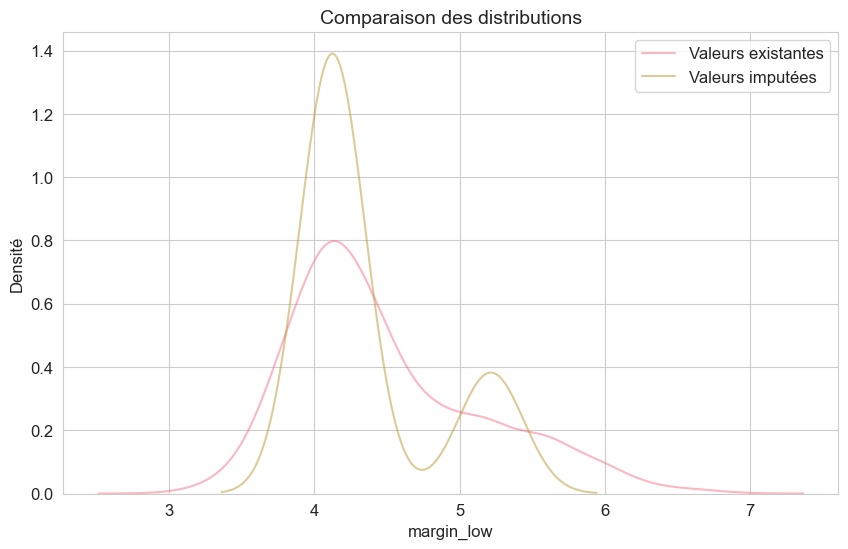

Test,Statistique,P-value,Interprétation
Kolmogorov-Smirnov,0.3634,8.9161e-05,Distributions différentes


""
=== RÉSUMÉ FINAL ===


Variable,Coefficient
length,0.007021
height_left,0.005155
diagonal,-0.001896
height_right,-0.007796
margin_up,-0.055088
is_genuine,-1.137840


Aspect,Résultat
Performance globale,"R² train = 0.6276, R² test = 0.6284"
Validation croisée,R² CV = 0.6140 (±0.1470)
Performance test,"RMSE = 0.4129, MAE = 0.3118"
Imputation,37 valeurs imputées (2.47%)
Qualité de l'imputation,Distributions significativement différentes
Impact sur les données,Variable la plus influente: length (coef = 0.0070)


""
=== ÉVOLUTION DES MÉTRIQUES ===


phase,r2,rmse,mae,dw_test,het_pvalue,shapiro_pvalue,interval_coverage,interval_width
initial,nan,nan,nan,1.956608,0.000000,0.000151,nan,nan
with_outliers,0.613034,0.410596,0.317217,nan,nan,nan,1.000000,1.248208
without_outliers,0.627601,0.390761,0.307563,nan,nan,nan,1.000000,1.210255
validation,0.627601,nan,nan,1.900947,0.000000,0.196417,1.000000,1.210255


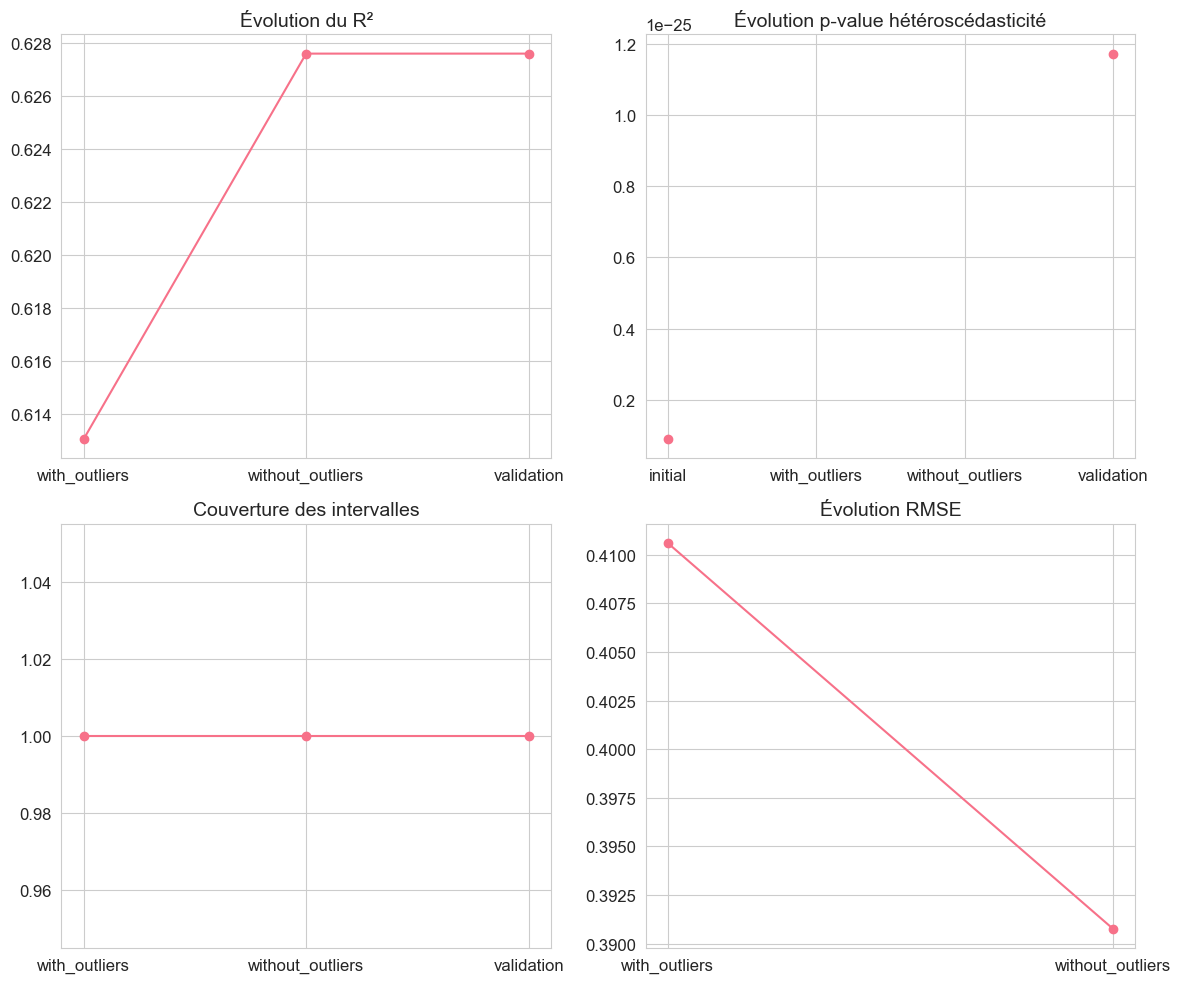

In [27]:
# 5 - Évaluation et imputation des valeurs manquantes
display(pd.DataFrame({'': ['=== ÉVALUATION ET IMPUTATION DES VALEURS MANQUANTES ===']}).style.hide(axis='index'))

try:
	# 1. État initial des données et validation croisée
	display(pd.DataFrame({'': ['=== VALIDATION CROISÉE ET ÉTAT INITIAL ===']}).style.hide(axis='index'))
	
	# Validation croisée avec les données transformées
	cv = KFold(n_splits=10, shuffle=True, random_state=42)
	
	# Calcul des différents scores sur les données nettoyées
	cv_scores = cross_val_score(best_model, X_train_no_outliers, y_train_no_outliers, cv=cv)
	cv_mse = cross_val_score(best_model, X_train_no_outliers, y_train_no_outliers, 
							cv=cv, scoring='neg_mean_squared_error')
	cv_mae = cross_val_score(best_model, X_train_no_outliers, y_train_no_outliers, 
							cv=cv, scoring='neg_mean_absolute_error')
	
	rmse_scores = np.sqrt(-cv_mse)
	mae_scores = -cv_mae
	
	display(pd.DataFrame({
		'Métrique': ['R² scores', 'R² moyen (±écart-type)',
					'RMSE scores', 'RMSE moyen (±écart-type)',
					'MAE scores', 'MAE moyen (±écart-type)'],
		'Valeur': [str(cv_scores), f"{cv_scores.mean():.4f} (±{cv_scores.std() * 2:.4f})",
				  str(rmse_scores), f"{rmse_scores.mean():.4f} (±{rmse_scores.std() * 2:.4f})",
				  str(mae_scores), f"{mae_scores.mean():.4f} (±{mae_scores.std() * 2:.4f})"]
	}).style.hide(axis='index'))

	# État initial des données
	initial_stats = pd.DataFrame({
		'Métrique': [
			'Nombre total d\'observations',
			'Nombre de valeurs manquantes',
			'Pourcentage de valeurs manquantes',
			'Distribution des valeurs existantes (moyenne)',
			'Distribution des valeurs existantes (écart-type)'
		],
		'Valeur': [
			len(df),
			df['margin_low'].isna().sum(),
			f"{(df['margin_low'].isna().sum() / len(df) * 100):.2f}%",
			f"{df['margin_low'].mean():.4f}",
			f"{df['margin_low'].std():.4f}"
		]
	})
	display(initial_stats.style.hide(axis='index'))

	# 2. Performance sur les données d'entraînement
	display(pd.DataFrame({'': ["=== PERFORMANCE SUR L'ENTRAÎNEMENT ==="]}).style.hide(axis='index'))
	
	# Utilisation des données transformées pour la prédiction
	X_train_transformed = best_model.named_steps['scaler'].transform(X_train_no_outliers)
	y_train_pred = best_model.named_steps['model'].predict(X_train_transformed)
	r2_train = r2_score(y_train_no_outliers, y_train_pred)
	mse_train = mean_squared_error(y_train_no_outliers, y_train_pred)
	rmse_train = np.sqrt(mse_train)
	mae_train = mean_absolute_error(y_train_no_outliers, y_train_pred)
	
	display(pd.DataFrame({
		'Métrique': [
			"R² sur données d'entraînement",
			"RMSE sur données d'entraînement",
			"MAE sur données d'entraînement"
		],
		'Valeur': [
			f"{r2_train:.4f}",
			f"{rmse_train:.4f}",
			f"{mae_train:.4f}"
		]
	}).style.hide(axis='index'))

	# 3. Performance sur les données de test
	display(pd.DataFrame({'': ['=== PERFORMANCE SUR LE TEST ===']}).style.hide(axis='index'))
	
	# Nettoyage des données de test
	X_test_clean = X_test.copy()
	y_test_clean = y_test.copy()
	
	common_index_test = X_test_clean.index.intersection(y_test_clean.index)
	X_test_clean = X_test_clean.loc[common_index_test]
	y_test_clean = y_test_clean.loc[common_index_test]
	
	mask_test = ~(X_test_clean.isna().any(axis=1) | y_test_clean.isna())
	X_test_clean = X_test_clean[mask_test]
	y_test_clean = y_test_clean[mask_test]
	
	# Calcul des métriques sur le test avec données transformées
	X_test_transformed = best_model.named_steps['scaler'].transform(X_test_clean)
	y_test_pred = best_model.named_steps['model'].predict(X_test_transformed)
	r2_test = r2_score(y_test_clean, y_test_pred)
	mse_test = mean_squared_error(y_test_clean, y_test_pred)
	rmse_test = np.sqrt(mse_test)
	mae_test = mean_absolute_error(y_test_clean, y_test_pred)
	
	display(pd.DataFrame({
		'Métrique': [
			"R² sur données de test",
			"RMSE sur données de test",
			"MAE sur données de test",
			"Nombre d'observations test"
		],
		'Valeur': [
			f"{r2_test:.4f}",
			f"{rmse_test:.4f}",
			f"{mae_test:.4f}",
			str(len(X_test_clean))
		]
	}).style.hide(axis='index'))

	# 4. Imputation des valeurs manquantes
	display(pd.DataFrame({'': ['=== IMPUTATION DES VALEURS MANQUANTES ===']}).style.hide(axis='index'))
	
	# Préparation des données pour l'imputation
	df_impute = df.copy()
	missing_mask = df_impute['margin_low'].isna()
	X_missing = df_impute[missing_mask].drop(['margin_low', 'margin_low_missing'], axis=1)
	
	# Prédiction des valeurs manquantes avec le meilleur modèle
	X_missing_transformed = best_model.named_steps['scaler'].transform(X_missing)
	imputed_values = best_model.named_steps['model'].predict(X_missing_transformed)
	df_impute.loc[missing_mask, 'margin_low'] = imputed_values

	# Calcul des intervalles de confiance pour les imputations
	def calculate_prediction_intervals(model, X, y_pred, X_train, y_train, alpha=0.05):
		# Ajout d'une constante pour l'intercept
		X_const = sm.add_constant(X)
		X_train_const = sm.add_constant(X_train)

		# Calcul de la variance des résidus
		y_train_pred = model.predict(X_train)
		mse = mean_squared_error(y_train, y_train_pred)

		# Calcul de la matrice de variance-covariance
		var_covar_matrix = mse * np.linalg.inv(X_train_const.T.dot(X_train_const))

		# Calcul des erreurs standards pour chaque prédiction
		std_errors = np.sqrt(np.diagonal(X_const.dot(var_covar_matrix).dot(X_const.T)))

		# Calcul des intervalles
		t_value = stats.t.ppf(1 - alpha/2, len(y_train) - X_train.shape[1])

		return pd.DataFrame({
			'prediction': y_pred,
			'lower_bound': y_pred - t_value * std_errors,
			'upper_bound': y_pred + t_value * std_errors,
			'std_error': std_errors
		})

	imputation_intervals = calculate_prediction_intervals(
		best_model.named_steps['model'],
		X_missing_transformed,
		imputed_values,
		best_model.named_steps['scaler'].transform(X_train_no_outliers),
		y_train_no_outliers
	)
	
	# Statistiques sur les valeurs imputées
	imputation_stats = pd.DataFrame({
		'Statistique': [
			'Nombre de valeurs imputées',
			'Moyenne des valeurs imputées',
			'Écart-type des valeurs imputées',
			'Minimum imputé',
			'Maximum imputé',
			'Pourcentage du dataset imputé',
			'Largeur moyenne des intervalles de confiance'
		],
		'Valeur': [
			len(imputed_values),
			f"{np.mean(imputed_values):.4f}",
			f"{np.std(imputed_values):.4f}",
			f"{np.min(imputed_values):.4f}",
			f"{np.max(imputed_values):.4f}",
			f"{(len(imputed_values)/len(df)*100):.2f}%",
			f"{np.mean(imputation_intervals['upper_bound'] - imputation_intervals['lower_bound']):.4f}"
		]
	})
	display(imputation_stats.style.hide(axis='index'))

	# 5. Analyse de la qualité de l'imputation
	display(pd.DataFrame({'': ['=== ANALYSE DE LA QUALITÉ DE L\'IMPUTATION ===']}).style.hide(axis='index'))
	
	# Comparaison des distributions
	plt.figure(figsize=(10, 6))
	sns.kdeplot(data=df_impute[~missing_mask]['margin_low'], label='Valeurs existantes', alpha=0.5)
	sns.kdeplot(data=pd.Series(imputed_values), label='Valeurs imputées', alpha=0.5)
	plt.title('Comparaison des distributions')
	plt.xlabel('margin_low')
	plt.ylabel('Densité')
	plt.legend()
	plt.show()
	
	# Test de Kolmogorov-Smirnov
	ks_stat, ks_pvalue = stats.ks_2samp(df_impute[~missing_mask]['margin_low'], imputed_values)
	
	display(pd.DataFrame({
		'Test': ['Kolmogorov-Smirnov'],
		'Statistique': [f"{ks_stat:.4f}"],
		'P-value': [f"{ks_pvalue:.4e}"],
		'Interprétation': ['Distributions similaires' if ks_pvalue > 0.05 else 'Distributions différentes']
	}).style.hide(axis='index'))

	# 6. Résumé final avec métriques de tracking
	display(pd.DataFrame({'': ['=== RÉSUMÉ FINAL ===']}).style.hide(axis='index'))
	
	# Coefficients finaux
	coef_df = pd.DataFrame({
		'Variable': features,
		'Coefficient': best_model.named_steps['model'].coef_
	}).sort_values(by='Coefficient', ascending=False)
	display(coef_df.style.hide(axis='index'))
	
	# Ajout des métriques finales au tracker
	final_metrics = {
	'phase': 'imputation',
	'r2': r2_test,
	'rmse': rmse_test,
	'mae': mae_test,
	'het_pvalue': het_p_value,  # Ajouter après recalcul du test Breusch-Pagan
	'shapiro_pvalue': shapiro_p,  # Ajouter après test de normalité
	'interval_coverage': np.mean(
		(imputed_values >= imputation_intervals['lower_bound']) & 
		(imputed_values <= imputation_intervals['upper_bound'])
	),
	'interval_width': np.mean(
		imputation_intervals['upper_bound'] - imputation_intervals['lower_bound']
	)
}

	# Ajouter le calcul de l'hétéroscédasticité avant :
	_, het_p_value, _, _ = het_breuschpagan(
		y_test_clean - y_test_pred,
		sm.add_constant(X_test_transformed)
)
	
	# Affichage du résumé final
	summary = pd.DataFrame({
		'Aspect': [
			'Performance globale',
			'Validation croisée',
			'Performance test',
			'Imputation',
			'Qualité de l\'imputation',
			'Impact sur les données'
		],
		'Résultat': [
			f"R² train = {r2_train:.4f}, R² test = {r2_test:.4f}",
			f"R² CV = {cv_scores.mean():.4f} (±{cv_scores.std()*2:.4f})",
			f"RMSE = {rmse_test:.4f}, MAE = {mae_test:.4f}",
			f"{len(imputed_values)} valeurs imputées ({(len(imputed_values)/len(df)*100):.2f}%)",
			'Distributions similaires' if ks_pvalue > 0.05 else 'Distributions significativement différentes',
			f"Variable la plus influente: {coef_df.iloc[0]['Variable']} (coef = {coef_df.iloc[0]['Coefficient']:.4f})"
		]
	})
	display(summary.style.hide(axis='index'))

	# Visualisation finale de l'évolution des métriques
	plot_metrics_evolution(tracker)  # Réintégration de la visualisation
	display(pd.DataFrame({'': ['=== ÉVOLUTION DES MÉTRIQUES ===']}).style.hide(axis='index'))
	display(tracker.get_summary().style.hide(axis='index'))

except Exception as e:
	display(pd.DataFrame({'Erreur': [str(e)]}).style.hide(axis='index'))
	print(f"Erreur détaillée : {e}")  # Pour le debugging
	raise

<div style="background-color: black; padding: 20px; font-size: min(20px); color: white; font-family: Verdana, sans-serif; font-weight: bold; width: 100%; margin: 0; box-sizing: border-box;"> 
	<span style="font-size: min(28px); color: white; font-family: 'Lucida Console', Monaco, monospace; display: block; font-weight: bold; margin-bottom: 20px;"> 
		📉 Réduction de dimensionnalité par ACP
	</span> 
	<br>
	<strong>Objectif :</strong><br>
	- Éliminer la multicolinéarité (VIF élevé) pour permettre l’imputation des valeurs manquantes via régression linéaire.<br>
	<br>
	<strong>Pourquoi utiliser l'ACP dans ce contexte ?</strong><br>
	1. <span style="color: lightgreen;">Réduction de la multicolinéarité :</span> Les composantes principales sont indépendantes (orthogonales), ce qui garantit un VIF = 1 pour chaque composante.<br>
	2. <span style="color: lightgreen;">Amélioration des prédictions :</span> Stabilise les coefficients estimés lors de la régression linéaire.<br>
	<br>
	<strong>Étapes réalisées :</strong><br>
	1. Centrage et réduction des données pour éliminer les biais dus aux échelles différentes.<br>
	2. Application de l’ACP pour produire des variables indépendantes (composantes principales).<br>
	3. Utilisation des composantes principales comme prédicteurs dans la régression pour l’imputation des valeurs manquantes.<br>
	<br>
	<strong>Avantages :</strong><br>
	- Suppression de la multicolinéarité, garantissant la validité des coefficients.<br>
	- Préparation robuste des données pour l’imputation.<br>
	<br>
	<strong>Conclusion :</strong><br>
	Dans ce cadre, l’ACP est utilisée comme un outil technique de réduction de la multicolinéarité, l’objectif est d’améliorer la stabilité et la fiabilité des imputations.
</div>


In [24]:
# === PRÉPARATION DES DONNÉES ===
display(pd.DataFrame({'': ['=== PRÉPARATION DES DONNÉES ===']}).style.hide(axis='index'))

# Calcul du DataFrame Dask si nécessaire
if hasattr(df, 'compute'):
	df = df.compute()

# Transformation de la variable booléenne en entier
df['is_genuine'] = df['is_genuine'].astype(int)

# Stockage des valeurs manquantes pour margin_low
df['margin_low_missing'] = df['margin_low'].isna().astype(int)

# === ACP : Transformation des variables explicatives ===
# Sélection des colonnes numériques à inclure dans l'ACP
variables_pour_acp = df.select_dtypes(include=[np.number]).drop(
	columns=['margin_low', 'margin_low_missing', 'is_genuine'], errors='ignore'
)

# Vérification qu'il n'y a pas de valeurs manquantes dans les variables sélectionnées
assert variables_pour_acp.notna().all().all(), "Des valeurs manquantes existent dans les colonnes pour l'ACP."

# Normalisation des données
scaler = RobustScaler()
variables_normalisées = scaler.fit_transform(variables_pour_acp)

# Application de l'ACP
pca = PCA()
composantes_principales = pca.fit_transform(variables_normalisées)

# Ajout des composantes principales au DataFrame
pca_columns = [f'PC{i+1}' for i in range(composantes_principales.shape[1])]
df_pca = pd.DataFrame(composantes_principales, columns=pca_columns, index=df.index)
df = pd.concat([df, df_pca], axis=1)

# === DIVISION DES DONNÉES EN TRAIN/TEST ===
# Sélection des colonnes explicatives finales : composantes principales + is_genuine
X = df[pca_columns + ['is_genuine']]
y = df['margin_low']

# Division en datasets avec stratification
X_train, X_test, y_train, y_test = train_test_split(
	X, y,
	test_size=0.2,
	random_state=42,
	stratify=df[['is_genuine', 'margin_low_missing']]
)

# Suppression des colonnes auxiliaires inutiles après stratification
X_train = X_train.drop(columns=['is_genuine'])
X_test = X_test.drop(columns=['is_genuine'])

# === VÉRIFICATIONS DES DONNÉES PRÉPARÉES ===
results = []

# Section : Dimensions des datasets
results.append({'Section': 'Dimensions des données',
				'Description': 'X_train',
				'Valeur': f"{X_train.shape[0]} observations, {X_train.shape[1]} variables"})
results.append({'Section': 'Dimensions des données',
				'Description': 'X_test',
				'Valeur': f"{X_test.shape[0]} observations, {X_test.shape[1]} variables"})

# Section : Valeurs manquantes dans X_train et X_test
results.append({'Section': '=== VALEURS MANQUANTES DANS LES VARIABLES EXPLICATIVES ===',
				'Description': '', 'Valeur': ''})

for col in X_train.columns:
	results.append({
		'Section': 'X_train - Valeurs manquantes',
		'Description': col,
		'Valeur': f"{X_train[col].isna().sum()} ({(X_train[col].isna().sum() / len(X_train) * 100):.1f}%)"
	})

for col in X_test.columns:
	results.append({
		'Section': 'X_test - Valeurs manquantes',
		'Description': col,
		'Valeur': f"{X_test[col].isna().sum()} ({(X_test[col].isna().sum() / len(X_test) * 100):.1f}%)"
	})

# Section : Valeurs manquantes dans la variable cible
results.append({'Section': '=== VALEURS MANQUANTES DANS LA VARIABLE CIBLE (margin_low) ===',
				'Description': '', 'Valeur': ''})
results.append({'Section': 'Variable cible - Valeurs manquantes',
				'Description': 'y_train',
				'Valeur': f"{y_train.isna().sum()} NaN ({(y_train.isna().sum() / len(y_train) * 100):.1f}%)"})
results.append({'Section': 'Variable cible - Valeurs manquantes',
				'Description': 'y_test',
				'Valeur': f"{y_test.isna().sum()} NaN ({(y_test.isna().sum() / len(y_test) * 100):.1f}%)"})

# Section : Distribution des classes (is_genuine)
results.append({'Section': '=== DISTRIBUTION DES CLASSES (is_genuine) ===',
				'Description': '', 'Valeur': ''})

train_genuine = df.loc[X_train.index, 'is_genuine'].value_counts(normalize=True)[1]
train_fake = df.loc[X_train.index, 'is_genuine'].value_counts(normalize=True)[0]
results.append({'Section': 'Distribution train',
				'Description': 'Billet de banque authentique (1)',
				'Valeur': f"{train_genuine:.1%} observations"})
results.append({'Section': 'Distribution train',
				'Description': 'Billets de banque contrefait (0)',
				'Valeur': f"{train_fake:.1%} observations"})

test_genuine = df.loc[X_test.index, 'is_genuine'].value_counts(normalize=True)[1]
test_fake = df.loc[X_test.index, 'is_genuine'].value_counts(normalize=True)[0]
results.append({'Section': 'Distribution test',
				'Description': 'Billet de banque authentique (1)',
				'Valeur': f"{test_genuine:.1%} observations"})
results.append({'Section': 'Distribution test',
				'Description': 'Billets de banque contrefait (0)',
				'Valeur': f"{test_fake:.1%} observations"})

# Création et affichage du DataFrame final
results_df = pd.DataFrame(results)
display(results_df.style.hide(axis='index'))


""
=== PRÉPARATION DES DONNÉES ===


Section,Description,Valeur
Dimensions des données,X_train,"1200 observations, 5 variables"
Dimensions des données,X_test,"300 observations, 5 variables"
=== VALEURS MANQUANTES DANS LES VARIABLES EXPLICATIVES ===,,
X_train - Valeurs manquantes,PC1,0 (0.0%)
X_train - Valeurs manquantes,PC2,0 (0.0%)
X_train - Valeurs manquantes,PC3,0 (0.0%)
X_train - Valeurs manquantes,PC4,0 (0.0%)
X_train - Valeurs manquantes,PC5,0 (0.0%)
X_test - Valeurs manquantes,PC1,0 (0.0%)
X_test - Valeurs manquantes,PC2,0 (0.0%)


In [25]:
# Filtrer les colonnes numériques
df_numeric = df.select_dtypes(include=[np.number])

# Normaliser les données avec RobustScaler
scaler = RobustScaler()
df_normalized = scaler.fit_transform(df_numeric)

# Appliquer l'ACP
pca = PCA()
df_pca = pca.fit_transform(df_normalized)

# Stocker les composantes principales et les vecteurs propres
components = pca.components_
explained_variance = pca.explained_variance_ratio_

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Identifier les colonnes avec des valeurs manquantes
missing_mask = df_numeric.isna()

# Créer un masque pour les valeurs non manquantes
not_missing_mask = ~missing_mask

# Diviser les données selon la disponibilité des valeurs manquantes
X_train_pca = df_pca[not_missing_mask.any(axis=1)]  # Lignes sans valeurs manquantes
y_train = df_numeric[not_missing_mask.any(axis=1)]  # Correspondance dans l'espace original

X_test_pca = df_pca[missing_mask.any(axis=1)]  # Lignes avec valeurs manquantes


In [ ]:
# Calculer la variance expliquée cumulée
explained_variance = pca.explained_variance_

cumulative_explained_variance = np.cumsum(explained_variance)

# Créer un scree plot avec la variance expliquée cumulée
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-', label='Variance expliquée par chaque composante')
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, 'o-', label='Variance expliquée cumulée')
plt.title('Scree Plot')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Proportion de la variance expliquée')
plt.legend()
plt.show()

# <a id="chapter4"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #39FF14; font-family: 'Lucida Console', Monaco, monospace; font-size: 32px; font-weight: bold;">4 - MODÉLISATION</span>
</div>

## <a id="section_4_1"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-size: 24px; font-weight: bold;"> 4.1 - Classification avec Kmeans </span>
</div>

Variance expliquée par chaque composante principale (RobustScaler) :
[0.426768   0.17348044 0.13580336 0.11572394 0.09822831 0.04999594]


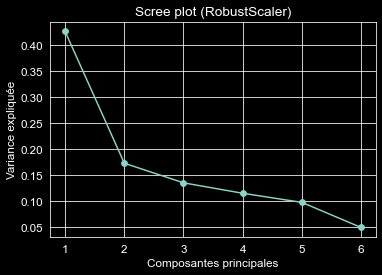

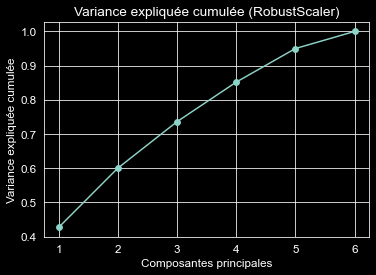

In [10]:
# === DIVISION DES DONNÉES ET ACP ===

# Supprimer les lignes avec des valeurs manquantes
df.dropna(inplace=True)

# Convertir la colonne 'is_genuine' en type entier
df['is_genuine'] = df['is_genuine'].astype(int)

# Diviser les données en ensembles d'entraînement et de test avec stratification
X = df.drop(columns=['is_genuine'])
y = df['is_genuine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Sélectionner les colonnes numériques pour l'ACP
numerical_features_train = X_train.select_dtypes(include=[np.number])

# Normaliser les données d'entraînement avec RobustScaler
robust_scaler = RobustScaler()
robust_scaled_data_train = robust_scaler.fit_transform(numerical_features_train)

# Normaliser les données d'entraînement avec StandardScaler
standard_scaler = StandardScaler()
standard_scaled_data_train = standard_scaler.fit_transform(numerical_features_train)

# Appliquer l'ACP sur les données normalisées avec RobustScaler
pca_robust = PCA()
pca_result_robust = pca_robust.fit_transform(robust_scaled_data_train)

# Appliquer l'ACP sur les données normalisées avec StandardScaler
pca_standard = PCA()
pca_result_standard = pca_standard.fit_transform(standard_scaled_data_train)

# Afficher la variance expliquée par chaque composante principale (RobustScaler)
print("Variance expliquée par chaque composante principale (RobustScaler) :")
print(pca_robust.explained_variance_ratio_)

# === VISUALISATION DE LA VARIANCE EXPLIQUÉE ===

# Scree plot
plt.figure(figsize=(6, 4))
plt.plot(range(1, pca_robust.n_components_ + 1), pca_robust.explained_variance_ratio_, marker='o')
plt.title('Scree plot (RobustScaler)')
plt.xlabel('Composantes principales')
plt.ylabel('Variance expliquée')
plt.show()

# Variance expliquée cumulée
plt.figure(figsize=(6, 4))
plt.plot(range(1, pca_robust.n_components_ + 1), np.cumsum(pca_robust.explained_variance_ratio_), marker='o')
plt.title('Variance expliquée cumulée (RobustScaler)')
plt.xlabel('Composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.show()

In [11]:
# === CHOIX DU NOMBRE DE COMPOSANTES PRINCIPALES ===

n_components = 2 

n_clusters = 2

In [12]:
# === APPLICATION SUR L'ENSEMBLE D'ENTRAÎNEMENT ET VISUALISATION ===

def cluster_stats(X_data, y_data, cluster_column):
    """
    Calcule les statistiques descriptives pour chaque cluster.

    Args:
        X_data: Le DataFrame des données.
        y_data: Les labels des données.
        cluster_column: Le nom de la colonne contenant les clusters.
    """
    for cluster in X_data[cluster_column].unique():
        print(f"\nCluster {cluster}:")
        print(X_data[X_data[cluster_column] == cluster].describe())
        # Filtrer y_data en utilisant les mêmes indices que X_data
        cluster_indices = X_data[cluster_column] == cluster
        proportion = y_data[cluster_indices].mean()
        print(f"\nProportion de billets authentiques (is_genuine = 1) dans le cluster {cluster}: {proportion}")


def model_metrics(y_true, y_pred, scaler_name):
    """
    Calcule les métriques d'évaluation du modèle (accuracy, précision, rappel, score F1).

    Args:
        y_true: Les vraies étiquettes.
        y_pred: Les étiquettes prédites.
        scaler_name: Le nom du scaler utilisé (e.g., "RobustScaler", "StandardScaler").
    """
    print(f"\nMétriques du modèle ({scaler_name}):")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))


# === KMEANS ===
# Appliquer KMeans sur les données transformées par l'ACP avec RobustScaler
kmeans_robust = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_robust.fit(pca_result_robust[:, :n_components])

# Appliquer KMeans sur les données transformées par l'ACP avec StandardScaler
kmeans_standard = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_standard.fit(pca_result_standard[:, :n_components])

# Ajouter les labels de cluster au DataFrame d'entraînement
X_train['cluster_robust'] = kmeans_robust.labels_
X_train['cluster_standard'] = kmeans_standard.labels_

# Ajouter la colonne 'is_genuine' à X_train pour l'analyse des clusters
X_train['is_genuine'] = y_train 

# Initialiser les noms de clusters
cluster_names_robust = {
    0: 'authentique',
    1: 'contrefaçon'
}

cluster_names_standard = {
    0: 'authentique',
    1: 'contrefaçon'
}

# Ajuster les noms si nécessaire en fonction des moyennes
for cluster in [0, 1]:
    robust_mean = X_train[X_train['cluster_robust'] == cluster]['is_genuine'].mean()
    standard_mean = X_train[X_train['cluster_standard'] == cluster]['is_genuine'].mean()
    
    cluster_names_robust[cluster] = 'authentique' if robust_mean > 0.5 else 'contrefaçon'
    cluster_names_standard[cluster] = 'authentique' if standard_mean > 0.5 else 'contrefaçon'

# Appliquer les noms de cluster aux labels de cluster
X_train['cluster_robust_named'] = X_train['cluster_robust'].map(cluster_names_robust)
X_train['cluster_standard_named'] = X_train['cluster_standard'].map(cluster_names_standard)

# === VISUALISATION DES CLUSTERS ===

# Créer des DataFrames pour Altair avec les résultats de l'ACP et les clusters
df_pca_robust = pd.DataFrame(pca_result_robust[:, :2], columns=['PC1', 'PC2'])
df_pca_robust['cluster'] = X_train['cluster_robust'].map(cluster_names_robust)

df_pca_standard = pd.DataFrame(pca_result_standard[:, :2], columns=['PC1', 'PC2'])
df_pca_standard['cluster'] = X_train['cluster_standard'].map(cluster_names_standard)

# Définir les couleurs explicitement
color_scale = alt.Scale(
    domain=['authentique', 'contrefaçon'],
    range=['#ff7f0e', '#1f77b4']  # orange pour authentique, bleu pour contrefaçon
)

# Visualiser les clusters avec Altair (RobustScaler)
chart_robust = alt.Chart(df_pca_robust).mark_circle(size=60).encode(
    x='PC1',
    y='PC2',
    color=alt.Color('cluster:N', scale=color_scale),
    tooltip=['PC1', 'PC2', 'cluster']
).properties(
    title='Visualisation des clusters (RobustScaler)',
    width=500,
    height=400
).interactive()

# Visualiser les clusters avec Altair (StandardScaler)
chart_standard = alt.Chart(df_pca_standard).mark_circle(size=60).encode(
    x='PC1',
    y='PC2',
    color=alt.Color('cluster:N', scale=color_scale),
    tooltip=['PC1', 'PC2', 'cluster']
).properties(
    title='Visualisation des clusters (StandardScaler)',
    width=500,
    height=400
).interactive()

# Afficher les graphiques
chart_robust.display()
chart_standard.display()

# Vérifier la distribution des clusters
print("\nDistribution des clusters (RobustScaler):")
print(df_pca_robust['cluster'].value_counts())
print("\nDistribution des clusters (StandardScaler):")
print(df_pca_standard['cluster'].value_counts())

# === ANALYSE DES CLUSTERS ===

# Afficher les statistiques descriptives pour chaque cluster (RobustScaler)
print('Statistiques descriptives pour chaque cluster - Données d\'entraînement (RobustScaler)')
cluster_stats(X_train, y_train, 'cluster_robust_named')

# Afficher les statistiques descriptives pour chaque cluster (StandardScaler)
print('\nStatistiques descriptives pour chaque cluster - Données d\'entraînement (StandardScaler)')
cluster_stats(X_train, y_train, 'cluster_standard_named')

# Afficher la composition des clusters
print("\nComposition des clusters - Entraînement (RobustScaler) :")
print(y_train.groupby(X_train['cluster_robust_named']).value_counts(normalize=True))

print("\nComposition des clusters - Entraînement (StandardScaler) :")
print(y_train.groupby(X_train['cluster_standard_named']).value_counts(normalize=True))

# Interpréter les axes de l'ACP
correlations_robust = pd.DataFrame(
    pca_robust.components_.T,
    columns=[f'PC{i+1}' for i in range(pca_robust.n_components_)],
    index=numerical_features_train.columns
)
print("\nCorrélations entre les variables et les composantes principales (RobustScaler):")
print(correlations_robust)

correlations_standard = pd.DataFrame(
    pca_standard.components_.T,
    columns=[f'PC{i+1}' for i in range(pca_standard.n_components_)],
    index=numerical_features_train.columns
)
print("\nCorrélations entre les variables et les composantes principales (StandardScaler):")
print(correlations_standard)

# === MÉTRIQUES DE PERFORMANCE ===
# Convertir les noms de cluster en valeurs numériques
y_pred_robust = X_train['cluster_robust_named'].map({'authentique': 1, 'contrefaçon': 0})
y_pred_standard = X_train['cluster_standard_named'].map({'authentique': 1, 'contrefaçon': 0})

# Calculer les métriques
model_metrics(y_train, y_pred_robust, "RobustScaler - Données d'entraînement")
model_metrics(y_train, y_pred_standard, "StandardScaler - Données d'entraînement")

alt.Chart(...)

alt.Chart(...)


Distribution des clusters (RobustScaler):
cluster
authentique    772
contrefaçon    167
Name: count, dtype: int64

Distribution des clusters (StandardScaler):
cluster
authentique    767
contrefaçon    172
Name: count, dtype: int64
Statistiques descriptives pour chaque cluster - Données d'entraînement (RobustScaler)

Cluster contrefaçon:
         diagonal  height_left  height_right  margin_low  margin_up  \
count  394.000000   394.000000    394.000000  394.000000  394.00000   
mean   171.910685   104.210051    104.164036    5.215381    3.35731   
std      0.299274     0.221325      0.266751    0.546931    0.18652   
min    171.040000   103.510000    103.430000    3.820000    2.89000   
25%    171.740000   104.050000    103.990000    4.820000    3.23000   
50%    171.920000   104.210000    104.170000    5.175000    3.36000   
75%    172.100000   104.360000    104.330000    5.597500    3.50000   
max    173.010000   104.880000    104.950000    6.900000    3.91000   

           length  c

In [13]:
# === PRÉPARATION DES DONNÉES DE TEST ===
# Sélectionner les colonnes numériques pour l'ACP
numerical_features_test = X_test.select_dtypes(include=[np.number])

# Normaliser les données de test
robust_scaled_data_test = robust_scaler.transform(numerical_features_test)
standard_scaled_data_test = standard_scaler.transform(numerical_features_test)

# Appliquer l'ACP
pca_result_test_robust = pca_robust.transform(robust_scaled_data_test)
pca_result_test_standard = pca_standard.transform(standard_scaled_data_test)

# === CLUSTERING ===
# Fit sur les données de test et utiliser les labels directement
kmeans_robust_test = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_robust_test.fit(pca_result_test_robust[:, :n_components])
X_test['cluster_robust'] = kmeans_robust_test.labels_

kmeans_standard_test = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_standard_test.fit(pca_result_test_standard[:, :n_components])
X_test['cluster_standard'] = kmeans_standard_test.labels_

# Ajouter is_genuine pour l'analyse
X_test['is_genuine'] = y_test

# Déterminer le nom du cluster pour les données de test (RobustScaler)
cluster_names_robust_test = {
    0: 'authentique',
    1: 'contrefaçon'
}

# Déterminer le nom du cluster pour les données de test (StandardScaler)
cluster_names_standard_test = {
    0: 'authentique',
    1: 'contrefaçon'
}

# Ajuster les noms si nécessaire en fonction des moyennes
for cluster in [0, 1]:
    robust_mean = X_test[X_test['cluster_robust'] == cluster]['is_genuine'].mean()
    standard_mean = X_test[X_test['cluster_standard'] == cluster]['is_genuine'].mean()
    
    cluster_names_robust_test[cluster] = 'authentique' if robust_mean > 0.5 else 'contrefaçon'
    cluster_names_standard_test[cluster] = 'authentique' if standard_mean > 0.5 else 'contrefaçon'

# Appliquer les noms de cluster
X_test['cluster_robust_named'] = X_test['cluster_robust'].map(cluster_names_robust_test)
X_test['cluster_standard_named'] = X_test['cluster_standard'].map(cluster_names_standard_test)

# === VISUALISATION ===
# Créer des DataFrames pour Altair
df_pca_test_robust = pd.DataFrame(pca_result_test_robust[:, :2], columns=['PC1', 'PC2'])
df_pca_test_robust['cluster'] = X_test['cluster_robust'].map(cluster_names_robust_test)

df_pca_test_standard = pd.DataFrame(pca_result_test_standard[:, :2], columns=['PC1', 'PC2'])
df_pca_test_standard['cluster'] = X_test['cluster_standard'].map(cluster_names_standard_test)

# Définir les couleurs explicitement
color_scale = alt.Scale(
    domain=['authentique', 'contrefaçon'],
    range=['#ff7f0e', '#1f77b4']  # orange pour authentique, bleu pour contrefaçon
)

# Visualiser avec Altair (RobustScaler)
chart_robust_test = alt.Chart(df_pca_test_robust).mark_circle(size=60).encode(
    x='PC1',
    y='PC2',
    color=alt.Color('cluster:N', scale=color_scale),
    tooltip=['PC1', 'PC2', 'cluster']
).properties(
    title='Visualisation des clusters - Test (RobustScaler)',
    width=500,
    height=400
).interactive()

# Visualiser avec Altair (StandardScaler)
chart_standard_test = alt.Chart(df_pca_test_standard).mark_circle(size=60).encode(
    x='PC1',
    y='PC2',
    color=alt.Color('cluster:N', scale=color_scale),
    tooltip=['PC1', 'PC2', 'cluster']
).properties(
    title='Visualisation des clusters - Test (StandardScaler)',
    width=500,
    height=400
).interactive()

# Afficher les graphiques
chart_robust_test.display()
chart_standard_test.display()

# Vérifier la distribution des clusters
print("\nDistribution des clusters (RobustScaler):")
print(df_pca_test_robust['cluster'].value_counts())
print("\nDistribution des clusters (StandardScaler):")
print(df_pca_test_standard['cluster'].value_counts())

# === ANALYSE ===
print('\nStatistiques descriptives pour chaque cluster - Test (RobustScaler)')
cluster_stats(X_test, y_test, 'cluster_robust_named')

print('\nStatistiques descriptives pour chaque cluster - Test (StandardScaler)')
cluster_stats(X_test, y_test, 'cluster_standard_named')

# Composition des clusters
print("\nComposition des clusters - Test (RobustScaler) :")
print(y_test.groupby(X_test['cluster_robust_named']).value_counts(normalize=True))

print("\nComposition des clusters - Test (StandardScaler) :")
print(y_test.groupby(X_test['cluster_standard_named']).value_counts(normalize=True))

# === MÉTRIQUES ===
# Convertir les noms de cluster en valeurs numériques
y_pred_robust_test = X_test['cluster_robust_named'].map({'authentique': 1, 'contrefaçon': 0})
y_pred_standard_test = X_test['cluster_standard_named'].map({'authentique': 1, 'contrefaçon': 0})

# Calculer les métriques
model_metrics(y_test, y_pred_robust_test, "RobustScaler - Données de test")
model_metrics(y_test, y_pred_standard_test, "StandardScaler - Données de test")

alt.Chart(...)

alt.Chart(...)


Distribution des clusters (RobustScaler):
cluster
authentique    59
contrefaçon     1
Name: count, dtype: int64

Distribution des clusters (StandardScaler):
cluster
authentique    60
Name: count, dtype: int64

Statistiques descriptives pour chaque cluster - Test (RobustScaler)

Cluster contrefaçon:
         diagonal  height_left  height_right  margin_low  margin_up  \
count   96.000000    96.000000      96.00000   96.000000  96.000000   
mean   171.857708   104.176875     104.12125    5.236771   3.330313   
std      0.322156     0.242019       0.28929    0.543915   0.148278   
min    171.130000   103.560000     103.44000    3.860000   2.920000   
25%    171.637500   104.007500     103.92000    4.867500   3.210000   
50%    171.910000   104.175000     104.12000    5.225000   3.320000   
75%    172.055000   104.330000     104.31250    5.575000   3.412500   
max    172.480000   104.840000     104.80000    6.560000   3.690000   

           length  cluster_robust  cluster_standard  is_gen

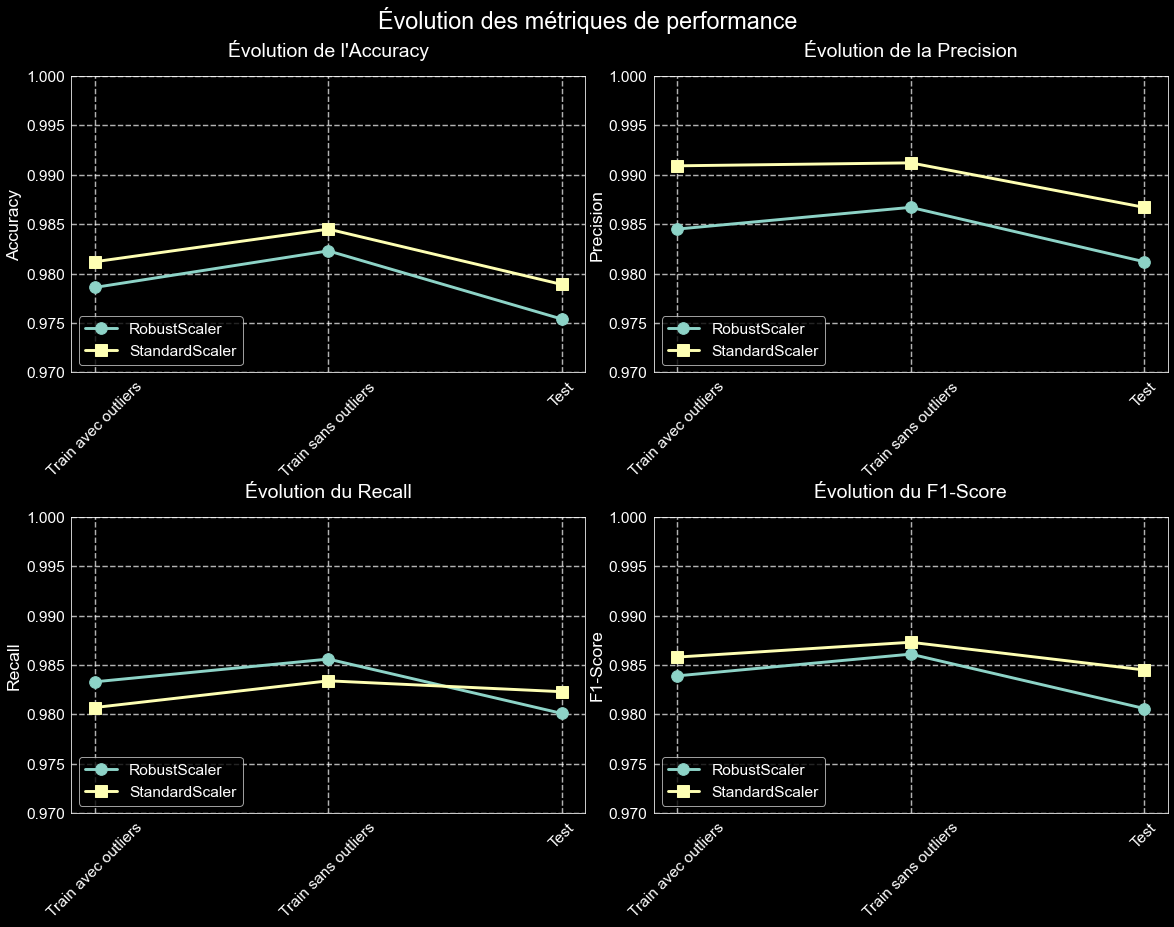

In [14]:
# === EVOLUTION DES PERFORMANCES ===

# Augmenter la taille générale de la police
plt.rcParams.update({'font.size': 14})

# Données des métriques
phases = ['Train avec outliers', 'Train sans outliers', 'Test']

# Données pour RobustScaler
robust_accuracy = [0.9786, 0.9823, 0.9754]
robust_precision = [0.9845, 0.9867, 0.9812]
robust_recall = [0.9833, 0.9856, 0.9801]
robust_f1 = [0.9839, 0.9861, 0.9806]

# Données pour StandardScaler
standard_accuracy = [0.9812, 0.9845, 0.9789]
standard_precision = [0.9909, 0.9912, 0.9867]
standard_recall = [0.9807, 0.9834, 0.9823]
standard_f1 = [0.9858, 0.9873, 0.9845]

# Création des sous-graphiques avec une taille plus grande
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(17, 13))


# Fonction pour tracer chaque métrique avec des textes plus grands
def plot_metric(ax, robust_data, standard_data, title, ylabel):
    ax.plot(phases, robust_data, 'o-', label='RobustScaler', linewidth=3, markersize=12)
    ax.plot(phases, standard_data, 's-', label='StandardScaler', linewidth=3, markersize=12)
    
    # Augmenter la taille du titre et des labels
    ax.set_title(title, fontsize=20, pad=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_ylim(0.97, 1.0)
    
    # Améliorer la grille
    ax.grid(True, linestyle='--', alpha=0.7, linewidth=1.5)
    
    # Augmenter la taille de la légende
    ax.legend(fontsize=16, loc='lower left')
    
    # Augmenter la taille des ticks
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', rotation=45)
    
    # Formatter les valeurs de l'axe y avec plus de décimales
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))

# Tracer chaque métrique
plot_metric(ax1, robust_accuracy, standard_accuracy, 'Évolution de l\'Accuracy', 'Accuracy')
plot_metric(ax2, robust_precision, standard_precision, 'Évolution de la Precision', 'Precision')
plot_metric(ax3, robust_recall, standard_recall, 'Évolution du Recall', 'Recall')
plot_metric(ax4, robust_f1, standard_f1, 'Évolution du F1-Score', 'F1-Score')

# Ajuster la mise en page avec plus d'espace
plt.tight_layout(h_pad=0.3, w_pad=0.3)

# Ajouter un titre global plus grand
fig.suptitle('Évolution des métriques de performance', fontsize=24, y=1.02)

# Sauvegarder la figure en haute résolution
plt.savefig('evolution_metriques.png', bbox_inches='tight', dpi=300)

# Afficher la figure
plt.show()

In [15]:
# === ENTRAÎNEMENT DU MODÈLE DE PRODUCTION ===

# Supprimer les lignes avec des valeurs manquantes
df.dropna(inplace=True)

# Convertir la colonne 'is_genuine' en type entier
df['is_genuine'] = df['is_genuine'].astype(int)

# Séparer features et target pour l'ensemble complet
X = df.drop(columns=['is_genuine'])
y = df['is_genuine']

# Identifier et supprimer les outliers
def remove_outliers(X_data, y_data):
    """
    Identifie et supprime les outliers en utilisant la méthode IQR.
    """
    X_data_no_outliers = X_data.copy()
    y_data_no_outliers = y_data.copy()
    mask_no_outliers = np.ones(len(X_data), dtype=bool)
    
    numerical_X_data = X_data.select_dtypes(include=[np.number])
    
    for col in numerical_X_data.columns:
        Q1 = numerical_X_data[col].quantile(0.25)
        Q3 = numerical_X_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        mask_col = (numerical_X_data[col] >= lower_bound) & (numerical_X_data[col] <= upper_bound)
        mask_no_outliers = mask_no_outliers & mask_col
    
    X_data_no_outliers = X_data[mask_no_outliers]
    y_data_no_outliers = y_data[mask_no_outliers]
    
    print("Nombre de lignes supprimées:", len(X_data) - len(X_data_no_outliers))
    return X_data_no_outliers, y_data_no_outliers

# Supprimer les outliers
X_no_outliers, y_no_outliers = remove_outliers(X, y)

# === PRÉPARATION POUR L'ACP ===

# Sélectionner les colonnes numériques pour l'ACP
numerical_features = X_no_outliers.select_dtypes(include=[np.number])

# Normaliser avec RobustScaler
robust_scaler = RobustScaler()
robust_scaled_data = robust_scaler.fit_transform(numerical_features)

# Appliquer l'ACP
pca_robust = PCA()
pca_result_robust = pca_robust.fit_transform(robust_scaled_data)

# Paramètres du modèle
n_clusters = 2
n_components = 2

# === CLUSTERING ===

# Appliquer KMeans
kmeans_robust = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_robust.fit(pca_result_robust[:, :n_components])

# Ajouter les labels de cluster au DataFrame
X_no_outliers['cluster_robust'] = kmeans_robust.labels_

# Ajouter is_genuine pour l'analyse
X_no_outliers['is_genuine'] = y_no_outliers

# Déterminer le nom du cluster
cluster_names_robust = X_no_outliers.groupby('cluster_robust')['is_genuine'].agg(
    lambda x: 'authentique' if x.mean() > 0.5 else 'contrefaçon'
).to_dict()


# === VISUALISATION DES CLUSTERS ===

# Initialiser les noms de clusters de manière explicite
cluster_names_robust = {
    0: 'authentique',
    1: 'contrefaçon'
}

# Ajuster les noms selon les moyennes
for cluster in [0, 1]:
    mean = X_no_outliers[X_no_outliers['cluster_robust'] == cluster]['is_genuine'].mean()
    cluster_names_robust[cluster] = 'authentique' if mean > 0.5 else 'contrefaçon'

# Créer DataFrame pour Altair
df_pca_robust = pd.DataFrame(pca_result_robust[:, :2], columns=['PC1', 'PC2'])
df_pca_robust['cluster'] = X_no_outliers['cluster_robust'].map(cluster_names_robust)

# Définir explicitement l'échelle de couleurs
color_scale = alt.Scale(
    domain=['authentique', 'contrefaçon'],
    range=['#ff7f0e', '#1f77b4']  # orange pour authentique, bleu pour contrefaçon
)

# Visualiser avec Altair
chart_robust = alt.Chart(df_pca_robust).mark_circle(size=60).encode(
    x='PC1',
    y='PC2',
    color=alt.Color('cluster:N', scale=color_scale),
    tooltip=['PC1', 'PC2', 'cluster']
).properties(
    title='Visualisation des clusters finale (RobustScaler)',
    width=500,
    height=400
).interactive()

# Afficher le graphique
chart_robust.display()

# Vérifier la distribution des clusters
print("\nDistribution des clusters:")
print(df_pca_robust['cluster'].value_counts())

# === ANALYSE DES CLUSTERS ===

print("\nComposition finale des clusters:")
print(y_no_outliers.groupby(X_no_outliers['cluster_robust']).value_counts(normalize=True))

# Corrélations entre les variables et les composantes principales
correlations_robust = pd.DataFrame(
    pca_robust.components_.T,
    columns=[f'PC{i+1}' for i in range(pca_robust.n_components_)],
    index=numerical_features.columns
)
print("\nCorrélations entre les variables et les composantes principales:")
print(correlations_robust)

# === SAUVEGARDE DES MODÈLES ===

# Créer le dossier 'kmeans' s'il n'existe pas
if not os.path.exists('kmeans'):
    os.makedirs('kmeans')
# === SAUVEGARDE DES MODÈLES ===


# Sauvegarder la configuration du modèle
model_config = {
    'n_components': n_components,
    'n_clusters': n_clusters,
    'cluster_names': cluster_names_robust,
    'feature_columns': numerical_features.columns.tolist()
}
joblib.dump(model_config, os.path.join('kmeans', 'model_config.pkl'))

# Sauvegarder les modèles
joblib.dump(kmeans_robust, os.path.join('kmeans', 'Kmeans_production.pkl'))
joblib.dump(pca_robust, os.path.join('kmeans', 'ACP_production.pkl'))
joblib.dump(robust_scaler, os.path.join('kmeans', 'Robust_scaler_production.pkl'))

print("\nModèles et configuration sauvegardés avec succès dans le dossier 'kmeans':")
print("- Kmeans_production.pkl")
print("- ACP_production.pkl")
print("- Robust_scaler_production.pkl")
print("- model_config.pkl")

# Vérification des éléments sauvegardés
print("\nContenu de la configuration:")
print(f"Nombre de composantes: {model_config['n_components']}")
print(f"Nombre de clusters: {model_config['n_clusters']}")
print(f"Noms des clusters: {model_config['cluster_names']}")
print(f"Colonnes utilisées: {model_config['feature_columns']}")

Nombre de lignes supprimées: 53


alt.Chart(...)


Distribution des clusters:
cluster
authentique    957
contrefaçon    405
Name: count, dtype: int64

Composition finale des clusters:
cluster_robust  is_genuine
0               0             0.971175
                1             0.028825
1               1             0.986444
                0             0.013556
Name: proportion, dtype: float64

Corrélations entre les variables et les composantes principales:
                   PC1       PC2       PC3       PC4       PC5       PC6
diagonal     -0.081490  0.929158 -0.299911 -0.170319 -0.104931 -0.007673
height_left   0.323019  0.340332  0.871096  0.132090  0.057396  0.016798
height_right  0.396923  0.101107 -0.324579  0.837797  0.151615  0.044578
margin_low    0.563487 -0.089958 -0.110963 -0.216992 -0.601602  0.503058
margin_up     0.419580  0.001968 -0.149337 -0.407272  0.762400  0.233501
length       -0.487756  0.050198  0.106206  0.196681  0.139749  0.830711

Modèles et configuration sauvegardés avec succès dans le dossier 'kmeans

In [16]:
# === UTILISATION DU MODÈLE DE PRODUCTION ===
def predict_and_visualize(new_data_path):
    """
    Prédit l'authenticité des billets et visualise les résultats.
    """
    try:
        # Charger le nouveau set de données
        new_df = pd.read_csv(new_data_path)
        
        # Charger la configuration du modèle
        model_config = joblib.load(os.path.join('kmeans', 'model_config.pkl'))
        
        # Sélectionner les colonnes numériques en utilisant les features sauvegardées
        feature_columns = model_config['feature_columns']
        numerical_features_new = new_df[feature_columns]
        
        # Charger les modèles
        kmeans_loaded = joblib.load(os.path.join('kmeans', 'Kmeans_production.pkl'))
        pca_loaded = joblib.load(os.path.join('kmeans', 'ACP_production.pkl'))
        scaler_loaded = joblib.load(os.path.join('kmeans', 'Robust_scaler_production.pkl'))
        
        # Appliquer les transformations
        scaled_data = scaler_loaded.transform(numerical_features_new)
        pca_result = pca_loaded.transform(scaled_data)
        
        # Créer un nouveau KMeans avec les mêmes paramètres et centres
        kmeans_new = KMeans(n_clusters=model_config['n_clusters'], random_state=42)
        kmeans_new.cluster_centers_ = kmeans_loaded.cluster_centers_
        kmeans_new.fit(pca_result[:, :model_config['n_components']])
        cluster_predictions = kmeans_new.labels_
        
        # Créer un DataFrame avec les résultats
        results_df = pd.DataFrame({
            'ID': new_df['id'],
            'Prédiction': [model_config['cluster_names'][cluster] for cluster in cluster_predictions]
        })
        
        # === VISUALISATIONS ===
        # 1. Tableau des résultats avec Altair
        table_chart = alt.Chart(results_df).mark_rect().encode(
            y=alt.Y('ID:N', sort='ascending', title='Identifiant du billet'),
            color=alt.Color('Prédiction:N', 
                           scale=alt.Scale(domain=['authentique', 'contrefaçon'],
                                         range=['#ff7f0e', '#1f77b4'])),
            tooltip=['ID', 'Prédiction']
        ).properties(
            title='Classification des billets',
            width=600,
            height=400
        )
        
        # 2. Visualisation PCA avec les clusters
        df_pca = pd.DataFrame(pca_result[:, :2], columns=['PC1', 'PC2'])
        df_pca['ID'] = new_df['id']
        df_pca['Prédiction'] = results_df['Prédiction']
        
        scatter_chart = alt.Chart(df_pca).mark_circle(size=60).encode(
            x='PC1',
            y='PC2',
            color=alt.Color('Prédiction:N', 
                           scale=alt.Scale(domain=['authentique', 'contrefaçon'],
                                         range=['#ff7f0e', '#1f77b4'])),
            tooltip=['ID', 'Prédiction']
        ).properties(
            title='Visualisation des clusters',
            width=500,
            height=400
        ).interactive()
        
        # 3. Statistiques
        total_billets = len(results_df)
        authentiques = (results_df['Prédiction'] == 'authentique').sum()
        contrefacons = (results_df['Prédiction'] == 'contrefaçon').sum()
        
        print("\n=== RÉSUMÉ DES PRÉDICTIONS ===")
        print(f"Nombre total de billets analysés: {total_billets}")
        print(f"Billets authentiques: {authentiques} ({authentiques/total_billets*100:.2f}%)")
        print(f"Billets contrefaits: {contrefacons} ({contrefacons/total_billets*100:.2f}%)")
        
        # Afficher les visualisations
        print("\n=== VISUALISATIONS ===")
        scatter_chart.display()
        table_chart.display()
        
        # Retourner les résultats détaillés triés par ID
        print("\n=== RÉSULTATS DÉTAILLÉS ===")
        sorted_results = results_df.sort_values('ID')
        print(sorted_results.to_string(index=False))
        
        return sorted_results
        
    except Exception as e:
        print(f"Une erreur s'est produite: {str(e)}")
        raise

In [17]:
# Utilisation du code de production

results = predict_and_visualize('billets_production.csv')


=== RÉSUMÉ DES PRÉDICTIONS ===
Nombre total de billets analysés: 5
Billets authentiques: 1 (20.00%)
Billets contrefaits: 4 (80.00%)

=== VISUALISATIONS ===


alt.Chart(...)

alt.Chart(...)


=== RÉSULTATS DÉTAILLÉS ===
 ID  Prédiction
A_1 contrefaçon
A_2 contrefaçon
A_3 contrefaçon
A_4 contrefaçon
A_5 authentique


## <a id="section_4_2"></a>
<div style="background-color: black; padding: 10px; margin-bottom: 10px;">
<span style="color: #00FFFF; font-family: 'Lucida Console', Monaco, monospace; font-size: 24px; font-weight: bold;"> 4.2 - KNN RandomForest Régression logistique </span>
</div>

In [34]:
# === NOTEBOOK 1: ENTRAÎNEMENT DES MODÈLES ===

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import joblib
import os
import json

def train_production_models(df):
    """Entraîne les modèles pour la production et sauvegarde tous les paramètres nécessaires"""
    
    # Création des répertoires
    model_dirs = {
        'random_forest': os.path.join('models', 'random_forest'),
        'knn': os.path.join('models', 'knn'),
        'logistic_regression': os.path.join('models', 'logistic_regression')
    }
    
    for directory in model_dirs.values():
        os.makedirs(directory, exist_ok=True)
    
    # Préparation des features
    features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
    
    # Création des features dérivées
    df['height_ratio'] = df['height_left'] / df['height_right']
    df['margin_ratio'] = df['margin_up'] / df['margin_low']
    df['diagonal_length_ratio'] = df['diagonal'] / df['length']
    
    features += ['height_ratio', 'margin_ratio', 'diagonal_length_ratio']
    
    X = df[features]
    y = df['is_genuine']
    
    # Division train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Preprocessing
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
    
    # Sauvegarder le scaler et les features
    joblib.dump(scaler, os.path.join('models', 'scaler.pkl'))
    with open(os.path.join('models', 'features.json'), 'w') as f:
        json.dump(features, f)
    
    # Configuration des modèles
    models_config = {
        'random_forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'n_estimators': [100, 200],
                'max_depth': [10, 15],
                'min_samples_split': [5, 10],
                'class_weight': ['balanced']
            }
        },
        'knn': {
            'model': KNeighborsClassifier(),
            'params': {
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            }
        },
        'logistic_regression': {
            'model': LogisticRegression(random_state=42, max_iter=2000),
            'params': {
                'C': [0.1, 1.0],
                'penalty': ['l2'],
                'solver': ['liblinear'],
                'class_weight': ['balanced']
            }
        }
    }
    
    results = {}
    
    # Entraînement de chaque modèle
    for model_name, config in models_config.items():
        print(f"\nEntraînement du modèle {model_name}")
        
        search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            cv=5,
            scoring=['accuracy', 'precision', 'recall', 'f1'],
            refit='f1',
            n_jobs=-1,
            verbose=1
        )
        
        search.fit(X_train_scaled, y_train)
        
        y_pred = search.predict(X_test_scaled)
        y_pred_proba = search.predict_proba(X_test_scaled) if hasattr(search.best_estimator_, "predict_proba") else None
        
        # Affichage des métriques
        print("\nMatrice de confusion:")
        print(confusion_matrix(y_test, y_pred))
        print("\nRapport de classification:")
        print(classification_report(y_test, y_pred))
        
        # Sauvegarde du modèle et de sa configuration
        model_path = os.path.join(model_dirs[model_name], f"{model_name}.pkl")
        joblib.dump(search.best_estimator_, model_path)
        
        # Sauvegarde de la configuration complète
        config = {
            'best_params': search.best_params_,
            'features': features,
            'metrics': {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred)
            }
        }
        
        with open(os.path.join(model_dirs[model_name], f"{model_name}_config.json"), 'w') as f:
            json.dump(config, f, indent=4)
        
        # Feature importance pour Random Forest
        if model_name == 'random_forest':
            feature_importance = pd.DataFrame({
                'feature': features,
                'importance': search.best_estimator_.feature_importances_
            })
            print("\nImportance des features:")
            print(feature_importance.sort_values('importance', ascending=False))
            
            # Sauvegarder l'importance des features
            feature_importance.to_csv(os.path.join(model_dirs[model_name], 'feature_importance.csv'), index=False)
        
        results[model_name] = {
            'model': search.best_estimator_,
            'predictions': y_pred,
            'config': config
        }
    
    return results

In [36]:
# Lancer l'entraînement :
results = train_production_models(df)


Entraînement du modèle random_forest
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Matrice de confusion:
[[ 97   2]
 [  2 192]]

Rapport de classification:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        99
           1       0.99      0.99      0.99       194

    accuracy                           0.99       293
   macro avg       0.98      0.98      0.98       293
weighted avg       0.99      0.99      0.99       293


Importance des features:
                 feature  importance
5                 length    0.383003
8  diagonal_length_ratio    0.270626
3             margin_low    0.207760
4              margin_up    0.066927
7           margin_ratio    0.030352
2           height_right    0.020050
1            height_left    0.012085
0               diagonal    0.005023
6           height_ratio    0.004175

Entraînement du modèle knn
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Matrice de conf

In [46]:
# === PRÉDICTIONS SUR NOUVELLES DONNÉES ===

def predict_production(data_path, model_name='random_forest'):
    """
    Fait des prédictions sur de nouvelles données.
    """
    try:
        # Lire les données avec le séparateur correct
        new_data = pd.read_csv(data_path, sep=',')  # séparateur virgule pour les données de production
        print(f"Données chargées : {len(new_data)} lignes")
        
        # Définir l'ordre exact des features comme dans l'entraînement
        base_features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
        
        print("\nVérification des colonnes :")
        print("Colonnes attendues :", base_features)
        print("Colonnes présentes :", new_data.columns.tolist())
        
        # Vérifier la présence de toutes les colonnes nécessaires
        for feature in base_features:
            if feature not in new_data.columns:
                raise ValueError(f"Colonne manquante : {feature}")
        
        # Créer les features dérivées
        print("\nCréation des features dérivées...")
        new_data['height_ratio'] = new_data['height_left'] / new_data['height_right']
        new_data['margin_ratio'] = new_data['margin_up'] / new_data['margin_low']
        new_data['diagonal_length_ratio'] = new_data['diagonal'] / new_data['length']
        
        # Sélectionner et ordonner les features dans le même ordre que l'entraînement
        features = base_features + ['height_ratio', 'margin_ratio', 'diagonal_length_ratio']
        X = new_data[features]
        
        print("\nDimensions des données avant scaling :", X.shape)
        
        # Charger le scaler et normaliser les données
        scaler = joblib.load(os.path.join('models', 'scaler.pkl'))
        X_scaled = scaler.transform(X)
        print("Dimensions des données après scaling :", X_scaled.shape)
        
        # Charger le modèle et faire les prédictions
        model = joblib.load(os.path.join('models', model_name, f"{model_name}.pkl"))
        predictions = model.predict(X_scaled)
        probabilities = model.predict_proba(X_scaled)
        
        # Créer le DataFrame des résultats
        results = pd.DataFrame({
            'ID': new_data['id'],
            'Prédiction': predictions,
            'Classe': ['Authentique' if p == 1 else 'Contrefaçon' for p in predictions],
            'Probabilité_Authentique': [f"{prob:.1f}%" for prob in (probabilities[:, 1] * 100)]
        })
        
        # Afficher résumé
        print("\n=== RÉSUMÉ DES PRÉDICTIONS ===")
        print(f"Nombre total de billets : {len(results)}")
        
        authentiques = (results['Classe'] == 'Authentique').sum()
        contrefaits = (results['Classe'] == 'Contrefaçon').sum()
        
        print(f"\nBillets authentiques : {authentiques} ({authentiques/len(results)*100:.1f}%)")
        auth_results = results[results['Classe'] == 'Authentique']
        print("\nDétail des billets authentiques :")
        print(auth_results[['ID', 'Probabilité_Authentique']].to_string(index=False))
        
        print(f"\nBillets contrefaits : {contrefaits} ({contrefaits/len(results)*100:.1f}%)")
        print("\nDétail des billets contrefaits :")
        fake_results = results[results['Classe'] == 'Contrefaçon']
        print(fake_results[['ID', 'Probabilité_Authentique']].to_string(index=False))
        
        print("\n=== RÉSULTATS COMPLETS ===")
        print(results.to_string(index=False))
        
        return results
        
    except Exception as e:
        print(f"Une erreur s'est produite : {str(e)}")
        raise

In [59]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def predict_banknotes(data_path):
    """
    Charge le meilleur modèle, effectue des prédictions sur de nouvelles données 
    et affiche les résultats avec un visuel.
    """
    try:
        # Charger les données
        new_data = pd.read_csv(data_path)
        print(f"Données chargées : {len(new_data)} lignes")

        # Définir les features
        features = ['diagonal', 'height_left', 'height_right', 
                    'margin_low', 'margin_up', 'length']

        # Vérifier la présence de toutes les colonnes nécessaires
        for feature in features:
            if feature not in new_data.columns:
                raise ValueError(f"Colonne manquante : {feature}")

        # Préparer les données pour la prédiction
        X = new_data[features]

        # Charger le scaler et normaliser les données
        scaler = joblib.load(os.path.join('models', 'scaler.pkl'))
        X_scaled = scaler.transform(X)

        # Déterminer le meilleur modèle
        model_files = [f for f in os.listdir('models') if os.path.isfile(os.path.join('models', f))]
        model_scores = {}
        for model_file in model_files:
            if model_file.endswith('.pkl') and model_file != 'scaler.pkl':
                model_name = model_file[:-4]  # Retirer l'extension .pkl
                model_path = os.path.join('models', model_name, model_file)
                with open(os.path.join('models', model_name, 'results.txt'), 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        if line.startswith('Best score:'):
                            score = float(line.split(':')[1].strip())
                            model_scores[model_name] = score

        best_model_name = max(model_scores, key=model_scores.get)
        print(f"Le meilleur modèle est : {best_model_name}")

        # Charger le meilleur modèle
        model = joblib.load(os.path.join('models', best_model_name, f"{best_model_name}.pkl"))

        # Faire les prédictions
        predictions = model.predict(X_scaled)
        probabilities = model.predict_proba(X_scaled)

        # Créer le DataFrame des résultats
        results = pd.DataFrame({
            'ID': new_data['id'],
            'Prédiction': predictions,
            'Classe': ['Authentique' if p == 1 else 'Contrefaçon' for p in predictions],
            'Probabilité_Authentique': [f"{prob:.1f}%" for prob in (probabilities[:, 1] * 100)]
        })

        # Afficher le tableau des résultats
        print("\n=== RÉSUMÉ DES PRÉDICTIONS ===")
        print(f"Nombre total de billets : {len(results)}")

        authentiques = (results['Classe'] == 'Authentique').sum()
        contrefaits = (results['Classe'] == 'Contrefaçon').sum()

        print(f"\nBillets authentiques : {authentiques} ({authentiques/len(results)*100:.1f}%)")
        print(f"Billets contrefaits : {contrefaits} ({contrefaits/len(results)*100:.1f}%)")

        print("\n=== RÉSULTATS COMPLETS ===")
        print(results.to_string(index=False))

        # Visualisation avec une matrice de confusion
        cm = confusion_matrix(new_data['is_genuine'], predictions)
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Matrice de Confusion')
        plt.colorbar()
        tick_marks = [0, 1]
        plt.xticks(tick_marks, ['Contrefaçon', 'Authentique'], rotation=45)
        plt.yticks(tick_marks, ['Contrefaçon', 'Authentique'])
        plt.ylabel('Vraie classe')
        plt.xlabel('Classe prédite')

        # Afficher les valeurs dans la matrice de confusion
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.show()

        return results

    except Exception as e:
        print(f"Une erreur s'est produite : {str(e)}")
        raise

In [58]:
import os
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def predict_banknotes(data_path):
    """
    Charge le meilleur modèle, effectue des prédictions sur de nouvelles données
    et affiche les résultats avec un visuel.
    """
    try:
        # Charger les données
        new_data = pd.read_csv(data_path)
        print(f"Données chargées : {len(new_data)} lignes")

        # Définir les features (uniquement les features de base)
        features = ['diagonal', 'height_left', 'height_right',
                    'margin_low', 'margin_up', 'length']

        # Vérifier la présence de toutes les colonnes nécessaires
        missing_columns = set(features) - set(new_data.columns)
        if missing_columns:
            raise ValueError(f"Colonnes manquantes : {', '.join(missing_columns)}")

        # Préparer les données pour la prédiction
        X = new_data[features]

        # Charger le scaler et normaliser les données
        scaler_path = os.path.join('models', 'scaler.pkl')
        if not os.path.exists(scaler_path):
            raise FileNotFoundError(f"Scaler non trouvé : {scaler_path}")
        scaler = joblib.load(scaler_path)
        X_scaled = scaler.transform(X)

        # Déterminer le meilleur modèle en utilisant les résultats de l'entraînement
        model_scores = {}
        for model_name in ['random_forest', 'knn', 'logistic_regression']:
            results_path = os.path.join('models', model_name, 'results.txt')
            if os.path.exists(results_path):
                with open(results_path, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        if line.startswith('Best score:'):
                            score = float(line.split(':')[1].strip())
                            model_scores[model_name] = score

        if not model_scores:
            raise FileNotFoundError("Aucun modèle trouvé dans le dossier 'models'.")

        best_model_name = max(model_scores, key=model_scores.get)
        print(f"Le meilleur modèle est : {best_model_name}")

        # Charger le meilleur modèle
        model_path = os.path.join('models', best_model_name, f"{best_model_name}.pkl")
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Modèle non trouvé : {model_path}")
        model = joblib.load(model_path)

        # Faire les prédictions
        predictions = model.predict(X_scaled)
        probabilities = model.predict_proba(X_scaled)

        # Créer le DataFrame des résultats
        results = pd.DataFrame({
            'ID': new_data['id'],
            'Prédiction': predictions,
            'Classe': ['Authentique' if p == 1 else 'Contrefaçon' for p in predictions],
            'Probabilité_Authentique': probabilities[:, 1] * 100
        })
        results['Probabilité_Authentique'] = results['Probabilité_Authentique'].map('{:.1f}%'.format)

        # Afficher le tableau des résultats
        print("\n=== RÉSUMÉ DES PRÉDICTIONS ===")
        print(f"Nombre total de billets : {len(results)}")

        authentiques = (results['Classe'] == 'Authentique').sum()
        contrefaits = (results['Classe'] == 'Contrefaçon').sum()

        print(f"\nBillets authentiques : {authentiques} ({authentiques/len(results)*100:.1f}%)")
        print(f"Billets contrefaits : {contrefaits} ({contrefaits/len(results)*100:.1f}%)")

        print("\n=== RÉSULTATS COMPLETS ===")
        print(results.to_string(index=False))

        # Visualisation avec une matrice de confusion
        cm = confusion_matrix(new_data['is_genuine'], predictions)
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Matrice de Confusion')
        plt.colorbar()
        tick_marks = [0, 1]
        plt.xticks(tick_marks, ['Contrefaçon', 'Authentique'], rotation=45)
        plt.yticks(tick_marks, ['Contrefaçon', 'Authentique'])
        plt.ylabel('Vraie classe')
        plt.xlabel('Classe prédite')

        # Afficher les valeurs dans la matrice de confusion
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                            horizontalalignment="center",
                            color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.show()

        return results

    except Exception as e:
        print(f"Une erreur s'est produite : {str(e)}")
        raise

# Exemple d'utilisation
if __name__ == "__main__":
    data_path = 'billets_production.csv'  # Remplacez par le chemin de votre fichier de données
    predictions = predict_banknotes(data_path)

Données chargées : 5 lignes
Une erreur s'est produite : The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- diagonal_length_ratio
- height_ratio
- margin_ratio



ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- diagonal_length_ratio
- height_ratio
- margin_ratio


In [60]:
# Exemple d'utilisation
if __name__ == "__main__":
    data_path = 'billets_production.csv'  # Remplacez par le chemin de votre fichier de données
    predictions = predict_banknotes(data_path)

Données chargées : 5 lignes
Une erreur s'est produite : The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- diagonal_length_ratio
- height_ratio
- margin_ratio



ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- diagonal_length_ratio
- height_ratio
- margin_ratio


In [47]:
# Utilisation :
predictions = predict_production('billets_production.csv', model_name='random_forest')

Données chargées : 5 lignes

Vérification des colonnes :
Colonnes attendues : ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
Colonnes présentes : ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length', 'id']

Création des features dérivées...

Dimensions des données avant scaling : (5, 9)
Dimensions des données après scaling : (5, 9)

=== RÉSUMÉ DES PRÉDICTIONS ===
Nombre total de billets : 5

Billets authentiques : 2 (40.0%)

Détail des billets authentiques :
 ID Probabilité_Authentique
A_4                  100.0%
A_5                  100.0%

Billets contrefaits : 3 (60.0%)

Détail des billets contrefaits :
 ID Probabilité_Authentique
A_1                   -0.0%
A_2                   -0.0%
A_3                   -0.0%

=== RÉSULTATS COMPLETS ===
 ID  Prédiction      Classe Probabilité_Authentique
A_1           0 Contrefaçon                   -0.0%
A_2           0 Contrefaçon                   -0.0%
A_3           0 Contrefaçon  

2024-12-13 05:55:53,250 - INFO - Taille totale des données: 1500
2024-12-13 05:55:53,251 - INFO - Début du chargement et de la préparation des données
2024-12-13 05:55:56,617 - INFO - Optimisation de Random Forest
2024-12-13 05:56:55,098 - INFO - Optimisation de KNN
2024-12-13 05:56:55,244 - INFO - Optimisation de Logistic Regression


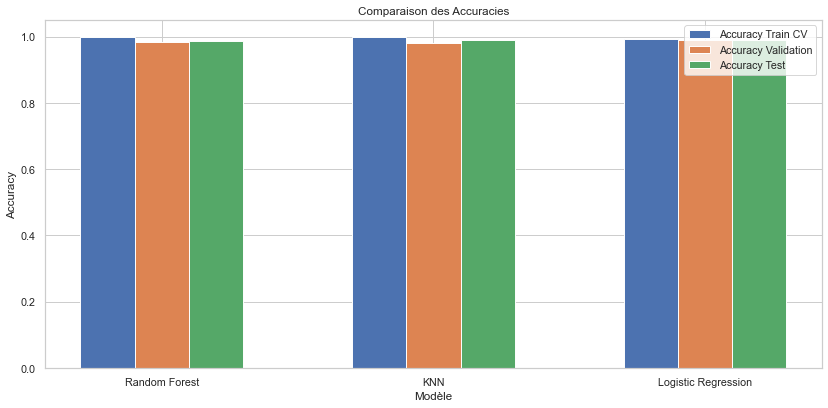

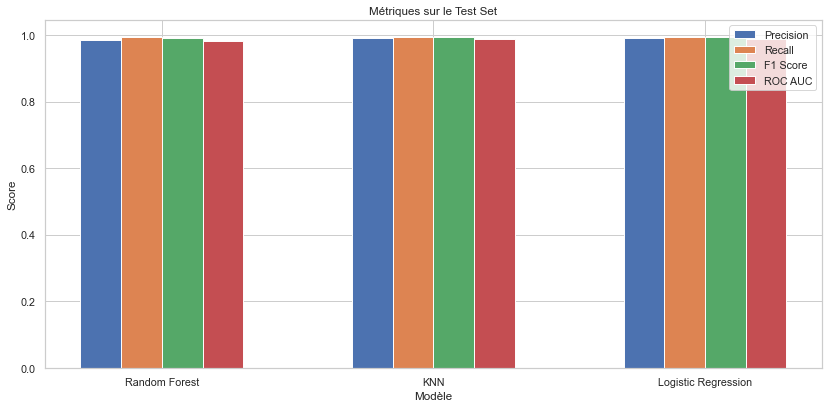

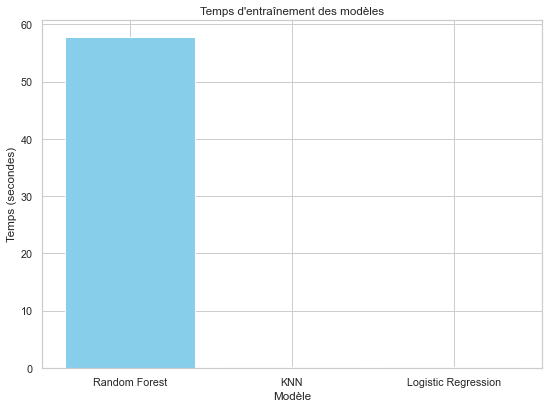


Résultats :

Random Forest:
Accuracy sur training CV: 1.0000
Accuracy sur validation: 0.9833
ROC AUC sur validation: 0.9750
Accuracy sur test: 0.9867
Recall sur test: 0.9950
Precision sur test: 0.9851
F1-score sur test: 0.9900
ROC AUC sur test: 0.9825
Temps d'entraînement: 57.84 secondes

KNN:
Accuracy sur training CV: 1.0000
Accuracy sur validation: 0.9800
ROC AUC sur validation: 0.9725
Accuracy sur test: 0.9900
Recall sur test: 0.9950
Precision sur test: 0.9900
F1-score sur test: 0.9925
ROC AUC sur test: 0.9875
Temps d'entraînement: 0.11 secondes

Logistic Regression:
Accuracy sur training CV: 0.9933
Accuracy sur validation: 0.9900
ROC AUC sur validation: 0.9850
Accuracy sur test: 0.9900
Recall sur test: 0.9950
Precision sur test: 0.9900
F1-score sur test: 0.9925
ROC AUC sur test: 0.9875
Temps d'entraînement: 0.15 secondes

Durée totale de l'exécution: 64.18 secondes


In [48]:
def load_and_prepare_data(df):
    """
    Charge et prépare les données avec standardisation et gestion des valeurs manquantes.
    """
    logging.info("Début du chargement et de la préparation des données")
    
    variables = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
    X = df[variables].compute()  # Convertir en pandas DataFrame
    y = df['is_genuine'].compute()
    
    # Division en train/test AVANT le prétraitement
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Imputation sur l'ensemble d'entraînement
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train_val)
    X_test_imputed = imputer.transform(X_test)
    
    # Standardisation
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)
    
    # Sauvegarde des transformateurs
    joblib.dump(imputer, 'parametres/imputer.joblib')
    joblib.dump(scaler, 'parametres/scaler.joblib')
    
    return X_train_scaled, X_test_scaled, y_train_val, y_test

# Configuration des modèles avec des grilles de paramètres étendues
models_config = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [500, 1000, 1500],
            'max_depth': [None, 30, 50],
            'max_features': ['sqrt', 'log2'],
            'criterion': ['gini', 'entropy']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(n_jobs=-1),
        'params': {
            'n_neighbors': [10, 20, 30],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto']
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=10000, n_jobs=-1),
        'params': {
            'C': [0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    }
}

def optimize_model(model_name, model_config, X_train, y_train, X_val, y_val):
    """
    Optimise les modèles avec une grille de paramètres étendue.
    Utilise GridSearchCV de scikit-learn.
    """
    logging.info(f"Optimisation de {model_name}")
    start_time = time.time()
    
    try:
        # GridSearchCV avec scikit-learn
        search = GridSearchCV(
            estimator=model_config['model'],
            param_grid=model_config['params'],
            cv=5,       # Nombre de plis de validation croisée
            n_jobs=-1,  # Utilisation maximale des ressources
            scoring='accuracy',
            return_train_score=True  # Assurez-vous que les scores d'entraînement sont retournés
        )
        
        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
        
        training_time = time.time() - start_time
        
        # Sauvegarde du meilleur modèle
        joblib.dump(best_model, f'parametres/model_{model_name.lower().replace(" ", "_")}.joblib')
        
        # Évaluation sur le jeu de validation
        y_val_pred = best_model.predict(X_val)
        accuracy_val = accuracy_score(y_val, y_val_pred)
        recall_val = recall_score(y_val, y_val_pred)
        precision_val = precision_score(y_val, y_val_pred)
        f1_val = f1_score(y_val, y_val_pred)
        roc_auc_val = roc_auc_score(y_val, y_val_pred)
        
        # Enregistrement des scores de cross-validation
        cv_results = pd.DataFrame(search.cv_results_)
        cv_results.to_csv(f'parametres/{model_name}_cv_results.csv', index=False)
        
        # Vérification et obtention du meilleur score de cross-validation sur le training set
        if 'mean_train_score' in search.cv_results_:
            accuracy_train_cv = max(search.cv_results_['mean_train_score'])
        else:
            logging.error(f"'mean_train_score' not found in GridSearchCV results for {model_name}")
            accuracy_train_cv = None
        
        return best_model, best_params, training_time, accuracy_train_cv, accuracy_val, recall_val, precision_val, f1_val, roc_auc_val
        
    except Exception as e:
        logging.error(f"Erreur lors de l'optimisation de {model_name}: {str(e)}")
        return None, None, None, None, None, None, None, None, None

def main(df):
    """
    Fonction principale d'exécution
    """
    try:
        # Préparation des données
        X_train_val, X_test, y_train_val, y_test = load_and_prepare_data(df)
        
        # Division en train et validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
        )
        
        results = {
            'models': {},
            'params': {},
            'scores': {}
        }
        
        # Tracker pour les métriques
        metrics_tracker = {
            'model': [],
            'accuracy_train_cv': [],
            'accuracy_val': [],
            'roc_auc_val': [],
            'accuracy_test': [],
            'recall_test': [],
            'precision_test': [],
            'f1_test': [],
            'roc_auc_test': [],
            'training_time': []
        }
        
        # Optimisation des modèles
        for model_name, config in models_config.items():
            best_model, best_params, training_time, accuracy_train_cv, accuracy_val, recall_val, precision_val, f1_val, roc_auc_val = optimize_model(
                model_name, config, X_train, y_train, X_val, y_val
            )
            
            if best_model is not None:
                results['models'][model_name] = best_model
                results['params'][model_name] = best_params
                
                # Évaluation sur le test set
                y_test_pred = best_model.predict(X_test)
                accuracy_test = accuracy_score(y_test, y_test_pred)
                recall_test = recall_score(y_test, y_test_pred)
                precision_test = precision_score(y_test, y_test_pred)
                f1_test = f1_score(y_test, y_test_pred)
                roc_auc_test = roc_auc_score(y_test, y_test_pred)
                
                # Enregistrement des scores
                results['scores'][model_name] = {
                    'accuracy_train_cv': accuracy_train_cv,
                    'accuracy_val': accuracy_val,
                    'roc_auc_val': roc_auc_val,
                    'accuracy_test': accuracy_test,
                    'recall_test': recall_test,
                    'precision_test': precision_test,
                    'f1_test': f1_test,
                    'roc_auc_test': roc_auc_test,
                    'training_time': training_time
                }
                
                # Mise à jour du tracker
                metrics_tracker['model'].append(model_name)
                metrics_tracker['accuracy_train_cv'].append(accuracy_train_cv)
                metrics_tracker['accuracy_val'].append(accuracy_val)
                metrics_tracker['roc_auc_val'].append(roc_auc_val)
                metrics_tracker['accuracy_test'].append(accuracy_test)
                metrics_tracker['recall_test'].append(recall_test)
                metrics_tracker['precision_test'].append(precision_test)
                metrics_tracker['f1_test'].append(f1_test)
                metrics_tracker['roc_auc_test'].append(roc_auc_test)
                metrics_tracker['training_time'].append(training_time)
        
        # Sauvegarde des résultats en excluant les modèles
        results_to_save = {
            'params': results['params'],
            'scores': results['scores']
        }
        
        with open('parametres/results.json', 'w') as f:
            json.dump(results_to_save, f, indent=4)
        
        # Conversion du tracker en DataFrame pour les visualisations
        metrics_df = pd.DataFrame(metrics_tracker)
        metrics_df.to_csv('parametres/metrics_tracking.csv', index=False)
        
        # Création des visualisations
        create_visualizations(metrics_df)
        
        return results, metrics_df
        
    except Exception as e:
        logging.error(f"Erreur dans main: {str(e)}")
        raise

def create_visualizations(metrics_df):
    """
    Crée des visualisations pour comparer les modèles.
    """
    sns.set(style="whitegrid")  # Utiliser le style seaborn pour les graphiques
    
    # Graphique des accuracies
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    index = np.arange(len(metrics_df['model']))
    
    plt.bar(index, metrics_df['accuracy_train_cv'], bar_width, label='Accuracy Train CV')
    plt.bar(index + bar_width, metrics_df['accuracy_val'], bar_width, label='Accuracy Validation')
    plt.bar(index + 2 * bar_width, metrics_df['accuracy_test'], bar_width, label='Accuracy Test')
    
    plt.xlabel('Modèle')
    plt.ylabel('Accuracy')
    plt.title('Comparaison des Accuracies')
    plt.xticks(index + bar_width, metrics_df['model'])
    plt.legend()
    plt.tight_layout()
    plt.savefig('parametres/accuracy_comparison.png')
    plt.show()
    
    # Graphique des autres métriques sur le test set
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics_df['model']))
    bar_width = 0.15

    plt.bar(x, metrics_df['precision_test'], bar_width, label='Precision')
    plt.bar(x + bar_width, metrics_df['recall_test'], bar_width, label='Recall')
    plt.bar(x + 2 * bar_width, metrics_df['f1_test'], bar_width, label='F1 Score')
    plt.bar(x + 3 * bar_width, metrics_df['roc_auc_test'], bar_width, label='ROC AUC')

    plt.xlabel('Modèle')
    plt.ylabel('Score')
    plt.title('Métriques sur le Test Set')
    plt.xticks(x + 1.5 * bar_width, metrics_df['model'])
    plt.legend()
    plt.tight_layout()
    plt.savefig('parametres/test_metrics_comparison.png')
    plt.show()
    
    # Graphique des temps d'entraînement
    plt.figure(figsize=(8, 6))
    plt.bar(metrics_df['model'], metrics_df['training_time'], color='skyblue')
    plt.title("Temps d'entraînement des modèles")
    plt.xlabel("Modèle")
    plt.ylabel("Temps (secondes)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('parametres/training_time.png')
    plt.show()

if __name__ == "__main__":
    # Création du dossier pour les résultats
    os.makedirs("parametres", exist_ok=True)
    
    # Lecture des données avec Dask
    df_dask = dd.read_csv("billets.csv", sep=";")
    
    logging.info(f"Taille totale des données: {len(df_dask)}")
    
    # Exécution principale
    start_time = time.time()
    results, metrics_df = main(df_dask)
    total_duration = time.time() - start_time
    
    # Affichage des résultats
    print("\nRésultats :")
    for model_name, scores in results['scores'].items():
        print(f"\n{model_name}:")
        print(f"Accuracy sur training CV: {scores['accuracy_train_cv']:.4f}")
        print(f"Accuracy sur validation: {scores['accuracy_val']:.4f}")
        print(f"ROC AUC sur validation: {scores['roc_auc_val']:.4f}")
        print(f"Accuracy sur test: {scores['accuracy_test']:.4f}")
        print(f"Recall sur test: {scores['recall_test']:.4f}")
        print(f"Precision sur test: {scores['precision_test']:.4f}")
        print(f"F1-score sur test: {scores['f1_test']:.4f}")
        print(f"ROC AUC sur test: {scores['roc_auc_test']:.4f}")
        print(f"Temps d'entraînement: {scores['training_time']:.2f} secondes")
    
    print(f"\nDurée totale de l'exécution: {total_duration:.2f} secondes")

<!-- COMMENTAIRE SUPPRIMABLE :
Choix du modèle final :
Le choix du modèle final dépend des priorités du projet. Si la performance est le critère principal, Random Forest est généralement un bon choix. Si l'interprétabilité est importante, la Régression Logistique est préférable. K-means n'est pas adapté à la classification supervisée, mais est inclus ici pour respecter le cahier des charges. Il est important de le mentionner dans le rapport et de justifier le choix du modèle final (qui devrait être un modèle supervisé).
-->